In [1]:
#my stuff
import icu_data_defs
import transformers
import utils
import features
from constants import column_names,variable_type,clinical_source
import units
import mimic
import logger

#other stuff
from sklearn.model_selection import train_test_split,cross_val_score,ShuffleSplit
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin,BaseEstimator,clone

#make pretty pictures
import seaborn as sns

In [2]:
%matplotlib inline

In [224]:
#HELPER FUNCTIONS

def run_crossval(pipeline,X,y):
    scores_r2 = cross_val_score(pipeline,X,y, scoring='r2',cv=10)
    scores_nmse = cross_val_score(pipeline,X,y, scoring='neg_mean_squared_error',cv=10)

    print 'Cross Validation, K-Fold'
    print 'R^2: {}, {}'.format(scores_r2.mean(),scores_r2.std())
    print 'RMSE: {}, {}'.format(np.sqrt(-1.0*scores_nmse).mean(),np.sqrt(-1.0*scores_nmse).std())

    cv_shuffle = ShuffleSplit(n_splits=10,test_size=0.1)

    scores_r2 = cross_val_score(pipeline,X,y, scoring='r2',cv=cv_shuffle)
    scores_nmse = cross_val_score(pipeline,X,y, scoring='neg_mean_squared_error', cv=cv_shuffle)

    print '\nCross Validation, ShuffleSplit'
    print 'R^2: {}, {}'.format(scores_r2.mean(),scores_r2.std())
    print 'RMSE: {}, {}'.format(np.sqrt(-1.0*scores_nmse).mean(),np.sqrt(-1.0*scores_nmse).std())
    return

"""
Visualize data
"""
#Visualize
def viz_per_feature(df_features,df_labels):  
    plot_cnt = len(df_labels.columns)+1
    
    df_corr = pd.DataFrame(index=df_features.columns,columns=df_labels.columns)
    
    for i,col_name in enumerate(df_features.columns):
        print col_name,'{}/{}'.format(i,df_features.shape[1])
        col = df_features.loc[:,col_name]
        display(col.describe().apply(lambda x: '%.4f' % x).to_frame())
        #determine # of filled values
        mode = col.mode()[0]
        print mode
        mode_count = (col == mode).sum()
        print "MODE:",mode
        print mode_count
        print mode_count/float(col.shape[0])


        # plot histogram of column (all of df_train)
        fig, axarr  = plt.subplots(1,plot_cnt,figsize=(5*(plot_cnt), 5))
        ax = plt.subplot(1, plot_cnt, 1)
        std = col.std()
        mean = col.mean()
        col.loc[(col < (mean + 3.0*std)) & (col > (mean - 3.0*std))].hist()
        ax.set_title('{}_{}\n{}'.format(col_name[0],col_name[1],col_name[2:]))
        ax.set_xlabel(col_name[-2])
        ax.set_ylabel('COUNT')

        #plot this column vs. each label
        for i,label_name in enumerate(df_labels.columns):
            y = df_labels.loc[:,label_name].dropna()
            
            x = col.loc[y.index]
            ax = plt.subplot(1, plot_cnt, 2+i)
            sns.regplot(x, y)
            corr = np.corrcoef(x, y)[0][1]
            ax.set_title('{}_{} vs. {} \n PCC (r) = {}'.format(col_name[0],col_name[1],label_name[0],corr))
            df_corr.loc[col_name,label_name]=corr
            ax.set_xlabel(col_name[-2])
            ax.set_ylabel(label_name)
        
        plt.tight_layout()
        plt.show()
    
    return df_corr
        
"""
Test/train/validate split
"""

def test_train_val_split(all_ids=None,test_size=0.1,random_state=42,print_ids=False):

    if all_ids is None:
        all_ids = mimic.get_all_hadm_ids()
    
    validate_size = test_size/(1-test_size)
    train_size = (1-test_size)*(1-validate_size)
    #these test IDs will never be touched again. They are sacred
    train_val_ids,test_ids = train_test_split(all_ids,test_size=test_size,random_state=random_state)
    train_ids,validate_ids = train_test_split(train_val_ids,test_size=validate_size,random_state=random_state)

    if print_ids:
        print 'Train {}:'.format(int(train_size*100)), len(train_ids),'>',train_ids[:5],'...'
        print 'Validate {}:'.format(int(train_size*100)), len(validate_ids),'>',validate_ids[:5],'...'
        print 'Test {}:'.format(int(test_size*100)), len(test_ids),'>',test_ids[:5],'...'
    return train_ids,validate_ids,test_ids

# Setup

In [170]:
reload(transformers)
reload(features)

<module 'features' from 'features.py'>

In [186]:
random_state=42
random_state=42
#test/train/val split
train_ids,validate_ids,test_ids = test_train_val_split(print_ids=True,random_state=random_state);

# Load Our Data Dict
data_dict = icu_data_defs.data_dictionary('config/data_definitions.xlsx')
display(data_dict.get_defs())

#init ETL Manager => mimic_extract data
etl_fname = 'data/mimic_extract.h5'
etl_manager = mimic.MimicETLManager(etl_fname,'config/mimic_item_map.csv',data_dict)

#create all features
m_ureg = units.MedicalUreg()
is_summable = lambda x: m_ureg.is_volume(str(x)) or m_ureg.is_mass(str(x))


"""
Data Specs
"""
summable = {
    column_names.VAR_TYPE : variable_type.QUANTITATIVE,
    column_names.COMPONENT : lambda comp: comp not in  [data_dict.components.WEIGHT_BODY],
    column_names.UNITS: is_summable
}

ordinal = {
    column_names.VAR_TYPE : variable_type.ORDINAL
}

quantitative = {
    column_names.VAR_TYPE : variable_type.QUANTITATIVE
}

nominal = {
    column_names.VAR_TYPE : variable_type.NOMINAL
}

"""
FEATURES
"""

F_mean_qn = features.DataSpecsFeaturizer(
    'mean',
    resample_freq=None,
    data_specs=[quantitative],
    fillna_transformer=Pipeline([
            ('ffill',transformers.GroupbyAndFFill(level=column_names.ID)),
            ('fill_mean',transformers.FillerMean())
        ])
                                     
)

F_mean_ord = features.DataSpecsFeaturizer(
    'mean',
    resample_freq=None,
    data_specs=[ordinal],
    fillna_transformer=Pipeline([
            ('ffill',transformers.GroupbyAndFFill(level=column_names.ID)),
            ('fill_mean',transformers.FillerMode())
        ])
                                     
)

F_last = features.DataSpecsFeaturizer(
    agg_func='last',
    resample_freq=None,
    data_specs=[ordinal,quantitative],
    fillna_transformer=Pipeline([
            ('ffill',transformers.GroupbyAndFFill(level=column_names.ID)),
            ('fill_mean',transformers.FillerMean())
        ])
)


F_std = features.DataSpecsFeaturizer(
    'std',
    resample_freq=None,
    data_specs=[ordinal,quantitative],
    fillna_transformer=transformers.FillerZero()
)

F_sum = features.DataSpecsFeaturizer(
    'sum',
    resample_freq=None,
    data_specs=[summable],
    fillna_transformer=transformers.FillerZero()
)

F_count = features.DataSpecsFeaturizer(
    'count',
    resample_freq=None,
    data_specs=[ordinal,quantitative],
    post_processor = transformers.Replacer(0,np.nan),
    fillna_transformer=transformers.FillerZero()
)

F_count_nom = features.DataSpecsFeaturizer(
    'sum',
    resample_freq=None,
    data_specs=[nominal],
    fillna_transformer=transformers.FillerZero()
)

"""
LABELS
"""
qn_lactate_only={
    column_names.COMPONENT : data_dict.components.LACTATE,
    column_names.VAR_TYPE : variable_type.QUANTITATIVE
}
L_next_lac = features.DataSpecsFeaturizer(
    agg_func='first',
    resample_freq=None,
    data_specs=qn_lactate_only,
    post_processor=transformers.TimeShifter(column_names.DATETIME,shift='infer',n=-1)
)

L_delta_lac = features.DataSpecsFeaturizer(
    agg_func='last',
    resample_freq=None,
    data_specs=qn_lactate_only,
    post_processor=Pipeline([
            ('group_by_id',transformers.ToGroupby(level=column_names.ID)),
            ('delta',transformers.Delta())
        ])
)

Train 80: 47180 > [139698, 127590, 178959, 139276, 196600] ...
Validate 80: 5898 > [112338, 107467, 158733, 144544, 115417] ...
Test 10: 5898 > [167957, 164747, 124147, 184424, 136508] ...


component       units variable_type  \
def_id                                                                          
0                                        heart rate   beats/min            qn   
1                           blood pressure systolic        mmHg            qn   
2                          blood pressure diastolic        mmHg            qn   
3                               blood pressure mean        mmHg            qn   
4                                  respiratory rate    insp/min            qn   
5                                  temperature body        degF            qn   
6                  oxygen saturation pulse oximetry     percent            qn   
7                                       weight body          kg            qn   
8                                      output urine          mL            qn   
9                                      output urine       mL/hr            qn   
10                                     output urine    mL/kg/hr            qn   
11                         glasgow coma scale motor    no_units           ord   
12                   glasgow coma scale eye opening    no_units           ord   
13                        glasgow coma scale verbal    no_units           ord   
14                                    normal saline          mL            qn   
15                                    normal saline       mL/hr            qn   
16                                 lactated ringers          mL            qn   
17                                 lactated ringers       mL/hr            qn   
18                                   norepinephrine         mcg            qn   
19                                   norepinephrine     mcg/min            qn   
20                                   norepinephrine  mcg/kg/min            qn   
21                                      vasopressin       units            qn   
22                                      vasopressin   units/min            qn   
23                                          lactate      mmol/L            qn   
24                                          lactate       mg/dL            qn   
25                                       hemoglobin        g/dL            qn   
26                           white blood cell count    x10e3/uL            qn   
27                             red blood cell count    x10e6/uL            qn   
28                                       hematocrit     percent            qn   
29                          mean corpuscular volume          fL            qn   
...                                             ...         ...           ...   
44                                    glucose serum      mmol/L            qn   
45                                    glucose serum       mg/dL            qn   
46                              glucose fingerstick      mmol/L            qn   
47                              glucose fingerstick       mg/dL            qn   
48                              calcium total serum      mmol/L            qn   
49                              calcium total serum       mg/dL            qn   
50                            calcium ionized serum      mmol/L            qn   
51                            calcium ionized serum       mg/dL            qn   
52                                  magnesium serum       mg/dL            qn   
53                                phosphorous serum       mg/dL            qn   
54                                 prothrombin time     seconds            qn   
55                      partial thromboplastin time     seconds            qn   
56                   international normalized ratio    no_units            qn   
57              partial pressure of oxygen arterial        mmHg            qn   
58      partial pressure of carbon dioxide arterial        mmHg            qn   
59                       oxygen saturation arterial     percent            qn   
60                                      pH arterial    no_units          

# Get Labels and Features

In [187]:
#start with a smaller data set
reload(logger)

train_subset = pd.Series(train_ids).sample(frac=0.2, random_state=random_state).sort_values().tolist()

print train_subset[:5], len(train_subset)

[100014L, 100029L, 100039L, 100046L, 100052L] 9436


In [188]:
reload(features)
#with more memory/a better processor, might not need these first 2 cleaning steps until post-processing
combine_like = Pipeline([
        ('drop_small_columns',transformers.remove_small_columns(threshold=1000)),
        ('drop_low_id_count',transformers.record_threshold(threshold=100)),
        ('combine_like_columns',transformers.combine_like_cols())
    ])

dsf_labels = features.DataSetFactory(
    featurizers=[
        ('NEXT_LACTATE',L_next_lac),
        ('DELTA_LACTATE',L_delta_lac)
    ],
    resample_freq='2H',
    components=[data_dict.components.LACTATE],
    etl_manager = etl_manager,
    pre_processor = combine_like,
    post_processor = transformers.DropNaN(thresh=1) #drop any rows that have NO labels
)

dsf_features = features.DataSetFactory(
    featurizers=[
        ('MEAN_QN',F_mean_qn),
        ('MEAN_ORD',F_mean_ord),
        ('LAST',F_last),
        ('STD',F_std),
        ('SUM',F_sum),
        ('COUNT',F_count),
        ('COUNT_NOMINAL',F_count_nom),
    ],
    resample_freq='2H',
    components=data_dict.get_components(panel_id=12), # simple data
    etl_manager = etl_manager,
    pre_processor = combine_like,
    
    #For now, get back featurized DF with no filling of NaN removal
    should_fillna = False
)

In [189]:
df_labels = dsf_labels.fit_transform(train_subset)

(2017-08-16 15:59:05) Make Feature Set. id_count=9436, #features=2
(2017-08-16 15:59:05)>> *fit* Filter columns (remove_small_columns) (28278, 63)
(2017-08-16 15:59:05)<< --- (0.0s)
(2017-08-16 15:59:05)>> *transform* Filter columns (remove_small_columns) (28278, 63)
(2017-08-16 15:59:05)<< --- (0.0s)
(2017-08-16 15:59:05)>> *fit* Filter columns (record_threshold) (28278, 4)
(2017-08-16 15:59:05)<< --- (0.0s)
(2017-08-16 15:59:05)>> *transform* Filter columns (record_threshold) (28278, 4)
(2017-08-16 15:59:05)<< --- (0.0s)
(2017-08-16 15:59:05)>> FIT Combine like columns (28278, 4)
(2017-08-16 15:59:05)>>>> ('lactate', 'known', 'qn', 'mmol/L')
(2017-08-16 15:59:05)<<<< --- (0.0s)
(2017-08-16 15:59:05)<< --- (0.0s)
(2017-08-16 15:59:05)>> TRANSFORM Combine like columns (28278, 4)
(2017-08-16 15:59:05)>>>> ('lactate', 'known', 'qn', 'mmol/L')
(2017-08-16 15:59:06)<<<< --- (1.0s)
(2017-08-16 15:59:06)<< --- (1.0s)
(2017-08-16 15:59:06)>> *fit* Filter columns (DataSpecFilter) (28278, 1)
(2

In [155]:
df_features = dsf_features.fit_transform(train_subset)

(2017-08-16 14:01:10) Make Feature Set. id_count=9436, #features=7
(2017-08-16 14:01:21)>> *fit* Filter columns (remove_small_columns) (1324365, 6)
(2017-08-16 14:01:21)<< --- (0.0s)
(2017-08-16 14:01:21)>> *transform* Filter columns (remove_small_columns) (1324365, 6)
(2017-08-16 14:01:21)<< --- (0.0s)
(2017-08-16 14:01:21)>> *fit* Filter columns (record_threshold) (1324365, 3)
(2017-08-16 14:01:21)<< --- (0.0s)
(2017-08-16 14:01:21)>> *transform* Filter columns (record_threshold) (1324365, 3)
(2017-08-16 14:01:21)<< --- (0.0s)
(2017-08-16 14:01:21)>> FIT Combine like columns (1324365, 3)
(2017-08-16 14:01:21)>>>> ('heart rate', 'known', 'qn', 'beats/min')
(2017-08-16 14:01:21)<<<< --- (0.0s)
(2017-08-16 14:01:21)<< --- (0.0s)
(2017-08-16 14:01:21)>> TRANSFORM Combine like columns (1324365, 3)
(2017-08-16 14:01:21)>>>> ('heart rate', 'known', 'qn', 'beats/min')
(2017-08-16 14:01:48)<<<< --- (27.0s)
(2017-08-16 14:01:48)<< --- (27.0s)
(2017-08-16 14:02:08)>> *fit* Filter columns (remov

In [190]:
print df_labels.shape
df_labels.head(20)

(25975, 2)


feature                    NEXT_LACTATE DELTA_LACTATE
component                       lactate       lactate
status                            known         known
variable_type                        qn            qn
units                            mmol/L        mmol/L
description                         all           all
id     datetime                                      
100052 2200-09-22 06:00:00          2.4           NaN
100053 2124-07-14 00:00:00          4.1           NaN
       2124-07-14 02:00:00          3.0          -1.1
100058 2139-09-08 16:00:00          1.5           NaN
       2139-09-08 20:00:00          1.1          -0.4
       2139-09-08 22:00:00          1.2           0.1
       2139-09-09 04:00:00          1.8           0.6
       2139-09-21 14:00:00          3.4           1.6
       2139-09-21 20:00:00          2.7          -0.7
100065 2147-06-10 02:00:00          1.2           NaN
100071 2160-03-27 14:00:00          5.4           NaN
100091 2162-06-03 14:00:00          2.7           NaN
       2162-06-04 00:00:00          1.4          -1.3
       2162-06-05 18:00:00          3.4           2.0
       2162-06-05 20:00:00          1.4          -2.0
100114 2157-09-18 20:00:00          0.6           NaN
       2157-09-18 22:00:00          1.7           1.1
       2157-09-19 02:00:00          1.2          -0.5
       2157-09-19 08:00:00          0.7          -0.5
       2157-09-19 20:00:00          1.1           0.4

In [153]:
df_labels.describe()

feature        NEXT_LACTATE DELTA_LACTATE
component           lactate       lactate
status                known         known
variable_type            qn            qn
units                mmol/L        mmol/L
description             all           all
count          25975.000000  20492.000000
mean               2.614008     -0.091067
std                2.726757      1.441688
min                0.000000    -30.400000
25%                1.200000     -0.500000
50%                1.800000     -0.100000
75%                2.900000      0.300000
max               32.000000     29.100000

# Evaluate number of NaN values and Threshold

In [156]:
df_features.shape

(1052742, 101)

In [63]:
df_count = pd.DataFrame(index=df_features.columns,columns=range(0,df_features.shape[1]))
df_count.columns.name = 'thresh'

In [65]:
for thresh in df_count.columns:
    print thresh
    df_count.loc[:,thresh] = df_features.dropna(thresh=thresh).count()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [66]:
df_count = df_count.loc[:,df_count.sum() > 0]

**Y-axis** = proportion of values in that column remaining   
**X-axis** = threshold value selected

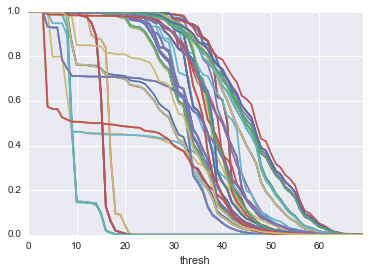

In [67]:
df_count.apply(lambda row: row/float(row.loc[0]),axis=1).T.plot.line(legend=False)

In [42]:
(df_count.loc[:,20]/df_count.loc[:,0]).sort_values().to_frame()

0
feature       component                      status  variable_type units      description                  
COUNT         respiratory rate               unknown qn            Breath     all                  0.000782
MEAN          respiratory rate               unknown qn            Breath     all                  0.000782
LAST          respiratory rate               unknown qn            Breath     all                  0.000782
STD           respiratory rate               unknown qn            Breath     all                  0.000852
LAST          blood pressure systolic        unknown qn            cc/min     all                  0.005176
MEAN          blood pressure systolic        unknown qn            cc/min     all                  0.005176
COUNT         blood pressure systolic        unknown qn            cc/min     all                  0.005176
MEAN          blood pressure diastolic       unknown qn            cc/min     all                  0.005177
COUNT         blood pressure diastolic       unknown qn            cc/min     all                  0.005177
LAST          blood pressure diastolic       unknown qn            cc/min     all                  0.005177
STD           blood pressure systolic        unknown qn            cc/min     all                  0.040257
              blood pressure diastolic       unknown qn            cc/min     all                  0.040257
              lactate                        known   qn            mmol/L     all                  0.448068
              hemoglobin                     known   qn            g/dL       all                  0.449654
LAST          hemoglobin                     known   qn            g/dL       all                  0.485592
COUNT         hemoglobin                     known   qn            g/dL       all                  0.485592
MEAN          hemoglobin                     known   qn            g/dL       all                  0.485592
LAST          heart rate                     known   qn            beats/min  all                  0.699046
COUNT         heart rate                     known   qn            beats/min  all                  0.699046
MEAN          heart rate                     known   qn            beats/min  all                  0.699046
COUNT         lactate                        known   qn            mmol/L     all                  0.705217
MEAN          lactate                        known   qn            mmol/L     all                  0.705217
LAST          lactate                        known   qn            mmol/L     all                  0.705217
STD           heart rate                     known   qn            beats/min  all                  0.711217
COUNT_NOMINAL output urine                   unknown nom           no_units   3686(ml)_Voiding qs  0.808517
COUNT         respiratory rate               known   qn            insp/min   all                  0.970886
LAST          respiratory rate               known   qn            insp/min   all                  0.970886
MEAN          respiratory rate               known   qn            insp/min   all                  0.970886
COUNT         blood pressure systolic        known   qn            mmHg       all                  0.973789
MEAN          blood pressure systolic        known   qn            mmHg       all                  0.973789
...                                                                                                     ...
LAST          norepinephrine                 known   qn            mcg/kg/min all                  0.995278
COUNT         norepinephrine                 known   qn            mcg/kg/min all                  0.995278
MEAN          norepinephrine                 known   qn            mcg        all                  0.995688
LAST          norepinephrine                 known   qn            mcg        all                  0.995688
COUNT         norepinephrine                 known   qn            mcg        all                  0.995688
SU

In [43]:
df_thresh = df_features.dropna(thresh=20)

In [50]:
df_no_all_nan = df_features.dropna(how='all')

In [51]:
print df_features.shape, '->',df_no_all_nan.shape,'->',df_thresh.shape, '({})'.format(np.round(df_thresh.shape[0]/float(df_no_all_nan.shape[0]),2))
print df_features.count().sum(), '->',df_no_all_nan.count().sum(),'->',df_thresh.count().sum(),'({})'.format(np.round(df_thresh.count().sum()/float(df_no_all_nan.count().sum()),2))

(1052742, 101) -> (616308, 101) -> (392294, 101) (0.64)
14609359 -> 14609359 -> 12775782 (0.87)


Using a threshold of 20 in this data set will...
 - Eliminate 36% of the non-null rows (~60% of the total rows coming out of the cleaning)
 - Eliminate 13% of the total data points
 
Seems like a pretty good tradeoff

But really we can be a bit mroe systematic here, and approach this like a minimization problem
- We want to minimize the ratio of true values lost : nan values
- This needs to be bounded though, because we don't want to remove every input

So we need the following information for each threshold:
- row count
- total value count (i.e. size of dataframe)
- non-nan value count (.count.sum)
- nan value count

In [77]:
df_stats = pd.DataFrame(index=['rows','size','non-nan_values','nan_values'], columns=range(0,df_features.shape[1]))
for thresh in df_stats.columns:
    print thresh
    df_thresh = df_features.dropna(thresh=thresh)
    df_stats.loc[:,thresh] = [df_thresh.shape[0],df_thresh.size,df_thresh.count().sum(),df_thresh.size-df_thresh.count().sum()]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [79]:
df_stats = df_stats.T

In [81]:
df_stats = df_stats.loc[df_stats.rows > 0]

In [123]:
df_stats['non-nan_lost'] = df_stats['non-nan_values'].shift(1)-df_stats['non-nan_values']
df_stats['nan_lost'] = df_stats['nan_values'].shift(1)-df_stats['nan_values']
df_stats['ratio'] = df_stats['non-nan_values']/df_stats['nan_values']
df_stats['ratio_lost'] = df_stats['non-nan_lost']/df_stats['nan_lost']
df_stats['ratio_delta'] = df_stats['ratio']-df_stats['ratio'].shift(1)
df_stats['ratio_delta_delta'] = df_stats['ratio_delta']-df_stats['ratio_delta'].shift(1)

df_stats

rows       size  non-nan_values  nan_values  non-nan_lost    nan_lost  \
0   1052742  106326942        14609359    91717583           NaN         NaN   
1    616308   62247108        14609359    47637749           0.0  44079834.0   
2    616050   62221050        14609101    47611949         258.0     25800.0   
3    616050   62221050        14609101    47611949           0.0         0.0   
4    570237   57593937        14471662    43122275      137439.0   4489674.0   
5    567419   57309319        14460390    42848929       11272.0    273346.0   
6    566561   57222661        14456100    42766561        4290.0     82368.0   
7    560494   56609894        14419698    42190196       36402.0    576365.0   
8    551218   55673018        14354766    41318252       64932.0    871944.0   
9    479301   48409401        13779430    34629971      575336.0   6688281.0   
10   428603   43288903        13323148    29965755      456282.0   4664216.0   
11   428224   43250624        13319358    29931266        3790.0     34489.0   
12   427571   43184671        13312175    29872496        7183.0     58770.0   
13   425501   42975601        13287335    29688266       24840.0    184230.0   
14   423957   42819657        13267263    29552394       20072.0    135872.0   
15   417222   42139422        13172973    28966449       94290.0    585945.0   
16   402185   40620685        12947418    27673267      225555.0   1293182.0   
17   399283   40327583        12900986    27426597       46432.0    246670.0   
18   397011   40098111        12862362    27235749       38624.0    190848.0   
19   393968   39790768        12807588    26983180       54774.0    252569.0   
20   392294   39621694        12775782    26845912       31806.0    137268.0   
21   377324   38109724        12476382    25633342      299400.0   1212570.0   
22   373761   37749861        12401559    25348302       74823.0    285040.0   
23   372133   37585433        12365743    25219690       35816.0    128612.0   
24   364996   36864596        12201592    24663004      164151.0    556686.0   
25   351084   35459484        11867704    23591780      333888.0   1071224.0   
26   336584   33994984        11505204    22489780      362500.0   1102000.0   
27   315353   31850653        10953198    20897455      552006.0   1592325.0   
28   303311   30634411        10628064    20006347      325134.0    891108.0   
29   295202   29815402        10401012    19414390      227052.0    591957.0   
..      ...        ...             ...         ...           ...         ...   
40    44803    4525103         1956362     2568741      384345.0    611010.0   
41    37423    3779723         1661162     2118561      295200.0    450180.0   
42    26762    2702962         1224061     1478901      437101.0    639660.0   
43    21624    2184024         1008265     1175759      215796.0    303142.0   
44    16370    1653370          782343      871027      225922.0    304732.0   
45    12839    1296739          626979      669760      155364.0    201267.0   
46    10974    1108374          543054      565320       83925.0    104440.0   
47     8733     882033          439968      442065      103086.0    123255.0   
48     6159     622059          318990      303069      120978.0    138996.0   
49     4949     499849          260910      238939       58080.0     64130.0   
50     4119     416019          220240      195779       40670.0     43160.0   
51     3232     326432          175890      150542       44350.0     45237.0   
52     2688     271488          148146      123342       27744.0     27200.0   
53     2108     212908          117986       94922       30160.0     28420.0   
54     1651     166751           93765       72986       24221.0     21936.0   
55     1366     137966           78375       59591       15390.0     13395.0   
56      941      95041           55000       40041       23375.0     19550.0   
57      632      63832           37696       26136       17304.0     13905.0   
58     

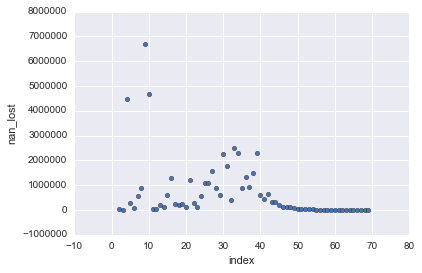

In [110]:
df_stats.nan_lost.iloc[2:].reset_index().plot(x='index',y='nan_lost',kind='scatter')

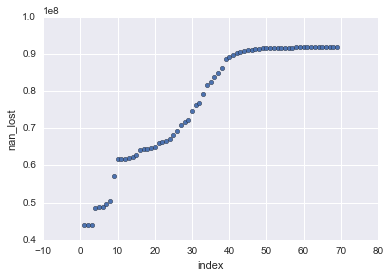

In [120]:
df_stats.nan_lost.cumsum().reset_index().plot(x='index',y='nan_lost',kind='scatter')

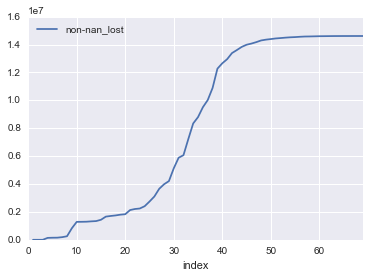

In [119]:
df_stats["non-nan_lost"].cumsum().reset_index().plot(x='index',y='non-nan_lost',kind='line')

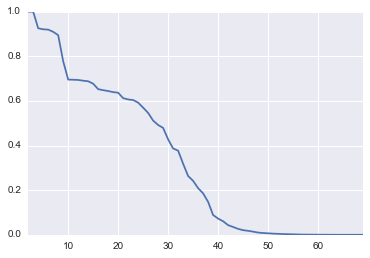

In [121]:
(df_stats['rows']/df_stats.loc[1,'rows']).iloc[2:].plot.line()

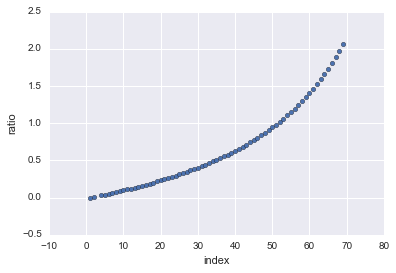

In [107]:
df_stats['ratio'].reset_index().plot(x='index',y='ratio',kind='scatter')

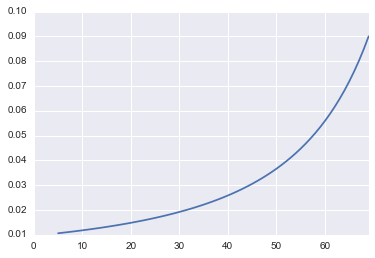

In [106]:
df_stats['ratio_delta'].plot(kind='line')

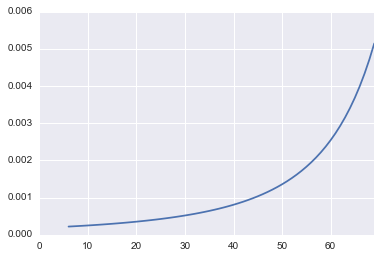

In [103]:
df_stats['ratio_delta_delta'].plot(kind='line')

Based on these graphs, I am still pretty darn satisfied with the thresh = 20 value. Using this will stop right before we start to remove a lot of 

What about the impact on columns?

In [56]:
df_thresh.count().sort_values()

feature        component                         status   variable_type  units      description        
STD            blood pressure systolic           unknown  qn             cc/min     all                       119
               blood pressure diastolic          unknown  qn             cc/min     all                       119
COUNT          respiratory rate                  unknown  qn             Breath     all                       120
STD            respiratory rate                  unknown  qn             Breath     all                       120
COUNT          blood pressure systolic           unknown  qn             cc/min     all                       120
LAST           respiratory rate                  unknown  qn             Breath     all                       120
               blood pressure diastolic          unknown  qn             cc/min     all                       120
               blood pressure systolic           unknown  qn             cc/min     all           

We will apply our pre-processor column filters again in post-processing

In [175]:
drop_low_counts = Pipeline([
        ('row_threshold',transformers.DropNaN(thresh=20)),
        ('drop_small_columns',transformers.remove_small_columns(threshold=1000)),
        ('drop_low_id_count',transformers.record_threshold(threshold=100))       
    ])

dsf_features.post_processor = drop_low_counts

In [75]:
df_features_clean = dsf_features.fit_transform(train_subset)

(2017-08-10 08:11:08) Make Feature Set. id_count=9436, #features=6
(2017-08-10 08:11:11)>> *fit* Filter columns (remove_small_columns) (1324365, 6)
(2017-08-10 08:11:11)<< --- (0.0s)
(2017-08-10 08:11:11)>> *transform* Filter columns (remove_small_columns) (1324365, 6)
(2017-08-10 08:11:11)<< --- (0.0s)
(2017-08-10 08:11:11)>> *fit* Filter columns (record_threshold) (1324365, 3)
(2017-08-10 08:11:11)<< --- (0.0s)
(2017-08-10 08:11:11)>> *transform* Filter columns (record_threshold) (1324365, 3)
(2017-08-10 08:11:11)<< --- (0.0s)
(2017-08-10 08:11:11)>> FIT Combine like columns (1324365, 3)
(2017-08-10 08:11:11)>>>> ('heart rate', 'known', 'qn', 'beats/min')
(2017-08-10 08:11:11)<<<< --- (0.0s)
(2017-08-10 08:11:11)<< --- (0.0s)
(2017-08-10 08:11:11)>> TRANSFORM Combine like columns (1324365, 3)
(2017-08-10 08:11:11)>>>> ('heart rate', 'known', 'qn', 'beats/min')
(2017-08-10 08:11:39)<<<< --- (28.0s)
(2017-08-10 08:11:39)<< --- (28.0s)
(2017-08-10 08:11:45)>> *fit* Filter columns (remov

In [122]:
df_features_clean.shape

(392294, 86)

How did this change our ratio of non-nan:nan values?

In [131]:
df=df_features
non_nan = df.count().sum()
print 'Raw Feature Set:\t\t',non_nan/float(df.size-non_nan),'\t',df.shape[0]

df=df_features.dropna(thresh=1)
non_nan = df.count().sum()
print 'No FULL NaN Rows, thresh=1:\t',non_nan/float(df.size-non_nan),'\t',df.shape[0]

df=df_features_clean
non_nan = df.count().sum()
print 'Cleaned, thresh=20:\t\t',non_nan/float(df.size-non_nan),'\t',df.shape[0]

Raw Feature Set:		0.159286349707 	1052742
No FULL NaN Rows, thresh=1:	0.306676098403 	616308
Cleaned, thresh=20:		0.60920109755 	392294


I am pretty satisfied with this. We can back off if need be, but seems to be a good result. Will now proceed with fillnan

In [176]:
dsf_features.should_fillna = True

In [180]:
df_features_final = dsf_features.fit_transform(train_subset)

(2017-08-16 15:45:02) Make Feature Set. id_count=9436, #features=7
(2017-08-16 15:45:14)>> *fit* Filter columns (remove_small_columns) (1324365, 6)
(2017-08-16 15:45:14)<< --- (0.0s)
(2017-08-16 15:45:14)>> *transform* Filter columns (remove_small_columns) (1324365, 6)
(2017-08-16 15:45:14)<< --- (0.0s)
(2017-08-16 15:45:14)>> *fit* Filter columns (record_threshold) (1324365, 3)
(2017-08-16 15:45:14)<< --- (0.0s)
(2017-08-16 15:45:14)>> *transform* Filter columns (record_threshold) (1324365, 3)
(2017-08-16 15:45:14)<< --- (0.0s)
(2017-08-16 15:45:14)>> FIT Combine like columns (1324365, 3)
(2017-08-16 15:45:14)>>>> ('heart rate', 'known', 'qn', 'beats/min')
(2017-08-16 15:45:14)<<<< --- (0.0s)
(2017-08-16 15:45:14)<< --- (0.0s)
(2017-08-16 15:45:14)>> TRANSFORM Combine like columns (1324365, 3)
(2017-08-16 15:45:14)>>>> ('heart rate', 'known', 'qn', 'beats/min')
(2017-08-16 15:45:40)<<<< --- (26.0s)
(2017-08-16 15:45:40)<< --- (26.0s)
(2017-08-16 15:45:59)>> *fit* Filter columns (remov

In [181]:
df_features_final.apply(pd.isnull).sum().sort_values()

feature        component                         status   variable_type  units       description        
MEAN_QN        heart rate                        known    qn             beats/min   all                    0
SUM            normal saline                     known    qn             mL          all                    0
               output urine                      known    qn             mL          all                    0
STD            hemoglobin                        known    qn             g/dL        all                    0
               vasopressin                       known    qn             units/min   all                    0
                                                                         units       all                    0
               norepinephrine                    known    qn             mcg/kg/min  all                    0
                                                                         mcg         all                    0
               

Yay, no null values! lets take a quick peak under the hood

In [182]:
df_features_final.describe()

feature              MEAN_QN                                                   \
component         heart rate blood pressure systolic blood pressure diastolic   
status                 known                   known                    known   
variable_type             qn                      qn                       qn   
units              beats/min                    mmHg                     mmHg   
description              all                     all                      all   
count          392294.000000           392294.000000            392294.000000   
mean               86.215655              122.087676                60.663944   
std                16.935639               21.883814                13.446062   
min                 0.000000                0.000000                 0.000000   
25%                74.000000              106.166667                51.500000   
50%                85.000000              120.000000                59.500000   
75%                97.333333              136.000000                68.500000   
max               190.000000              264.000000               244.000000   

feature                                                              \
component     blood pressure mean respiratory rate temperature body   
status                      known            known            known   
variable_type                  qn               qn               qn   
units                        mmHg         insp/min             degF   
description                   all              all              all   
count               392294.000000    392294.000000    392294.000000   
mean                    78.772272        20.204092        98.458727   
std                      9.627470         5.662024         2.198486   
min                      0.000000         0.000000         0.000000   
25%                     78.772272        16.000000        97.599998   
50%                     78.772272        19.500000        98.458727   
75%                     78.772272        23.500000        99.400000   
max                    349.000000       102.000000       106.750000   

feature                                                                       \
component     oxygen saturation pulse oximetry    weight body   output urine   
status                                   known          known          known   
variable_type                               qn             qn             qn   
units                                  percent             kg             mL   
description                                all            all            all   
count                            392294.000000  392294.000000  392294.000000   
mean                                 97.106272      85.923914     134.966712   
std                                   3.244389      20.423414     141.436647   
min                                   0.000000       0.000000       0.000000   
25%                                  96.000000      75.900000      47.500000   
50%                                  97.500000      85.923914     100.000000   
75%                                  99.000000      90.400002     170.000000   
max                                 100.000000     277.400000   12637.500000   

feature                              ...                  COUNT  \
component      normal saline         ...          normal saline   
status                 known         ...                  known   
variable_type             qn         ...                     qn   
units                     mL         ...                     mL   
description              all         ...                    all   
count          392294.000000         ...          392294.000000   
mean              509.982951         ...               0.014142   
std               149.136621         ...               0.132561   
min                 0.000000         ...               0.000000   
25%               509.982951         ...               0.000000   
50%         

In [196]:
utils.deconstruct_and_write(df_features_final,'data/data_sets.h5','simple/train/features')

In [197]:
utils.deconstruct_and_write(df_labels,'data/data_sets.h5','simple/train/labels')

In [202]:
df_labels_trimmed = df_labels.loc[df_features_final.index].dropna(how='all')
df_features_trimmed = df_features_final.loc[df_labels_trimmed.index]
print 'Labels: ',df_labels.shape,'->',df_labels_trimmed.shape
print 'Features: ',df_features_final.shape,'->',df_features_trimmed.shape,'--dropna-->',df_features_trimmed.dropna().shape

Labels:  (25975, 2) -> (16729, 2)
Features:  (392294, 86) -> (16729, 86) --dropna--> (16729, 86)


In [203]:
df_labels_trimmed

feature                    NEXT_LACTATE DELTA_LACTATE
component                       lactate       lactate
status                            known         known
variable_type                        qn            qn
units                            mmol/L        mmol/L
description                         all           all
id     datetime                                      
100058 2139-09-09 04:00:00          1.8           0.6
       2139-09-21 14:00:00          3.4           1.6
       2139-09-21 20:00:00          2.7          -0.7
100071 2160-03-27 14:00:00          5.4           NaN
100091 2162-06-04 00:00:00          1.4          -1.3
       2162-06-05 18:00:00          3.4           2.0
100114 2157-09-19 08:00:00          0.7          -0.5
       2157-09-19 20:00:00          1.1           0.4
       2157-09-19 22:00:00          1.1           0.1
       2157-09-20 04:00:00          1.0          -0.2
100116 2173-07-27 10:00:00          2.7           0.3
       2173-07-27 18:00:00          1.2          -1.5
       2173-07-28 02:00:00          1.3           0.1
100126 2196-06-11 04:00:00          1.1          -0.9
100138 2179-09-22 04:00:00          1.1           NaN
       2179-09-22 20:00:00          1.2           0.1
       2179-09-23 00:00:00          1.4           0.2
       2179-09-23 04:00:00          1.2          -0.2
       2179-09-23 16:00:00          1.0          -0.2
       2179-09-23 20:00:00          1.1           0.1
       2179-09-24 00:00:00          1.1           0.0
       2179-09-24 04:00:00          1.0          -0.1
       2179-09-24 22:00:00          1.1           0.1
       2179-09-25 04:00:00          1.5           0.4
       2179-09-25 20:00:00          1.2          -0.3
       2179-09-26 02:00:00          1.8           0.6
       2179-09-26 04:00:00          2.2          -0.4
       2179-09-27 00:00:00          1.2          -0.2
       2179-09-27 06:00:00          1.3           0.1
       2179-09-30 06:00:00          1.7           0.4
...                                 ...           ...
199803 2160-02-12 12:00:00          0.5          -0.2
       2160-02-12 20:00:00          0.7           0.2
       2160-02-13 02:00:00          0.5          -0.2
199811 2125-06-22 18:00:00          2.3           NaN
199919 2178-09-24 12:00:00          4.7           NaN
       2178-09-24 20:00:00          6.4           1.7
       2178-09-24 22:00:00          5.8          -0.6
       2178-09-25 10:00:00          6.0           0.2
       2178-09-26 00:00:00          3.7          -2.3
       2178-09-26 14:00:00          3.4          -0.3
       2178-09-26 16:00:00          4.7           1.3
       2178-09-27 08:00:00          4.3          -0.4
       2178-09-27 14:00:00          4.8           0.5
       2178-09-27 18:00:00          5.4           0.6
       2178-09-27 22:00:00          6.1           0.7
       2178-09-28 00:00:00          5.8          -0.3
       2178-09-28 02:00:00          8.2           2.4
       2178-09-28 08:00:00          8.9           0.7
       2178-09-28 12:00:00          7.3          -1.6
199969 2201-01-27 20:00:00          2.3          -0.1
       2201-01-28 02:00:00          1.8          -0.5
       2201-01-28 10:00:00          1.2          -0.6
       2201-01-28 18:00:00          1.7           0.5
       2201-01-29 08:00:00          0.8          -0.9
       2201-01-29 14:00:00          0.6          -0.2
       2201-01-29 22:00:00          0.8           0.2
       2201-01-30 04:00:00          0.7          -0.1
199988 2169-02-07 10:00:00          1.0          -0.6
       2169-02-07 16:00:00          1.0           0.0
       2169-02-07 22:00:00          1.1           0.1

[16729 rows x 2 columns]

('MEAN_QN', 'heart rate', 'known', 'qn', 'beats/min', 'all') 0/86


MEAN_QN
       heart rate
            known
               qn
        beats/min
              all
count  16729.0000
mean      90.3867
std       18.2090
min       34.1250
25%       77.5000
50%       89.0000
75%      102.5000
max      172.5000

80.0
MODE: 80.0
316
0.0188893538167


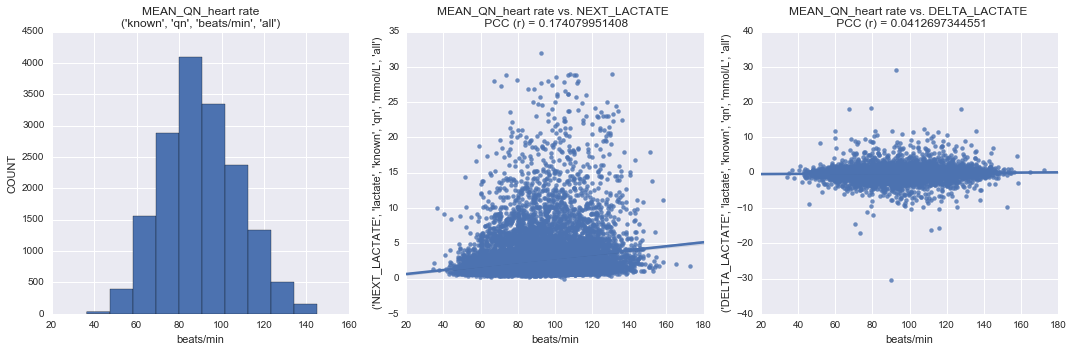

('MEAN_QN', 'blood pressure systolic', 'known', 'qn', 'mmHg', 'all') 1/86


MEAN_QN
      blood pressure systolic
                        known
                           qn
                         mmHg
                          all
count              16729.0000
mean                 116.5340
std                   21.9466
min                    0.0000
25%                  101.0000
50%                  113.0000
75%                  129.5000
max                  228.0000

112.0
MODE: 112.0
167
0.00998266483352


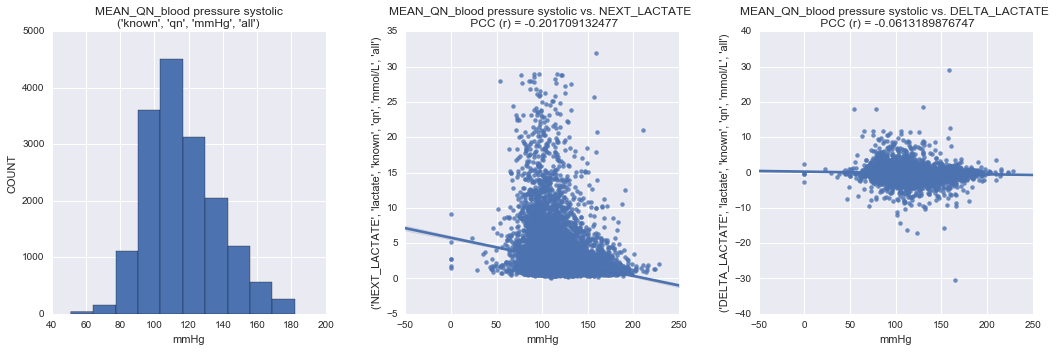

('MEAN_QN', 'blood pressure diastolic', 'known', 'qn', 'mmHg', 'all') 2/86


MEAN_QN
      blood pressure diastolic
                         known
                            qn
                          mmHg
                           all
count               16729.0000
mean                   59.0992
std                    12.9378
min                     0.0000
25%                    50.5000
50%                    57.5000
75%                    66.5000
max                   148.5000

56.0
MODE: 56.0
281
0.0167971785522


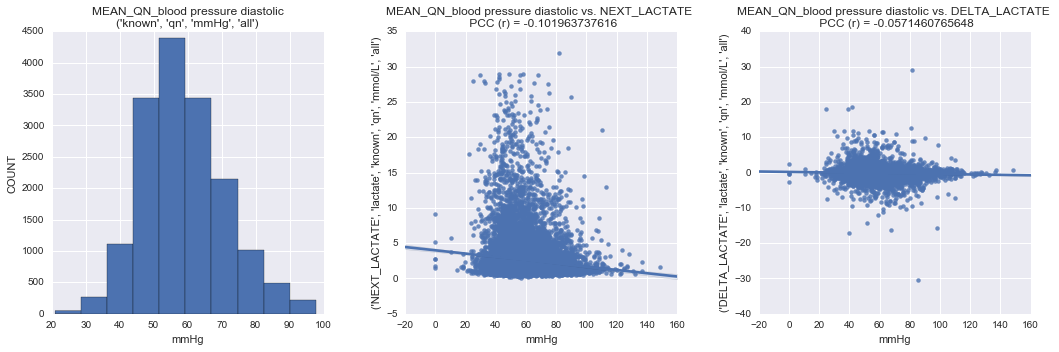

('MEAN_QN', 'blood pressure mean', 'known', 'qn', 'mmHg', 'all') 3/86


MEAN_QN
      blood pressure mean
                    known
                       qn
                     mmHg
                      all
count          16729.0000
mean              77.9915
std               10.6681
min                3.0000
25%               76.0000
50%               78.7723
75%               78.7723
max              307.0000

78.7722717617
MODE: 78.7722717617
8997
0.537808595852


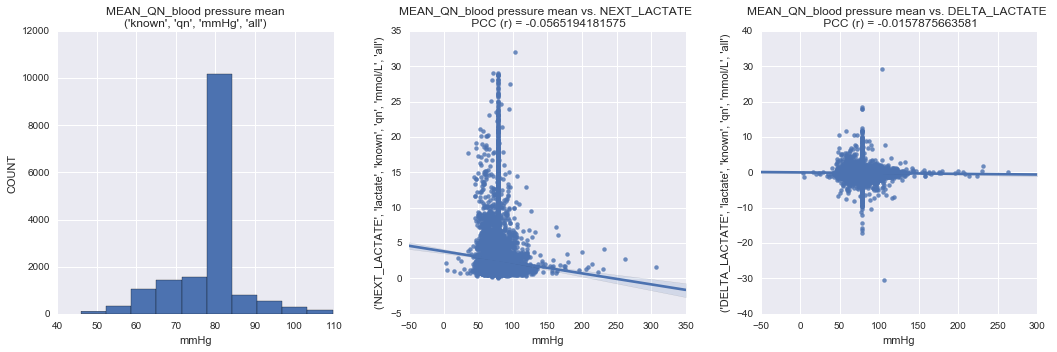

('MEAN_QN', 'respiratory rate', 'known', 'qn', 'insp/min', 'all') 4/86


MEAN_QN
      respiratory rate
                 known
                    qn
              insp/min
                   all
count       16729.0000
mean           20.7597
std             6.3832
min             0.0000
25%            16.0000
50%            20.0000
75%            24.5000
max            74.5000

20.0
MODE: 20.0
756
0.0451909857134


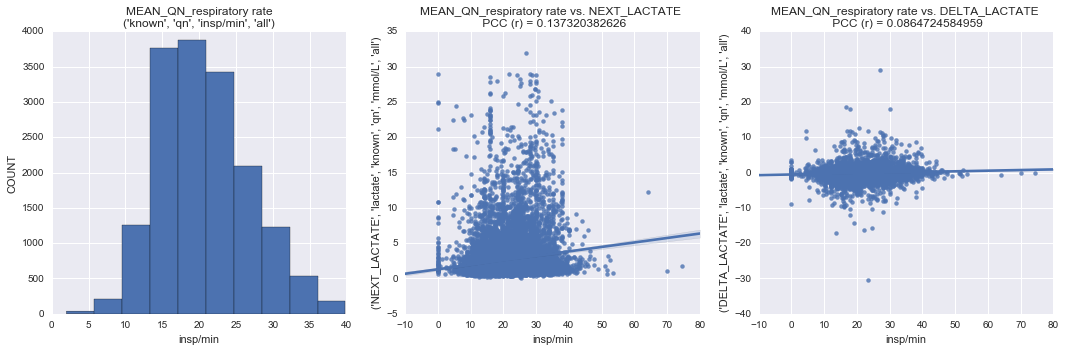

('MEAN_QN', 'temperature body', 'known', 'qn', 'degF', 'all') 5/86


MEAN_QN
      temperature body
                 known
                    qn
                  degF
                   all
count       16729.0000
mean           98.3216
std             3.4865
min             0.0000
25%            97.5000
50%            98.4587
75%            99.5000
max           106.3000

98.4587266171
MODE: 98.4587266171
548
0.0327574869986


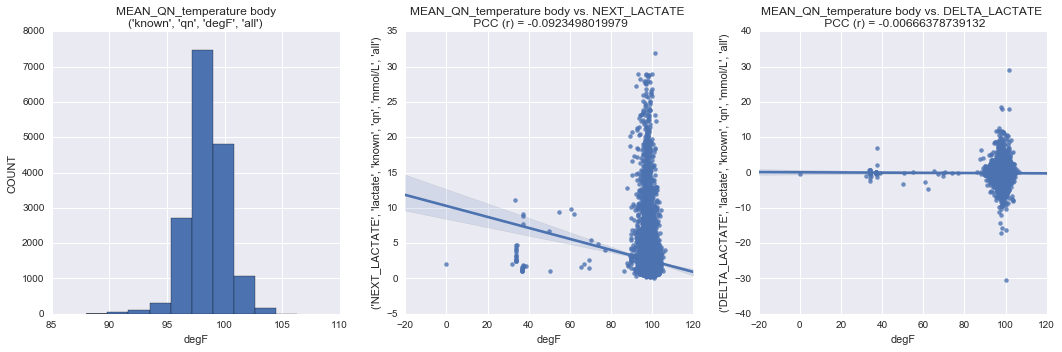

('MEAN_QN', 'oxygen saturation pulse oximetry', 'known', 'qn', 'percent', 'all') 6/86


MEAN_QN
      oxygen saturation pulse oximetry
                                 known
                                    qn
                               percent
                                   all
count                       16729.0000
mean                           96.8699
std                             4.8826
min                             0.0000
25%                            95.7500
50%                            98.0000
75%                            99.5000
max                           100.0000

100.0
MODE: 100.0
3436
0.205391834539


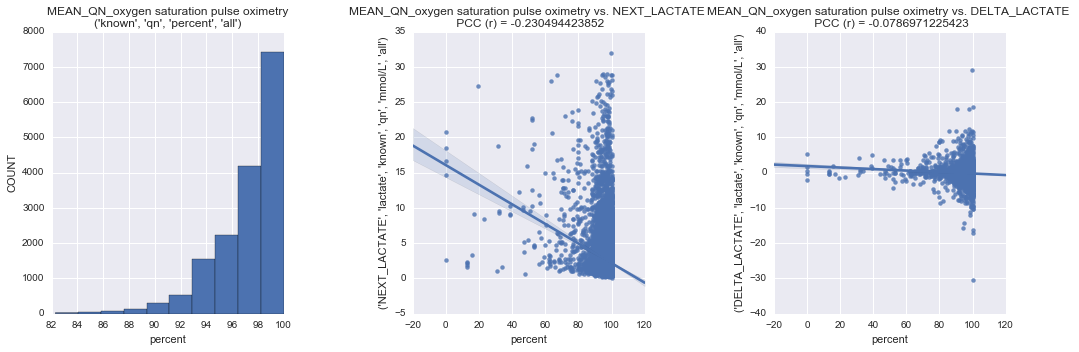

('MEAN_QN', 'weight body', 'known', 'qn', 'kg', 'all') 7/86


MEAN_QN
      weight body
            known
               qn
               kg
              all
count  16729.0000
mean      88.2407
std       20.5419
min        0.0000
25%       80.9000
50%       85.9239
75%       92.0000
max      277.4000

85.9239143593
MODE: 85.9239143593
6305
0.376890429793


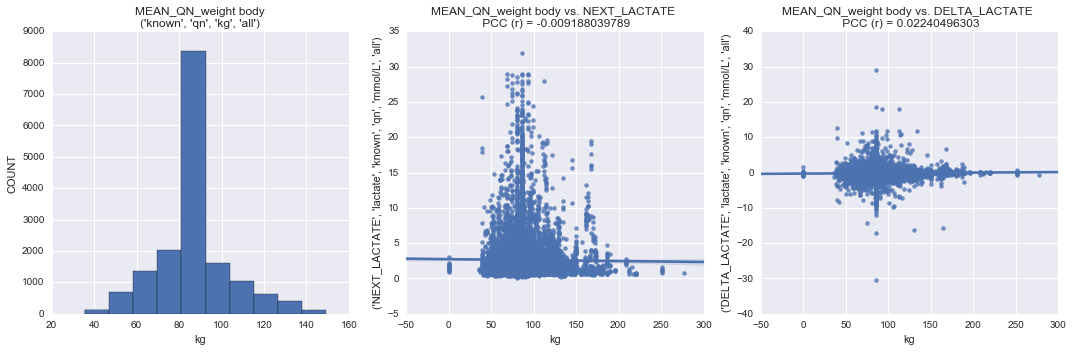

('MEAN_QN', 'output urine', 'known', 'qn', 'mL', 'all') 8/86


MEAN_QN
      output urine
             known
                qn
                mL
               all
count   16729.0000
mean      101.1045
std       122.1714
min         0.0000
25%        28.0000
50%        70.0000
75%       134.9667
max      3200.0000

134.966712479
MODE: 134.966712479
1031
0.0616295056489


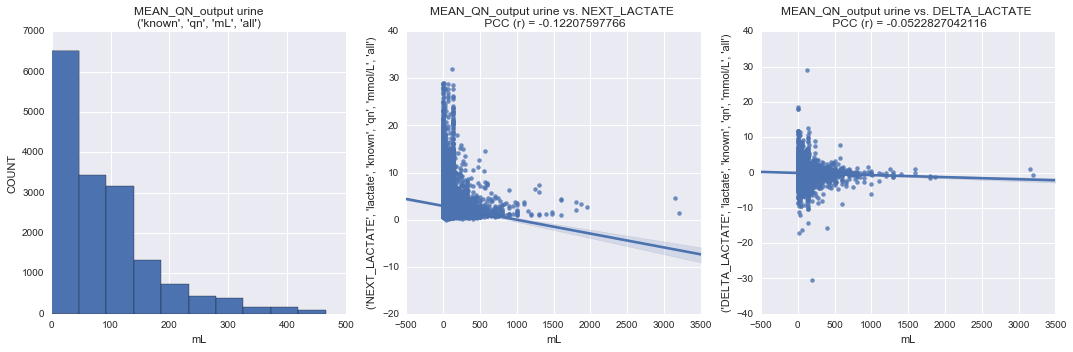

('MEAN_QN', 'normal saline', 'known', 'qn', 'mL', 'all') 9/86


MEAN_QN
      normal saline
              known
                 qn
                 mL
                all
count    16729.0000
mean       515.2669
std        203.9554
min          0.0000
25%        509.9830
50%        509.9830
75%        509.9830
max       5000.0000

509.982951271
MODE: 509.982951271
12252
0.732380895451


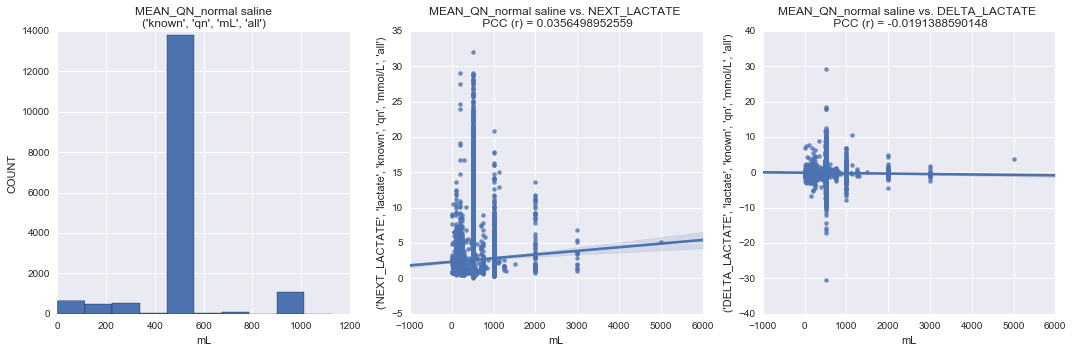

('MEAN_QN', 'normal saline', 'known', 'qn', 'mL/hr', 'all') 10/86


MEAN_QN
      normal saline
              known
                 qn
              mL/hr
                all
count    16729.0000
mean        88.6504
std        109.2098
min          0.0963
25%         22.7004
50%        102.3996
75%        102.3996
max       3900.0000

102.399602187
MODE: 102.399602187
9598
0.573734233965


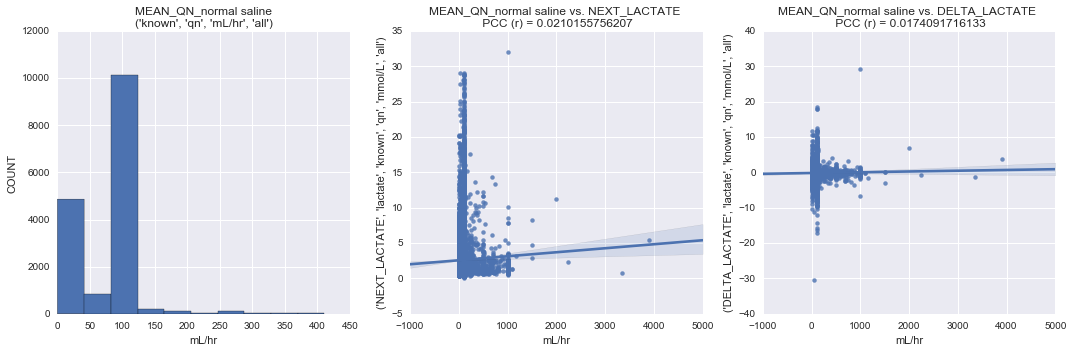

('MEAN_QN', 'lactated ringers', 'known', 'qn', 'mL', 'all') 11/86


MEAN_QN
      lactated ringers
                 known
                    qn
                    mL
                   all
count       16729.0000
mean          423.0845
std           274.6670
min             0.0000
25%           402.0443
50%           402.0443
75%           402.0443
max          6000.0000

402.044268538
MODE: 402.044268538
9008
0.538466136649


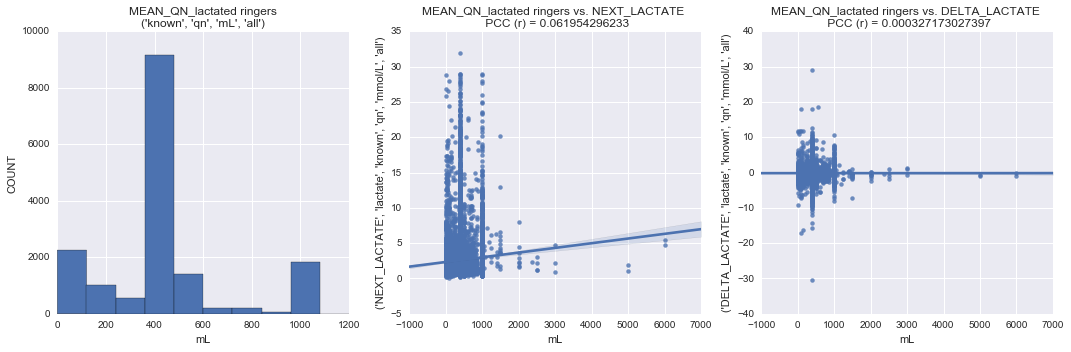

('MEAN_QN', 'norepinephrine', 'known', 'qn', 'mcg', 'all') 12/86


MEAN_QN
      norepinephrine
               known
                  qn
                 mcg
                 all
count     16729.0000
mean        256.8447
std         685.9966
min           0.0000
25%         144.0000
50%         156.5854
75%         156.5854
max       23549.2012

156.585418357
MODE: 156.585418357
9774
0.584254886724


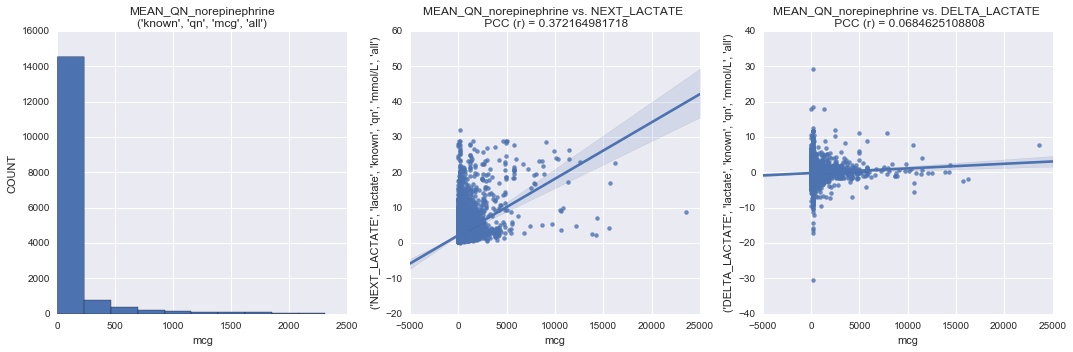

('MEAN_QN', 'norepinephrine', 'known', 'qn', 'mcg/kg/min', 'all') 13/86


MEAN_QN
      norepinephrine
               known
                  qn
          mcg/kg/min
                 all
count     16729.0000
mean          0.0730
std           0.1122
min           0.0000
25%           0.0560
50%           0.0560
75%           0.0560
max           3.5000

0.0560073411242
MODE: 0.0560073411242
13046
0.779843385737


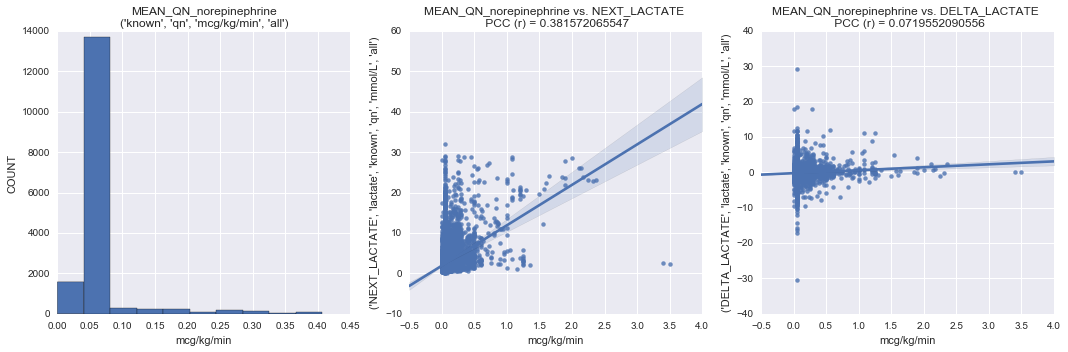

('MEAN_QN', 'vasopressin', 'known', 'qn', 'units', 'all') 14/86


MEAN_QN
      vasopressin
            known
               qn
            units
              all
count  16729.0000
mean       1.2774
std        2.1119
min        0.0000
25%        1.1909
50%        1.1909
75%        1.1909
max      150.0000

1.19094673957
MODE: 1.19094673957
15379
0.919301811226


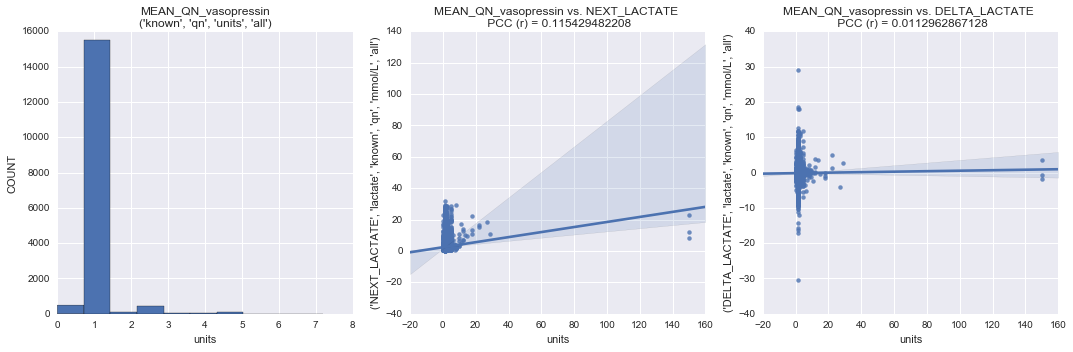

('MEAN_QN', 'vasopressin', 'known', 'qn', 'units/min', 'all') 15/86


MEAN_QN
      vasopressin
            known
               qn
        units/min
              all
count  16729.0000
mean       0.6833
std        0.3470
min        0.0000
25%        0.6649
50%        0.6649
75%        0.6649
max        4.8000

0.664913527345
MODE: 0.664913527345
15231
0.910454898679


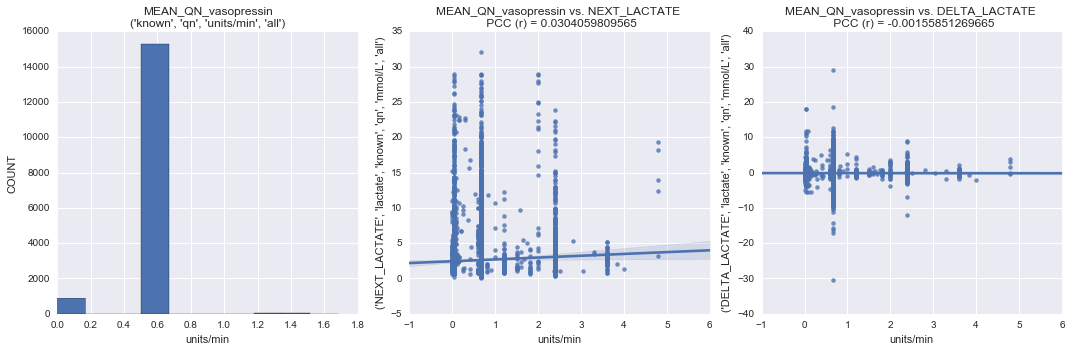

('MEAN_QN', 'hemoglobin', 'known', 'qn', 'g/dL', 'all') 16/86


MEAN_QN
       hemoglobin
            known
               qn
             g/dL
              all
count  16729.0000
mean      10.2265
std        1.6808
min        0.0000
25%        9.1750
50%       10.1704
75%       11.1000
max       20.1000

10.1703542525
MODE: 10.1703542525
998
0.0596568832566


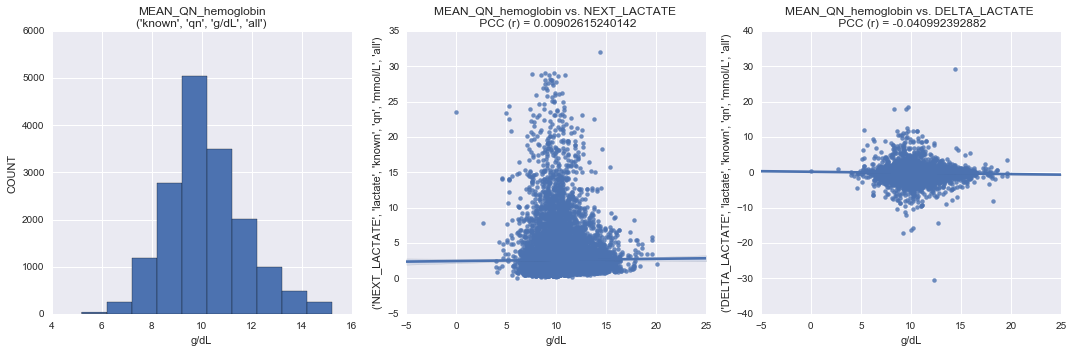

('MEAN_QN', 'lactate', 'known', 'qn', 'mmol/L', 'all') 17/86


MEAN_QN
          lactate
            known
               qn
           mmol/L
              all
count  16729.0000
mean       2.6768
std        2.8137
min        0.2000
25%        1.3000
50%        1.7060
75%        2.8000
max       32.0000

1.70599658322
MODE: 1.70599658322
2352
0.140594177775


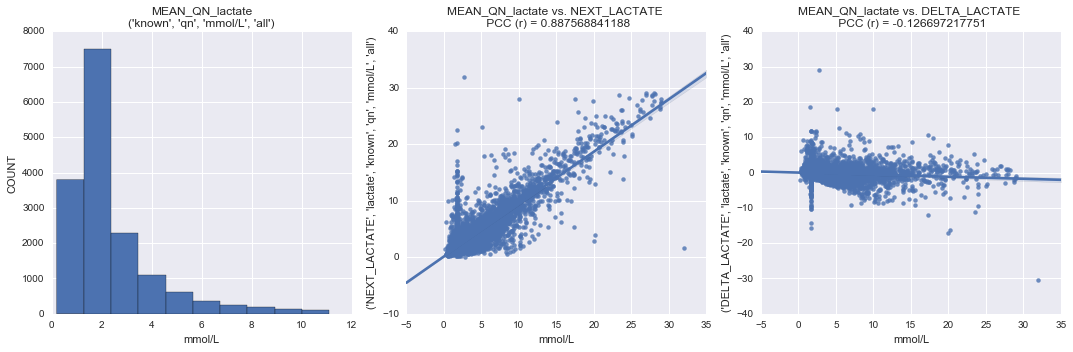

('MEAN_ORD', 'glasgow coma scale motor', 'known', 'ord', 'no_units', 'all') 18/86


MEAN_ORD
      glasgow coma scale motor
                         known
                           ord
                      no_units
                           all
count               16729.0000
mean                    5.1385
std                     1.6616
min                     1.0000
25%                     5.0000
50%                     6.0000
75%                     6.0000
max                     6.0000

6.0
MODE: 6.0
11817
0.706378145735


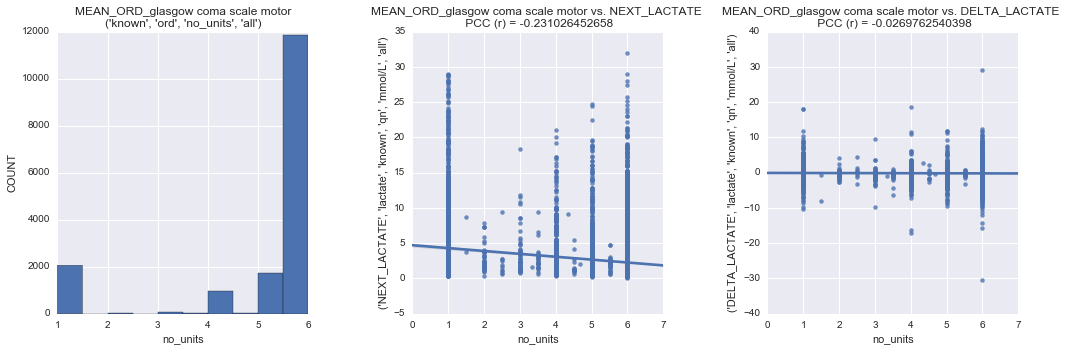

('MEAN_ORD', 'glasgow coma scale eye opening', 'known', 'ord', 'no_units', 'all') 19/86


MEAN_ORD
      glasgow coma scale eye opening
                               known
                                 ord
                            no_units
                                 all
count                     16729.0000
mean                          3.2800
std                           1.1301
min                           1.0000
25%                           3.0000
50%                           4.0000
75%                           4.0000
max                           4.0000

4.0
MODE: 4.0
11026
0.659094984757


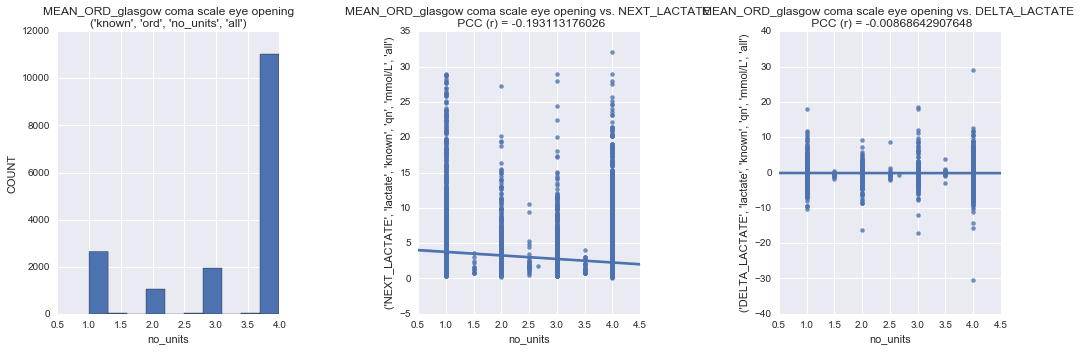

('MEAN_ORD', 'glasgow coma scale verbal', 'known', 'ord', 'no_units', 'all') 20/86


MEAN_ORD
      glasgow coma scale verbal
                          known
                            ord
                       no_units
                            all
count                16729.0000
mean                     1.4865
std                      1.2607
min                      1.0000
25%                      1.0000
50%                      1.0000
75%                      1.0000
max                      5.0000

1.0
MODE: 1.0
14474
0.865204136529


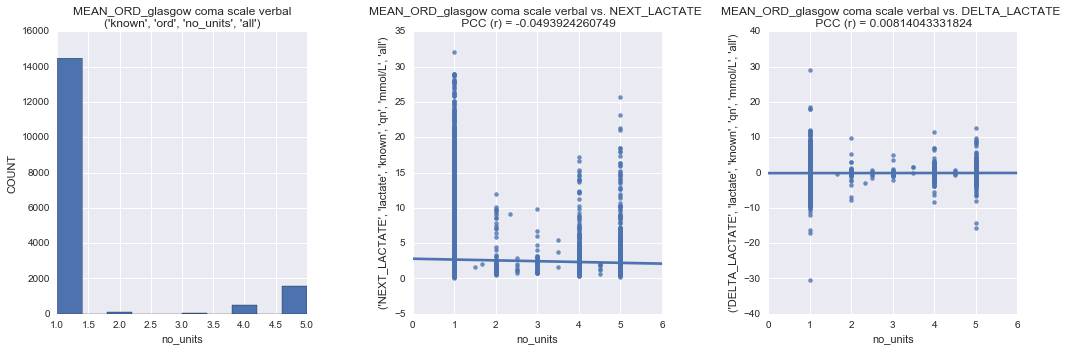

('LAST', 'heart rate', 'known', 'qn', 'beats/min', 'all') 21/86


LAST
       heart rate
            known
               qn
        beats/min
              all
count  16729.0000
mean      90.3065
std       18.7441
min        0.0000
25%       77.0000
50%       89.0000
75%      103.0000
max      177.0000

80.0
MODE: 80.0
540
0.0322792755096


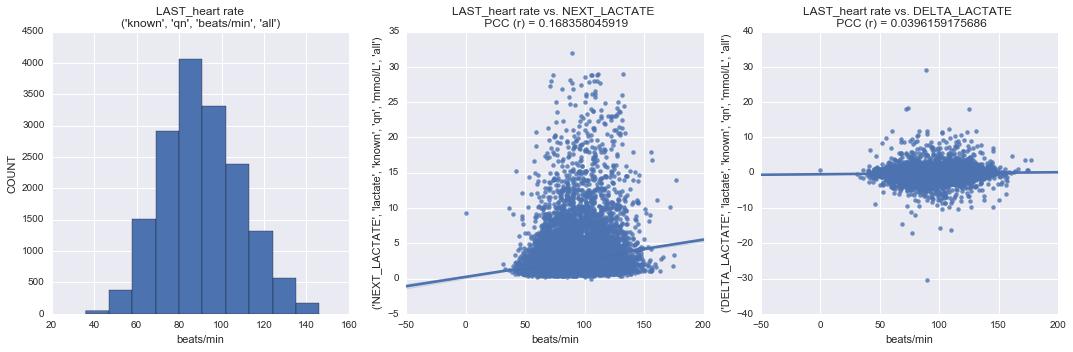

('LAST', 'blood pressure systolic', 'known', 'qn', 'mmHg', 'all') 22/86


LAST
      blood pressure systolic
                        known
                           qn
                         mmHg
                          all
count              16729.0000
mean                 116.5077
std                   24.0807
min                    0.0000
25%                  100.0000
50%                  113.0000
75%                  131.0000
max                  257.0000

105.0
MODE: 105.0
342
0.0204435411561


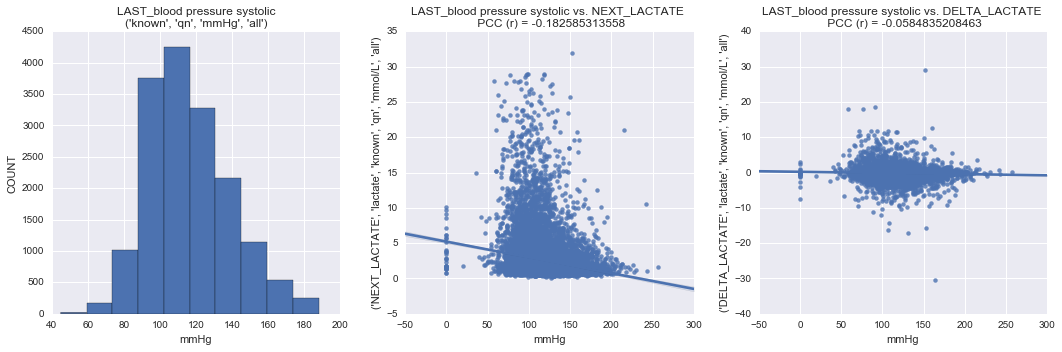

('LAST', 'blood pressure diastolic', 'known', 'qn', 'mmHg', 'all') 23/86


LAST
      blood pressure diastolic
                         known
                            qn
                          mmHg
                           all
count               16729.0000
mean                   59.0399
std                    14.1906
min                     0.0000
25%                    50.0000
50%                    57.0000
75%                    67.0000
max                   193.0000

58.0
MODE: 58.0
595
0.0355669794967


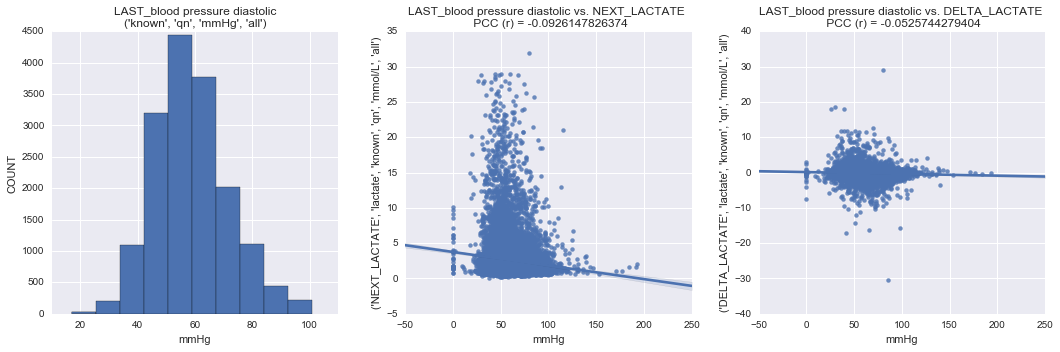

('LAST', 'blood pressure mean', 'known', 'qn', 'mmHg', 'all') 24/86


LAST
      blood pressure mean
                    known
                       qn
                     mmHg
                      all
count          16729.0000
mean              77.8841
std               13.3016
min                0.0000
25%               76.0000
50%               78.5661
75%               78.5661
max              356.0000

78.5660946538
MODE: 78.5660946538
8997
0.537808595852


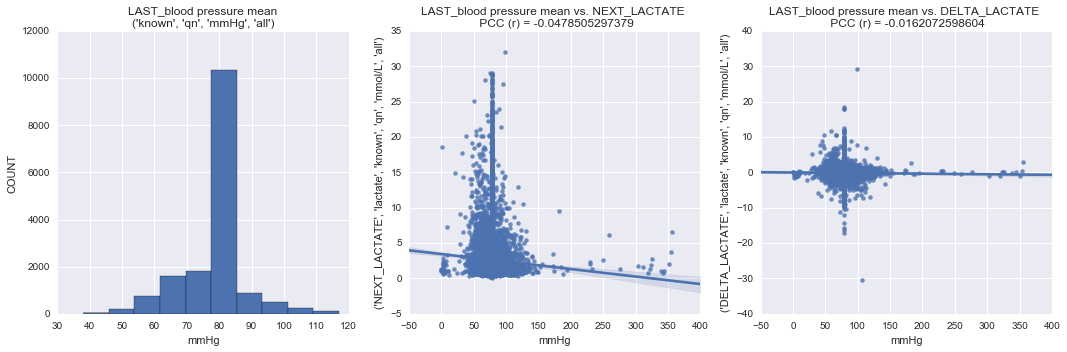

('LAST', 'respiratory rate', 'known', 'qn', 'insp/min', 'all') 25/86


LAST
      respiratory rate
                 known
                    qn
              insp/min
                   all
count       16729.0000
mean           20.7612
std             6.9089
min             0.0000
25%            16.0000
50%            20.0000
75%            25.0000
max            73.0000

16.0
MODE: 16.0
1278
0.0763942853727


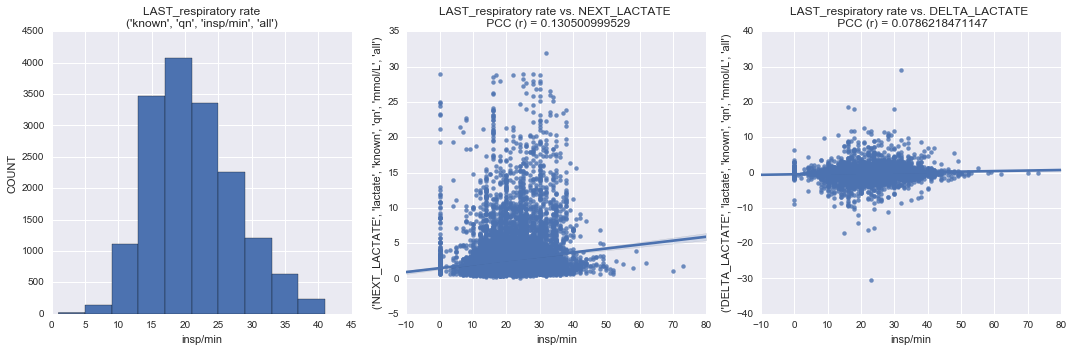

('LAST', 'temperature body', 'known', 'qn', 'degF', 'all') 26/86


LAST
      temperature body
                 known
                    qn
                  degF
                   all
count       16729.0000
mean           98.3416
std             3.4742
min             0.0000
25%            97.5000
50%            98.4623
75%            99.5000
max           106.6000

98.4622618466
MODE: 98.4622618466
548
0.0327574869986


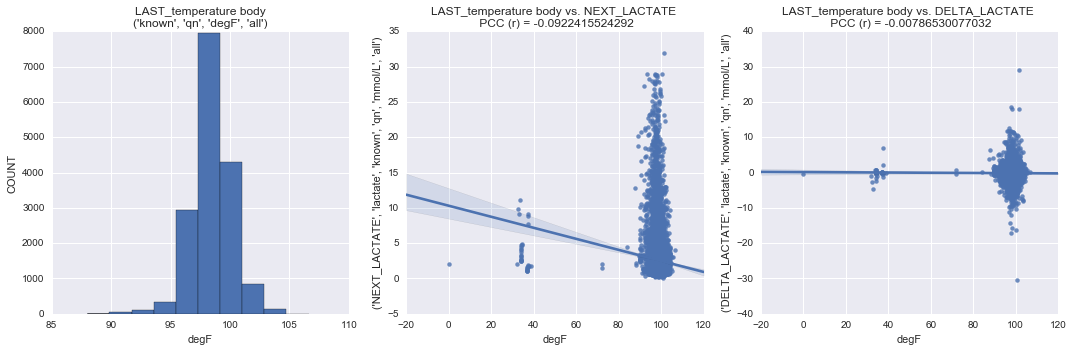

('LAST', 'oxygen saturation pulse oximetry', 'known', 'qn', 'percent', 'all') 27/86


LAST
      oxygen saturation pulse oximetry
                                 known
                                    qn
                               percent
                                   all
count                       16729.0000
mean                           96.8402
std                             5.4311
min                             0.0000
25%                            96.0000
50%                            98.0000
75%                           100.0000
max                           100.0000

100.0
MODE: 100.0
4903
0.29308386634


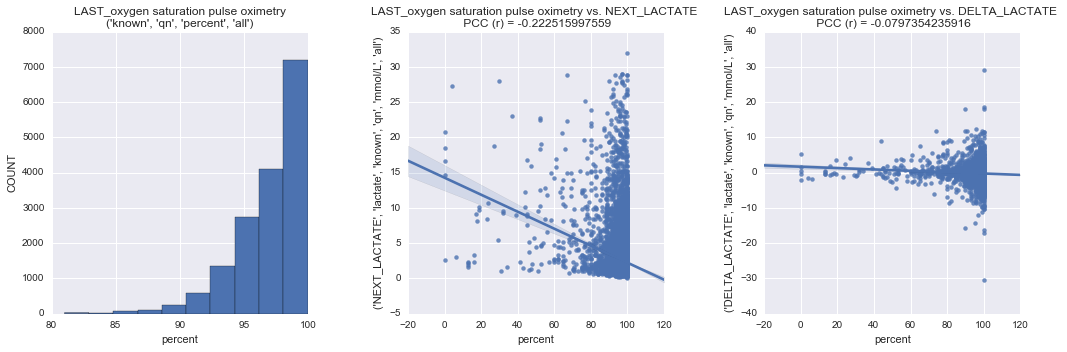

('LAST', 'weight body', 'known', 'qn', 'kg', 'all') 28/86


LAST
      weight body
            known
               qn
               kg
              all
count  16729.0000
mean      88.2407
std       20.5714
min        0.0000
25%       80.9000
50%       85.9244
75%       92.0000
max      277.4000

85.9244419485
MODE: 85.9244419485
6305
0.376890429793


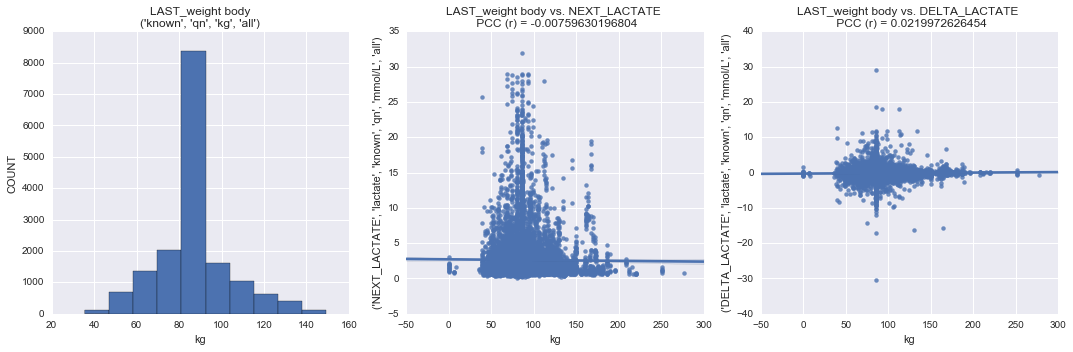

('LAST', 'output urine', 'known', 'qn', 'mL', 'all') 29/86


LAST
      output urine
             known
                qn
                mL
               all
count   16729.0000
mean       98.0922
std       123.8025
min         0.0000
25%        25.0000
50%        60.0000
75%       131.7261
max      3200.0000

100.0
MODE: 100.0
1068
0.0638412337856


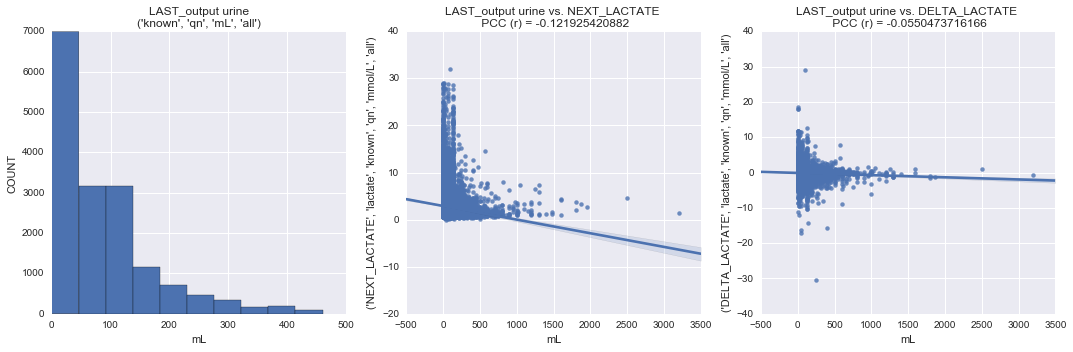

('LAST', 'glasgow coma scale motor', 'known', 'ord', 'no_units', 'all') 30/86


LAST
      glasgow coma scale motor
                         known
                           ord
                      no_units
                           all
count               16729.0000
mean                    4.7883
std                     1.5151
min                     1.0000
25%                     5.0000
50%                     5.2445
75%                     5.2445
max                     6.0000

5.24452810329
MODE: 5.24452810329
7868
0.470320999462


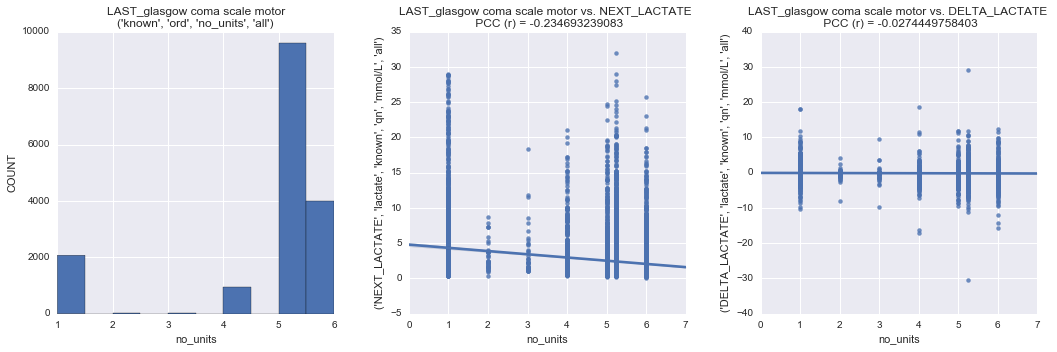

('LAST', 'glasgow coma scale eye opening', 'known', 'ord', 'no_units', 'all') 31/86


LAST
      glasgow coma scale eye opening
                               known
                                 ord
                            no_units
                                 all
count                     16729.0000
mean                          2.9612
std                           0.9660
min                           1.0000
25%                           3.0000
50%                           3.3149
75%                           3.3149
max                           4.0000

3.3148902409
MODE: 3.3148902409
7854
0.469484129356


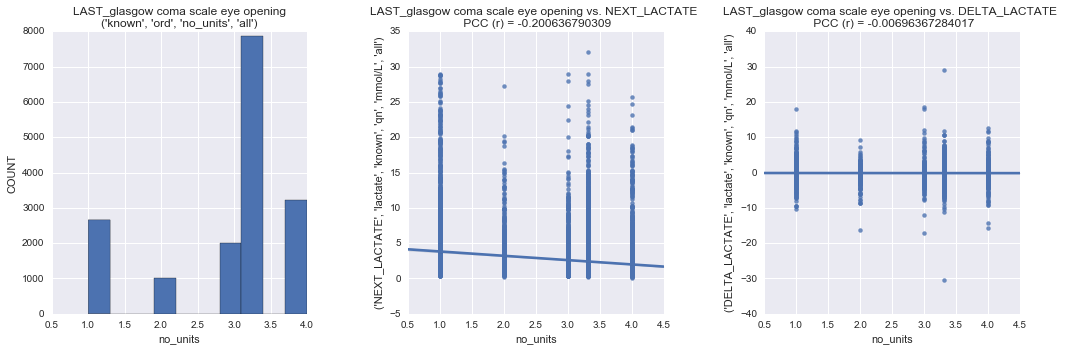

('LAST', 'glasgow coma scale verbal', 'known', 'ord', 'no_units', 'all') 32/86


LAST
      glasgow coma scale verbal
                          known
                            ord
                       no_units
                            all
count                16729.0000
mean                     2.3792
std                      1.2743
min                      1.0000
25%                      1.0000
50%                      2.8987
75%                      2.8987
max                      5.0000

2.89868239588
MODE: 2.89868239588
7857
0.469663458665


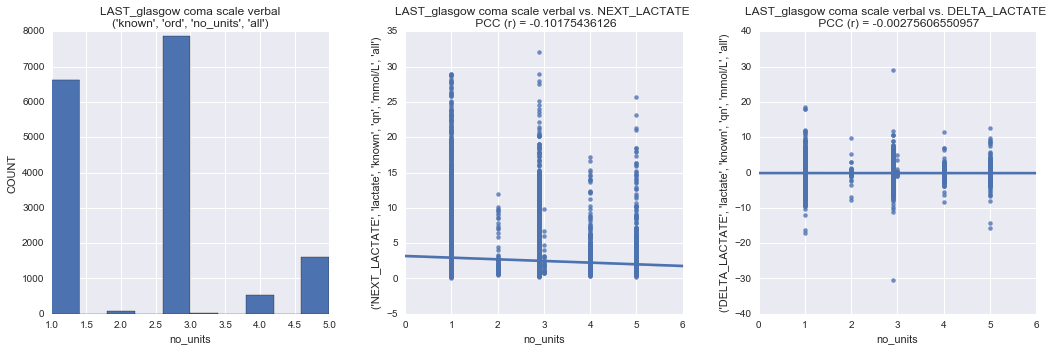

('LAST', 'normal saline', 'known', 'qn', 'mL', 'all') 33/86


LAST
      normal saline
              known
                 qn
                 mL
                all
count    16729.0000
mean       513.7667
std        195.9866
min          0.0000
25%        508.8253
50%        508.8253
75%        508.8253
max       5000.0000

508.825281635
MODE: 508.825281635
12252
0.732380895451


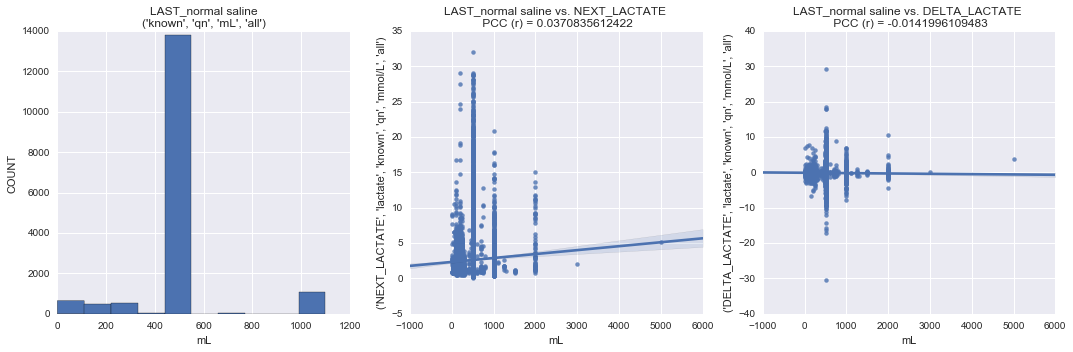

('LAST', 'normal saline', 'known', 'qn', 'mL/hr', 'all') 34/86


LAST
      normal saline
              known
                 qn
              mL/hr
                all
count    16729.0000
mean        84.6120
std        108.7267
min          0.0584
25%         18.1159
50%         98.4283
75%         98.4283
max       3900.0000

98.428291221
MODE: 98.428291221
9598
0.573734233965


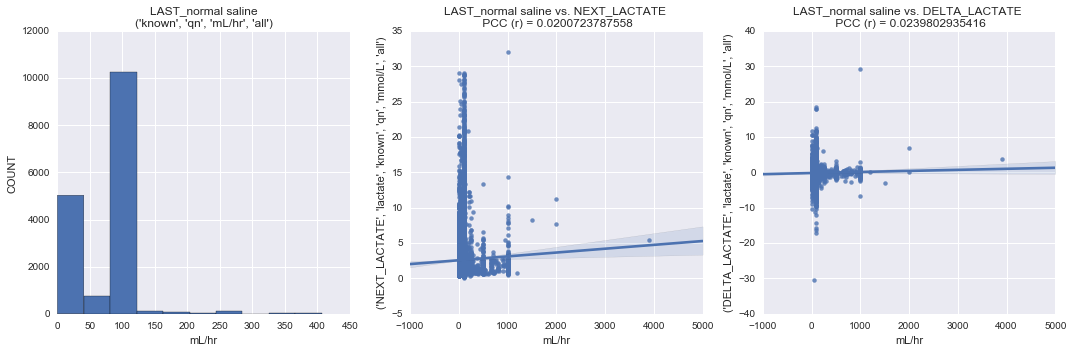

('LAST', 'lactated ringers', 'known', 'qn', 'mL', 'all') 35/86


LAST
      lactated ringers
                 known
                    qn
                    mL
                   all
count       16729.0000
mean          421.9956
std           279.6888
min             0.0000
25%           400.4178
50%           400.4178
75%           400.4178
max          6000.0000

400.417840223
MODE: 400.417840223
9008
0.538466136649


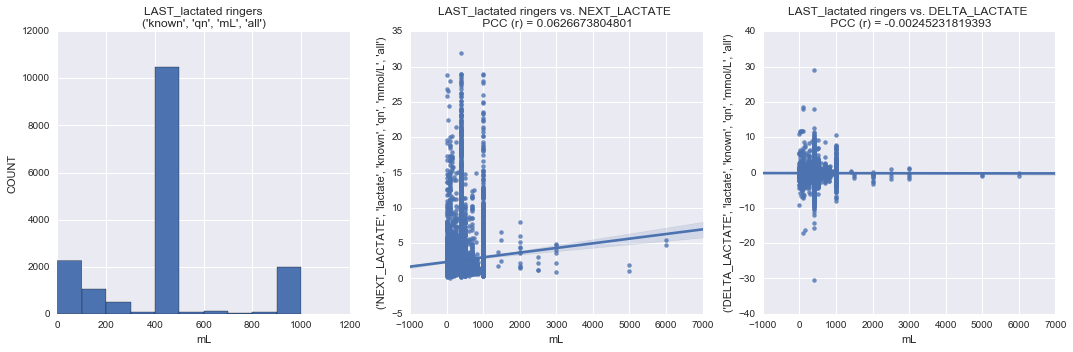

('LAST', 'norepinephrine', 'known', 'qn', 'mcg', 'all') 36/86


LAST
      norepinephrine
               known
                  qn
                 mcg
                 all
count     16729.0000
mean        241.5517
std         672.4996
min           0.0000
25%         128.0000
50%         141.7488
75%         141.7488
max       23549.2012

141.748811988
MODE: 141.748811988
9774
0.584254886724


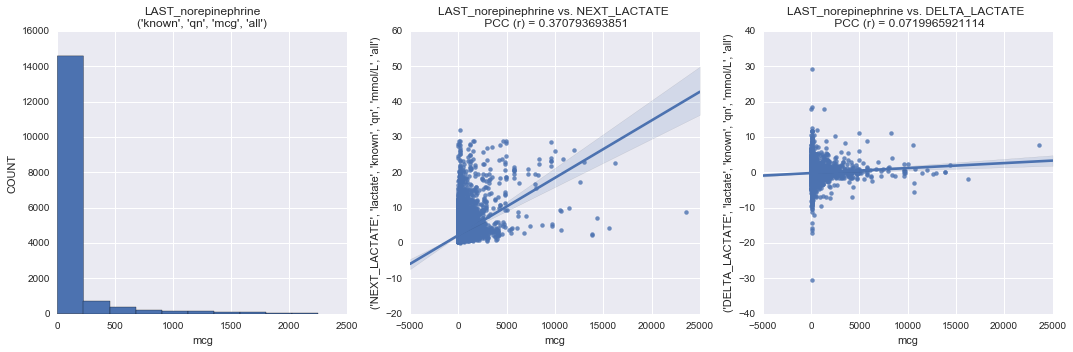

('LAST', 'norepinephrine', 'known', 'qn', 'mcg/kg/min', 'all') 37/86


LAST
      norepinephrine
               known
                  qn
          mcg/kg/min
                 all
count     16729.0000
mean          0.0681
std           0.1154
min           0.0000
25%           0.0505
50%           0.0505
75%           0.0505
max           3.4000

0.0504894770012
MODE: 0.0504894770012
13046
0.779843385737


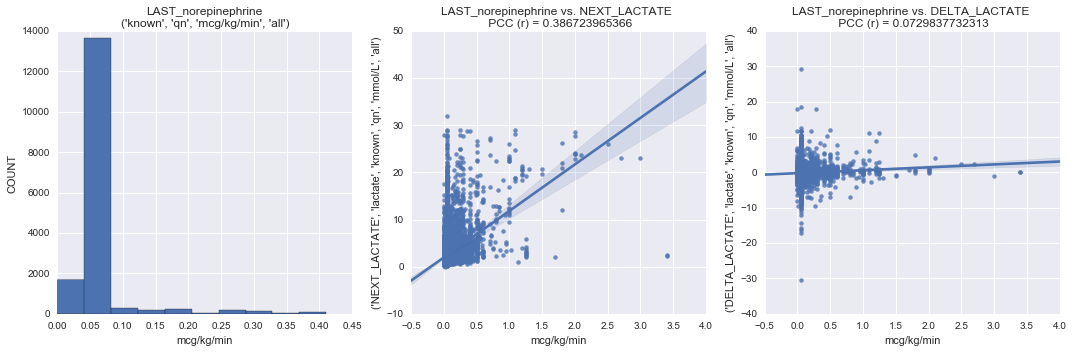

('LAST', 'vasopressin', 'known', 'qn', 'units', 'all') 38/86


LAST
      vasopressin
            known
               qn
            units
              all
count  16729.0000
mean       1.1889
std        2.1086
min        0.0000
25%        1.1002
50%        1.1002
75%        1.1002
max      150.0000

1.10023093524
MODE: 1.10023093524
15379
0.919301811226


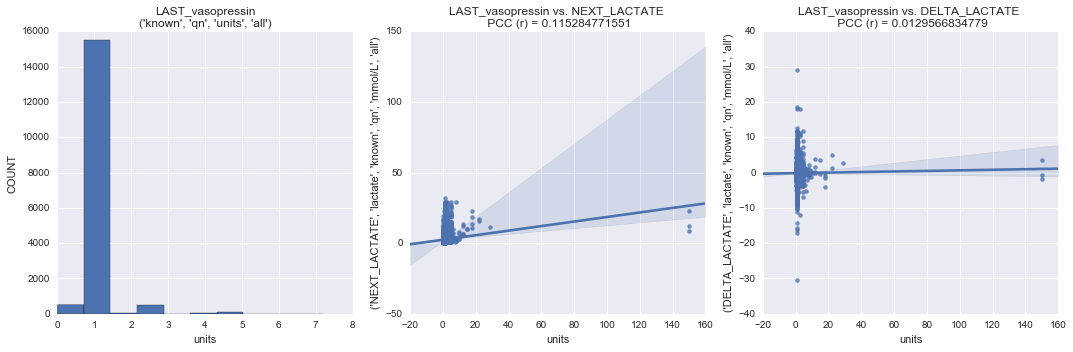

('LAST', 'vasopressin', 'known', 'qn', 'units/min', 'all') 39/86


LAST
      vasopressin
            known
               qn
        units/min
              all
count  16729.0000
mean       0.6426
std        0.3500
min        0.0000
25%        0.6222
50%        0.6222
75%        0.6222
max        4.8000

0.622158007878
MODE: 0.622158007878
15231
0.910454898679


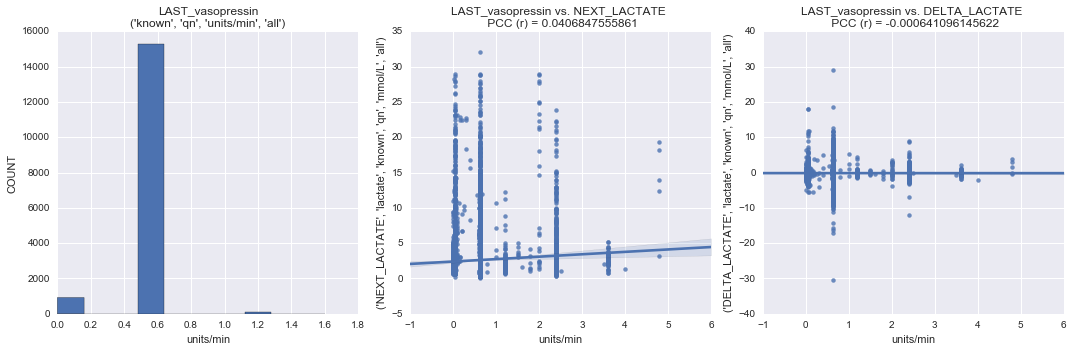

('LAST', 'hemoglobin', 'known', 'qn', 'g/dL', 'all') 40/86


LAST
       hemoglobin
            known
               qn
             g/dL
              all
count  16729.0000
mean      10.2436
std        1.6862
min        0.0000
25%        9.2000
50%       10.1753
75%       11.1000
max       20.1000

10.1753038812
MODE: 10.1753038812
998
0.0596568832566


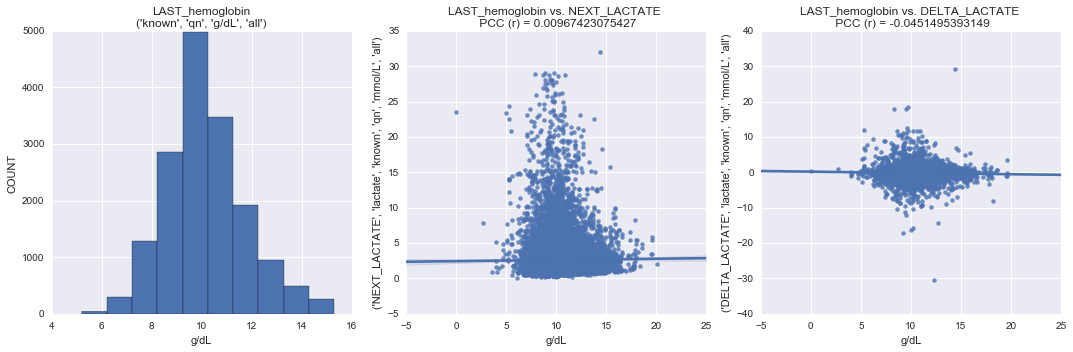

('LAST', 'lactate', 'known', 'qn', 'mmol/L', 'all') 41/86


LAST
          lactate
            known
               qn
           mmol/L
              all
count  16729.0000
mean       2.6754
std        2.8199
min        0.2000
25%        1.3000
50%        1.7050
75%        2.8000
max       32.0000

1.70503684792
MODE: 1.70503684792
2352
0.140594177775


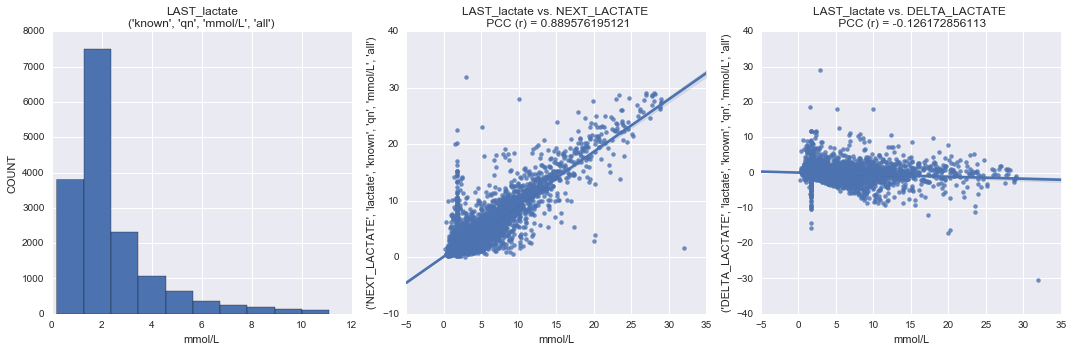

('STD', 'heart rate', 'known', 'qn', 'beats/min', 'all') 42/86


STD
       heart rate
            known
               qn
        beats/min
              all
count  16729.0000
mean       3.7700
std        4.8675
min        0.0000
25%        0.7071
50%        2.1213
75%        4.9497
max      108.1873

0.0
MODE: 0.0
2228
0.133181899695


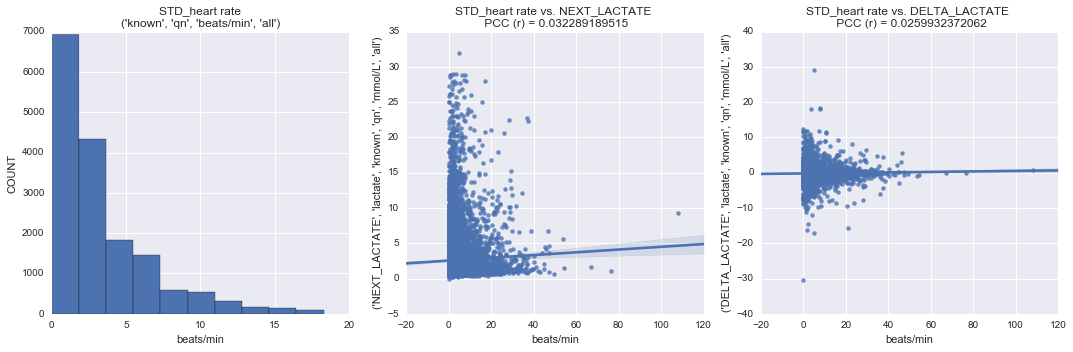

('STD', 'blood pressure systolic', 'known', 'qn', 'mmHg', 'all') 43/86


STD
      blood pressure systolic
                        known
                           qn
                         mmHg
                          all
count              16729.0000
mean                   9.0328
std                    9.2579
min                    0.0000
25%                    2.8284
50%                    6.3640
75%                   12.2967
max                  118.0868

0.0
MODE: 0.0
1280
0.076513838245


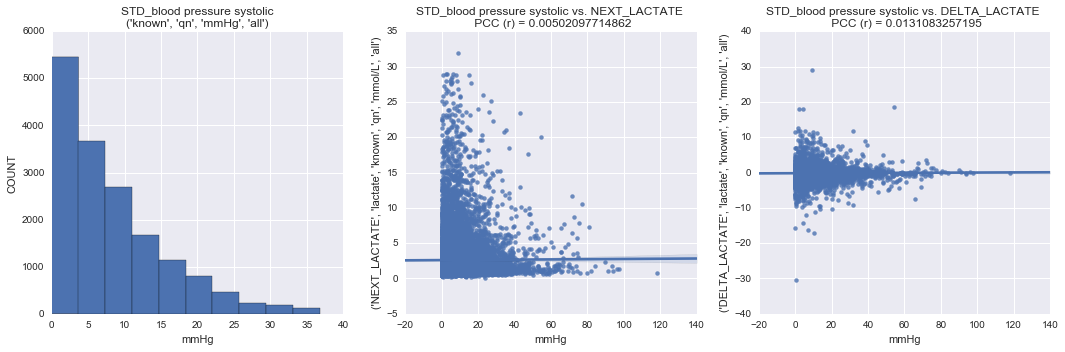

('STD', 'blood pressure diastolic', 'known', 'qn', 'mmHg', 'all') 44/86


STD
      blood pressure diastolic
                         known
                            qn
                          mmHg
                           all
count               16729.0000
mean                    5.0792
std                     5.9635
min                     0.0000
25%                     1.4142
50%                     3.5355
75%                     6.4083
max                    99.7021

0.0
MODE: 0.0
1618
0.0967182736565


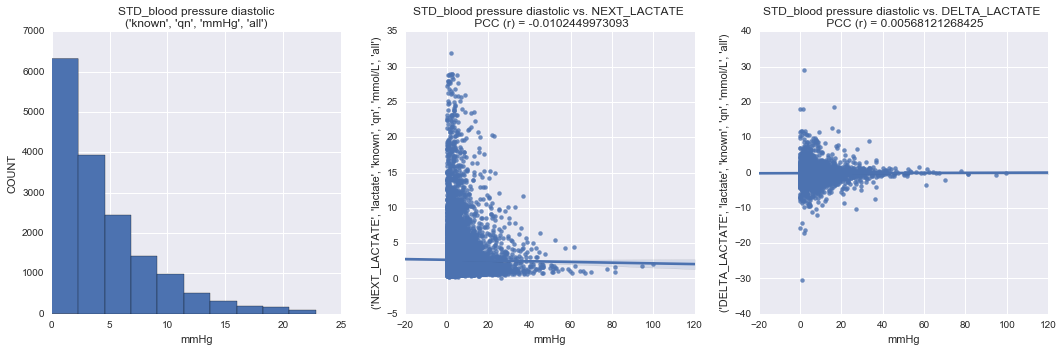

('STD', 'blood pressure mean', 'known', 'qn', 'mmHg', 'all') 45/86


STD
      blood pressure mean
                    known
                       qn
                     mmHg
                      all
count          16729.0000
mean               3.1995
std                8.1375
min                0.0000
25%                0.0000
50%                0.0000
75%                4.0000
max              193.7473

0.0
MODE: 0.0
9644
0.576483950027


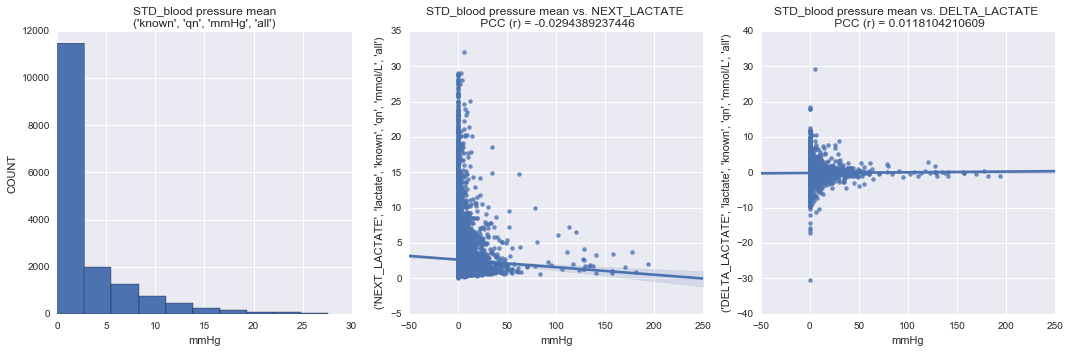

('STD', 'respiratory rate', 'known', 'qn', 'insp/min', 'all') 46/86


STD
      respiratory rate
                 known
                    qn
              insp/min
                   all
count       16729.0000
mean            2.1676
std             2.7984
min             0.0000
25%             0.0000
50%             1.4142
75%             2.8868
max            70.7107

0.0
MODE: 0.0
4738
0.283220754379


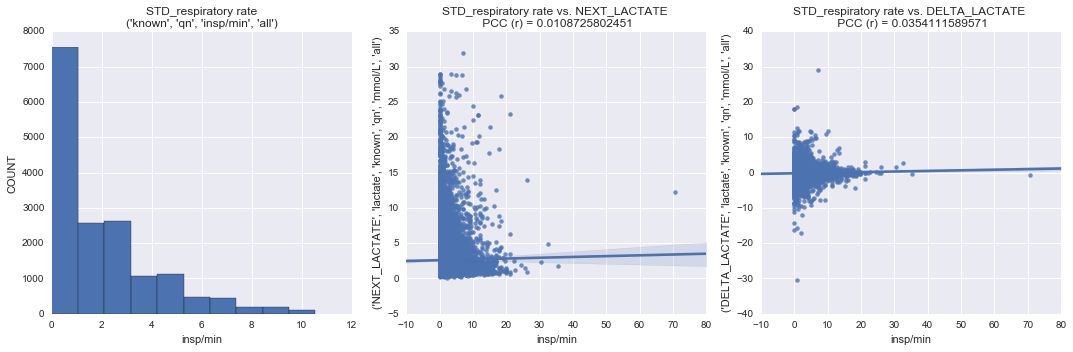

('STD', 'temperature body', 'known', 'qn', 'degF', 'all') 47/86


STD
      temperature body
                 known
                    qn
                  degF
                   all
count       16729.0000
mean            0.0904
std             1.2258
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max            70.8662

0.0
MODE: 0.0
13934
0.83292486102


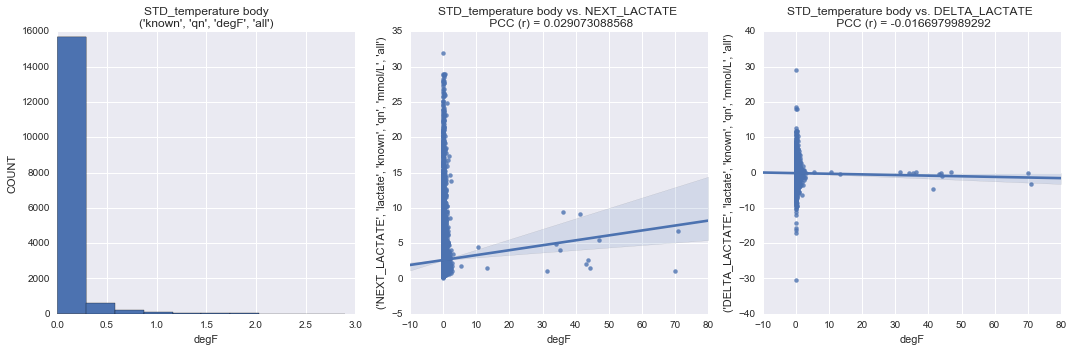

('STD', 'oxygen saturation pulse oximetry', 'known', 'qn', 'percent', 'all') 48/86


STD
      oxygen saturation pulse oximetry
                                 known
                                    qn
                               percent
                                   all
count                       16729.0000
mean                            1.1010
std                             2.4401
min                             0.0000
25%                             0.0000
50%                             0.7071
75%                             1.4142
max                            67.1751

0.0
MODE: 0.0
6651
0.397573076693


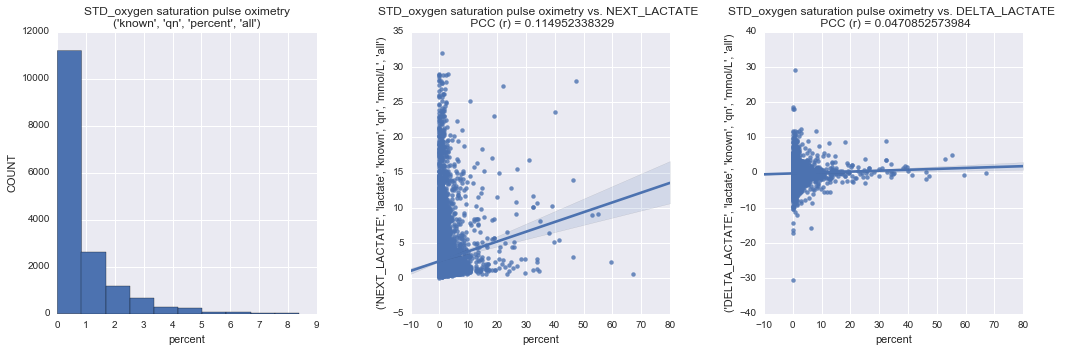

('STD', 'output urine', 'known', 'qn', 'mL', 'all') 49/86


STD
      output urine
             known
                qn
                mL
               all
count   16729.0000
mean       18.2068
std        45.0871
min         0.0000
25%         0.0000
50%         0.0000
75%        14.1421
max      1025.3048

0.0
MODE: 0.0
8631
0.515930420228


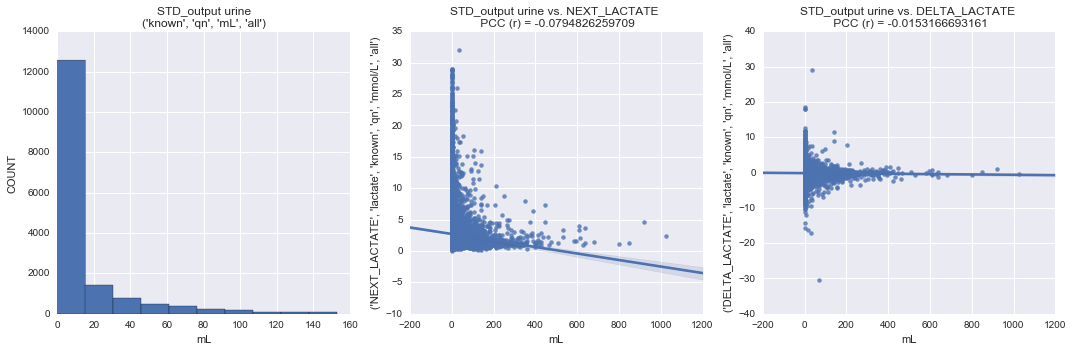

('STD', 'glasgow coma scale motor', 'known', 'ord', 'no_units', 'all') 50/86


STD
      glasgow coma scale motor
                         known
                           ord
                      no_units
                           all
count               16729.0000
mean                    0.0092
std                     0.1507
min                     0.0000
25%                     0.0000
50%                     0.0000
75%                     0.0000
max                     3.5355

0.0
MODE: 0.0
16642
0.994799450057


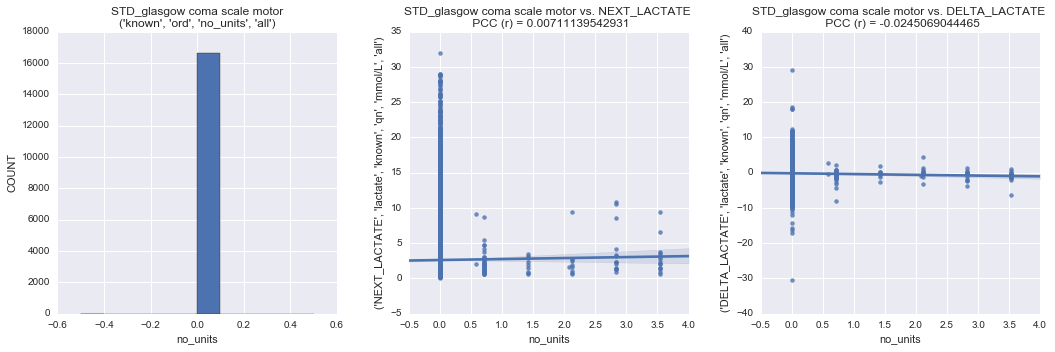

('STD', 'glasgow coma scale eye opening', 'known', 'ord', 'no_units', 'all') 51/86


STD
      glasgow coma scale eye opening
                               known
                                 ord
                            no_units
                                 all
count                     16729.0000
mean                          0.0068
std                           0.0947
min                           0.0000
25%                           0.0000
50%                           0.0000
75%                           0.0000
max                           2.1213

0.0
MODE: 0.0
16628
0.993962579951


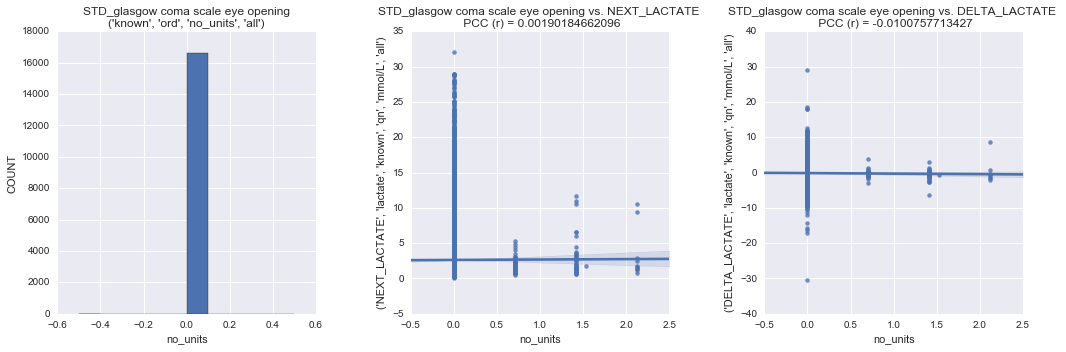

('STD', 'glasgow coma scale verbal', 'known', 'ord', 'no_units', 'all') 52/86


STD
      glasgow coma scale verbal
                          known
                            ord
                       no_units
                            all
count                16729.0000
mean                     0.0024
std                      0.0719
min                      0.0000
25%                      0.0000
50%                      0.0000
75%                      0.0000
max                      2.8284

0.0
MODE: 0.0
16706
0.998625141969


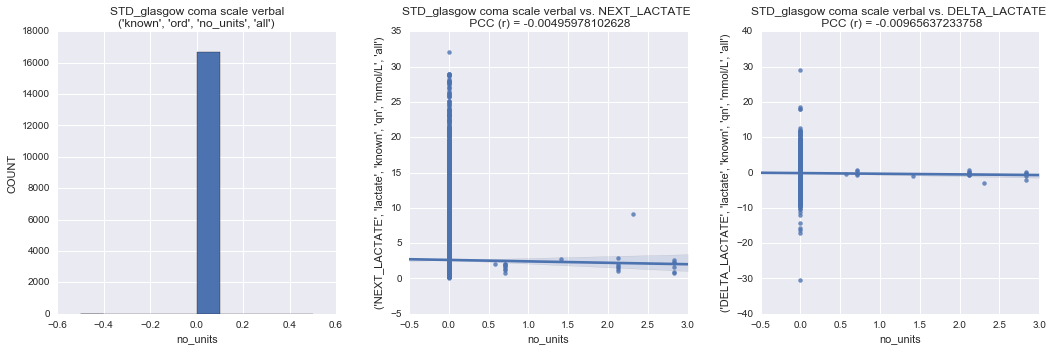

('STD', 'normal saline', 'known', 'qn', 'mL/hr', 'all') 53/86


STD
      normal saline
              known
                 qn
              mL/hr
                all
count    16729.0000
mean         6.9079
std         58.4828
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max       3747.6659

0.0
MODE: 0.0
14581
0.871600215195


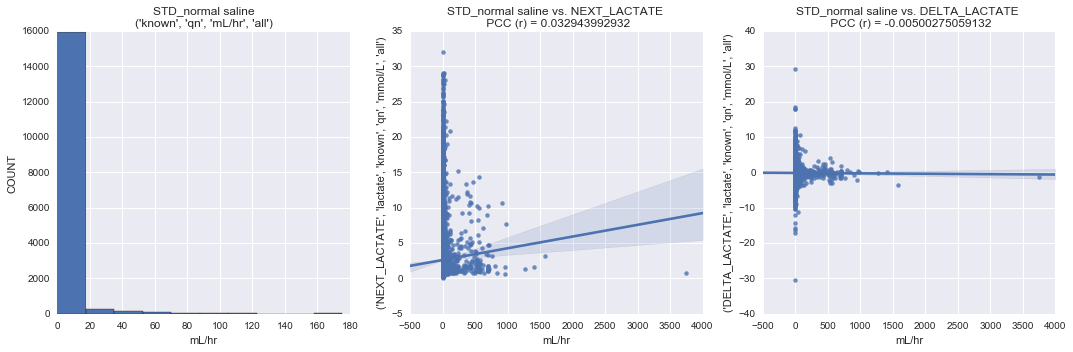

('STD', 'lactated ringers', 'known', 'qn', 'mL', 'all') 54/86


STD
      lactated ringers
                 known
                    qn
                    mL
                   all
count       16729.0000
mean            6.4120
std            62.9448
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max          3585.1546

0.0
MODE: 0.0
16283
0.973339709487


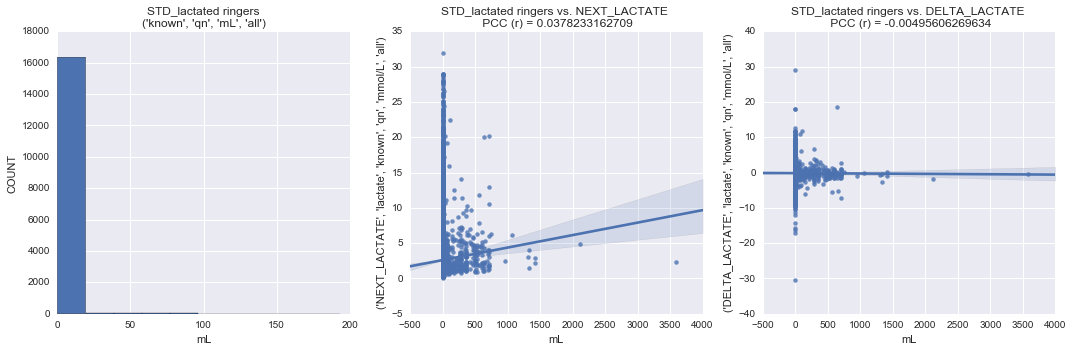

('STD', 'norepinephrine', 'known', 'qn', 'mcg', 'all') 55/86


STD
      norepinephrine
               known
                  qn
                 mcg
                 all
count     16729.0000
mean         20.8082
std         198.7258
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max       13384.1172

0.0
MODE: 0.0
15292
0.914101261283


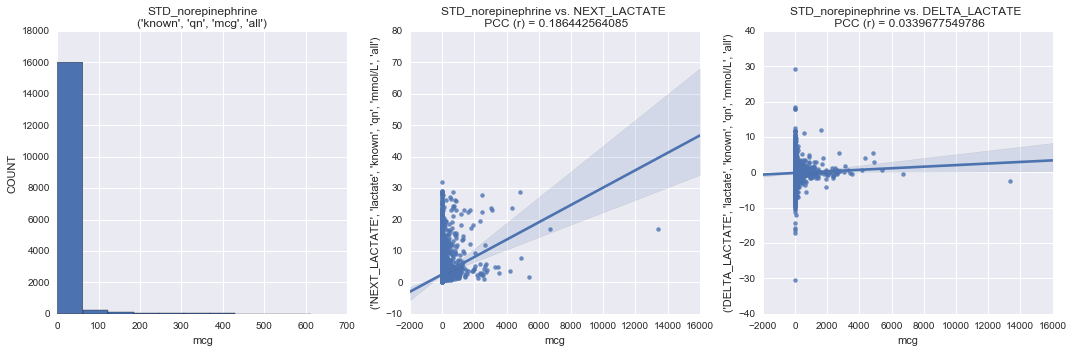

('STD', 'norepinephrine', 'known', 'qn', 'mcg/kg/min', 'all') 56/86


STD
      norepinephrine
               known
                  qn
          mcg/kg/min
                 all
count     16729.0000
mean          0.0022
std           0.0193
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max           0.7881

0.0
MODE: 0.0
15826
0.946021878176


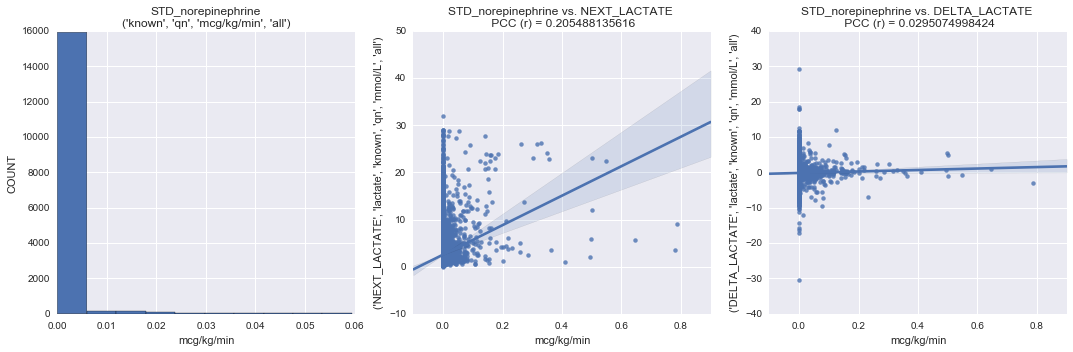

('STD', 'vasopressin', 'known', 'qn', 'units', 'all') 57/86


STD
      vasopressin
            known
               qn
            units
              all
count  16729.0000
mean       0.0097
std        0.1840
min        0.0000
25%        0.0000
50%        0.0000
75%        0.0000
max       12.7279

0.0
MODE: 0.0
16598
0.992169286867


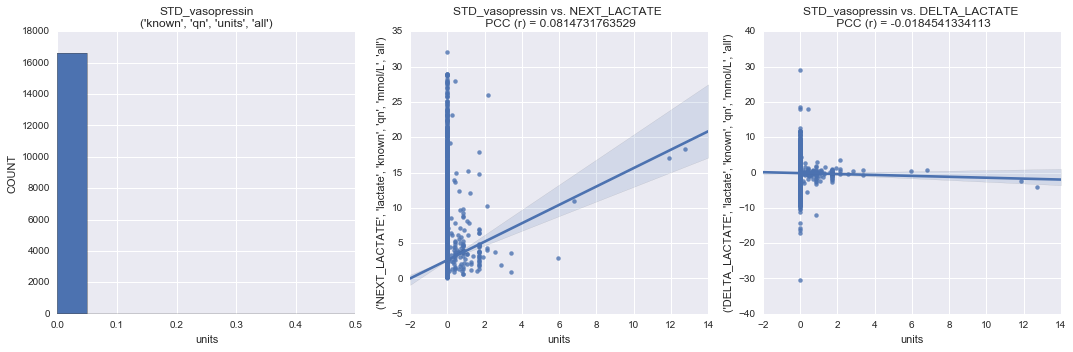

('STD', 'vasopressin', 'known', 'qn', 'units/min', 'all') 58/86


STD
      vasopressin
            known
               qn
        units/min
              all
count  16729.0000
mean       0.0009
std        0.0253
min        0.0000
25%        0.0000
50%        0.0000
75%        0.0000
max        1.3856

0.0
MODE: 0.0
16669
0.996413413832


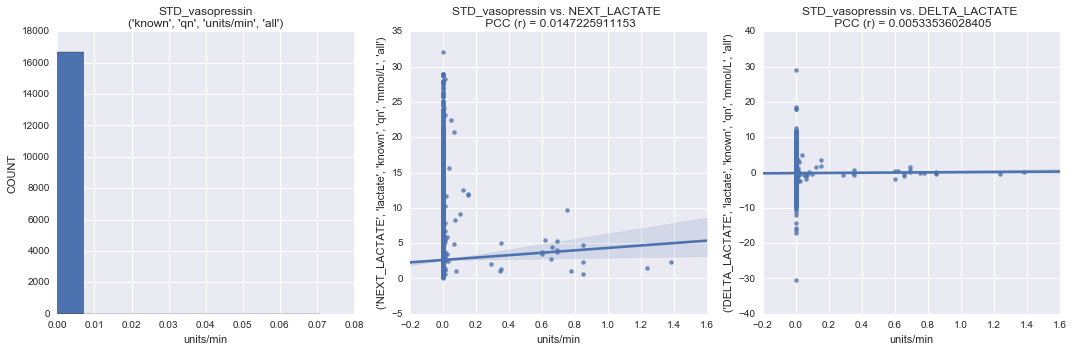

('STD', 'hemoglobin', 'known', 'qn', 'g/dL', 'all') 59/86


STD
       hemoglobin
            known
               qn
             g/dL
              all
count  16729.0000
mean       0.0144
std        0.1427
min        0.0000
25%        0.0000
50%        0.0000
75%        0.0000
max        4.6669

0.0
MODE: 0.0
16397
0.980154223205


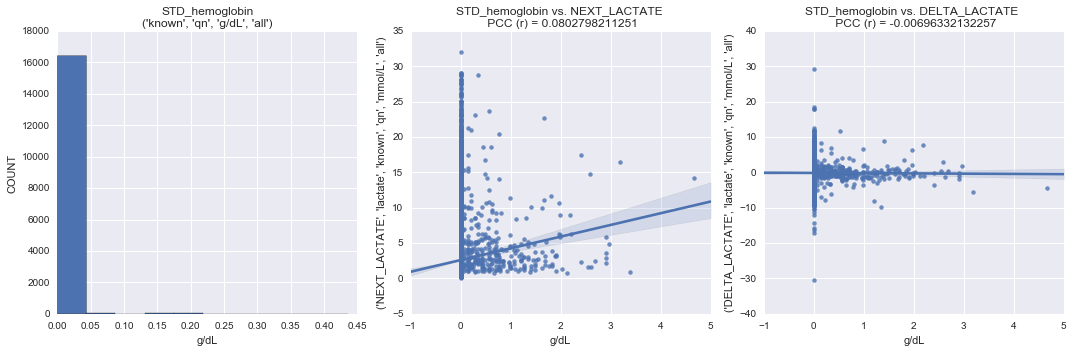

('SUM', 'output urine', 'known', 'qn', 'mL', 'all') 60/86


SUM
      output urine
             known
                qn
                mL
               all
count   16729.0000
mean      136.9425
std       191.2405
min         0.0000
25%        13.0000
50%        80.0000
75%       180.0000
max      6300.0000

0.0
MODE: 0.0
3488
0.208500209218


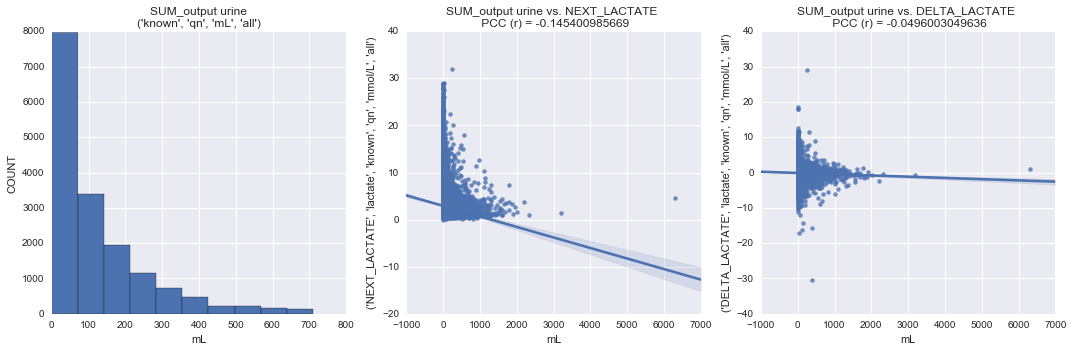

('SUM', 'normal saline', 'known', 'qn', 'mL', 'all') 61/86


SUM
      normal saline
              known
                 qn
                 mL
                all
count    16729.0000
mean        29.0496
std        182.7399
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max       5000.0000

0.0
MODE: 0.0
15979
0.955167672903


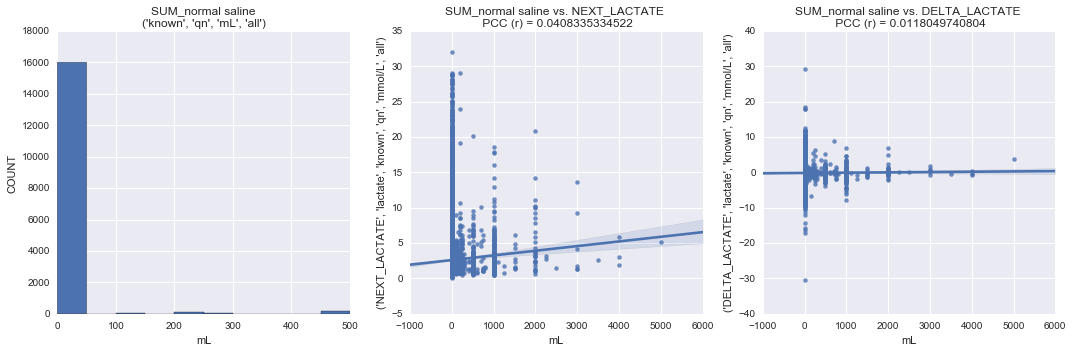

('SUM', 'lactated ringers', 'known', 'qn', 'mL', 'all') 62/86


SUM
      lactated ringers
                 known
                    qn
                    mL
                   all
count       16729.0000
mean           72.6690
std           343.7029
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max         12000.0000

0.0
MODE: 0.0
14551
0.869806922111


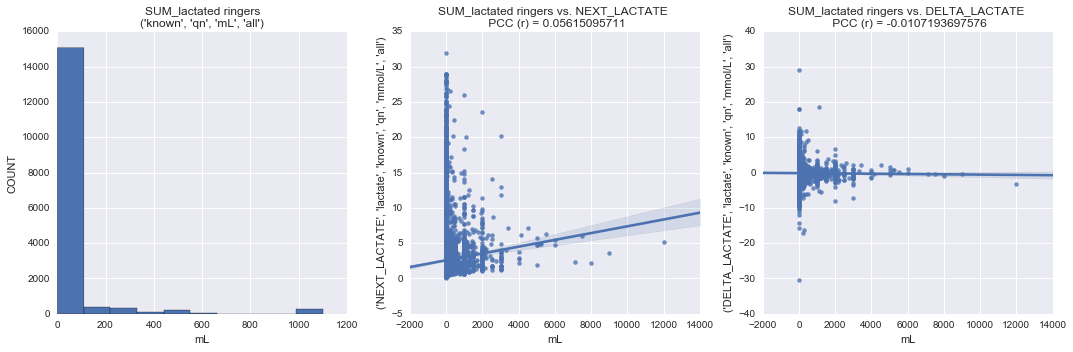

('SUM', 'norepinephrine', 'known', 'qn', 'mcg', 'all') 63/86


SUM
      norepinephrine
               known
                  qn
                 mcg
                 all
count     16729.0000
mean        287.1754
std        1291.3600
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max       31472.0000

0.0
MODE: 0.0
13511
0.807639428537


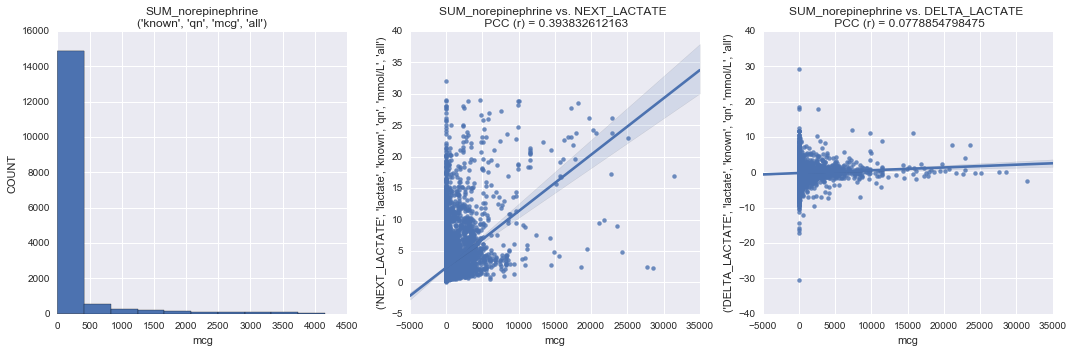

('COUNT', 'heart rate', 'known', 'qn', 'beats/min', 'all') 64/86


COUNT
       heart rate
            known
               qn
        beats/min
              all
count  16729.0000
mean       3.0826
std        6.5055
min        0.0000
25%        2.0000
50%        2.0000
75%        3.0000
max      120.0000

2.0
MODE: 2.0
11515
0.688325662024


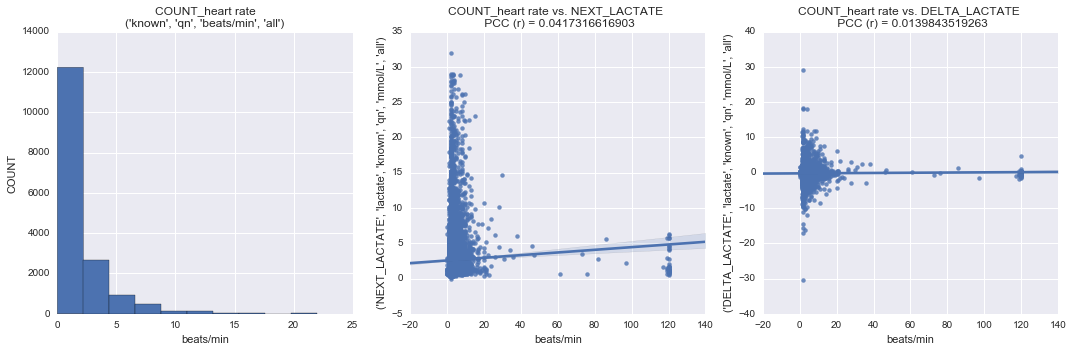

('COUNT', 'blood pressure systolic', 'known', 'qn', 'mmHg', 'all') 65/86


COUNT
      blood pressure systolic
                        known
                           qn
                         mmHg
                          all
count              16729.0000
mean                   3.0423
std                    5.7192
min                    0.0000
25%                    2.0000
50%                    2.0000
75%                    3.0000
max                  120.0000

2.0
MODE: 2.0
10924
0.652997788272


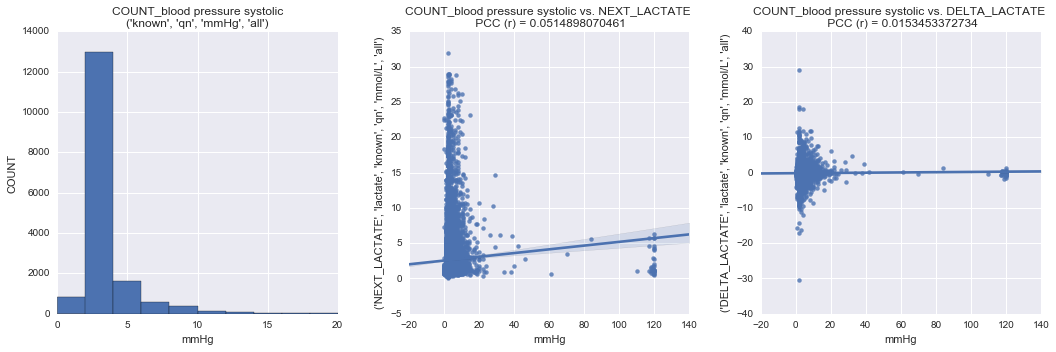

('COUNT', 'blood pressure diastolic', 'known', 'qn', 'mmHg', 'all') 66/86


COUNT
      blood pressure diastolic
                         known
                            qn
                          mmHg
                           all
count               16729.0000
mean                    3.0411
std                     5.7189
min                     0.0000
25%                     2.0000
50%                     2.0000
75%                     3.0000
max                   120.0000

2.0
MODE: 2.0
10922
0.6528782354


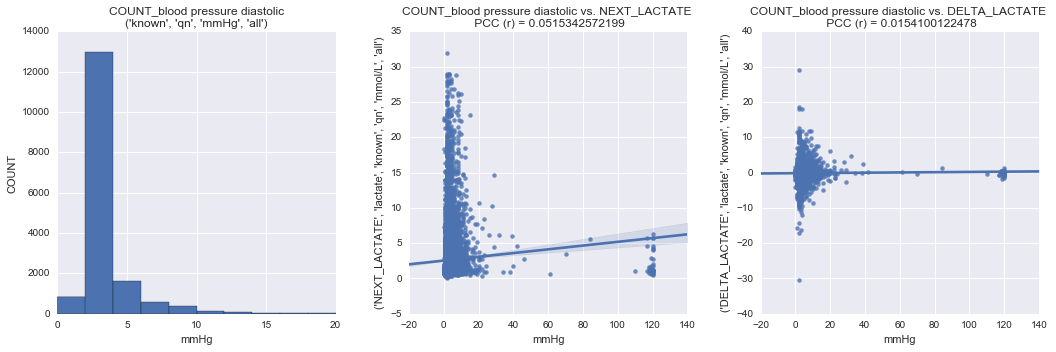

('COUNT', 'blood pressure mean', 'known', 'qn', 'mmHg', 'all') 67/86


COUNT
      blood pressure mean
                    known
                       qn
                     mmHg
                      all
count          16729.0000
mean               1.4914
std                5.7842
min                0.0000
25%                0.0000
50%                0.0000
75%                2.0000
max              120.0000

0.0
MODE: 0.0
9028
0.539661665372


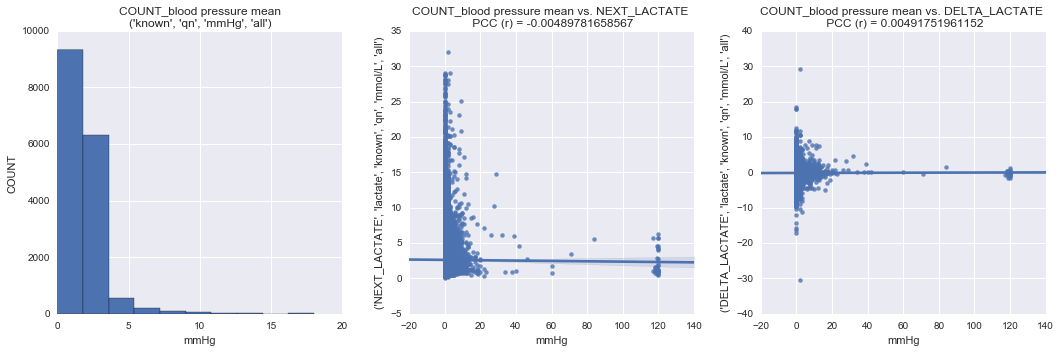

('COUNT', 'respiratory rate', 'known', 'qn', 'insp/min', 'all') 68/86


COUNT
      respiratory rate
                 known
                    qn
              insp/min
                   all
count       16729.0000
mean            3.0063
std             6.4354
min             0.0000
25%             2.0000
50%             2.0000
75%             3.0000
max           120.0000

2.0
MODE: 2.0
11309
0.676011716181


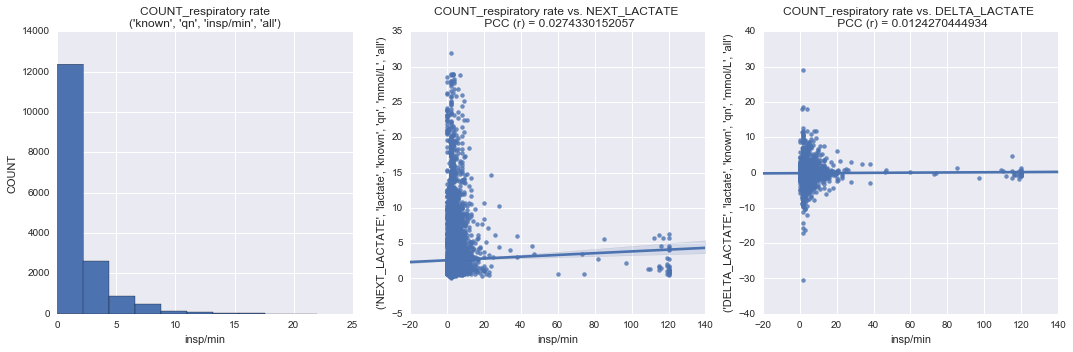

('COUNT', 'temperature body', 'known', 'qn', 'degF', 'all') 69/86


COUNT
      temperature body
                 known
                    qn
                  degF
                   all
count       16729.0000
mean            0.9627
std             1.1303
min             0.0000
25%             0.0000
50%             1.0000
75%             1.0000
max            20.0000

1.0
MODE: 1.0
7133
0.426385318907


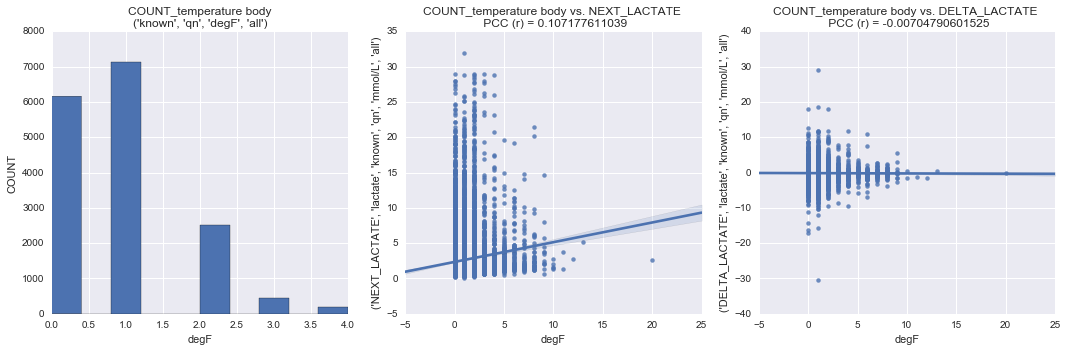

('COUNT', 'oxygen saturation pulse oximetry', 'known', 'qn', 'percent', 'all') 70/86


COUNT
      oxygen saturation pulse oximetry
                                 known
                                    qn
                               percent
                                   all
count                       16729.0000
mean                            2.9927
std                             6.1965
min                             0.0000
25%                             2.0000
50%                             2.0000
75%                             3.0000
max                           120.0000

2.0
MODE: 2.0
10571
0.631896706318


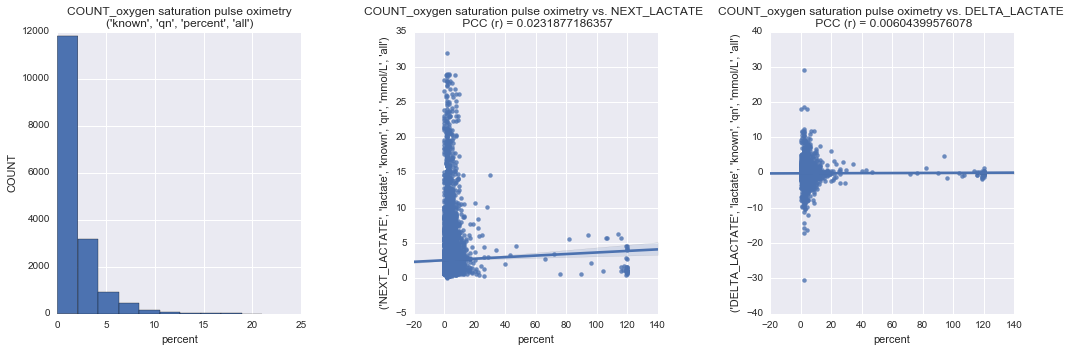

('COUNT', 'weight body', 'known', 'qn', 'kg', 'all') 71/86


COUNT
      weight body
            known
               qn
               kg
              all
count  16729.0000
mean       0.0693
std        0.2859
min        0.0000
25%        0.0000
50%        0.0000
75%        0.0000
max        5.0000

0.0
MODE: 0.0
15696
0.938250941479


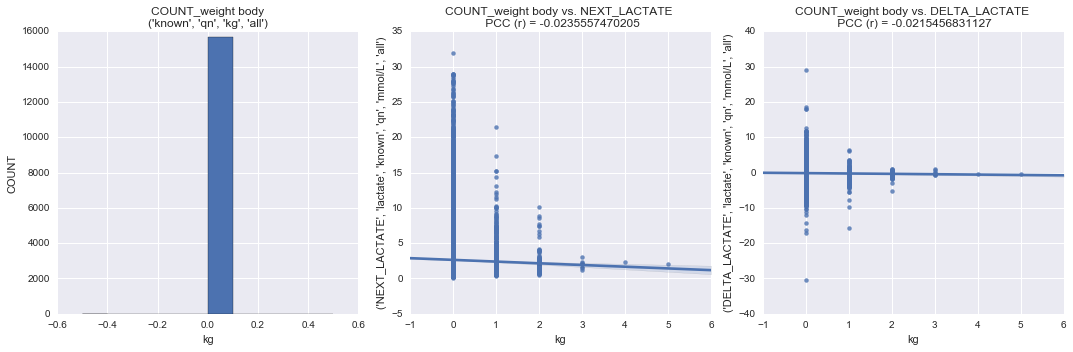

('COUNT', 'output urine', 'known', 'qn', 'mL', 'all') 72/86


COUNT
      output urine
             known
                qn
                mL
               all
count   16729.0000
mean        1.3978
std         0.7956
min         0.0000
25%         1.0000
50%         2.0000
75%         2.0000
max         6.0000

2.0
MODE: 2.0
9224
0.551377846853


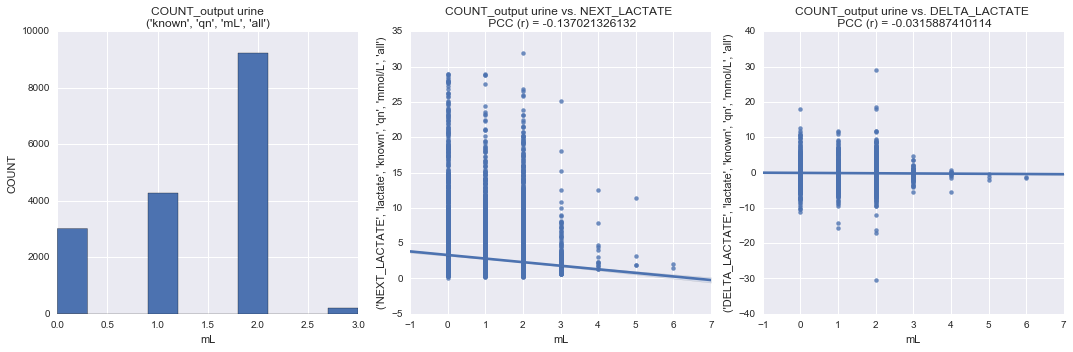

('COUNT', 'glasgow coma scale motor', 'known', 'ord', 'no_units', 'all') 73/86


COUNT
      glasgow coma scale motor
                         known
                           ord
                      no_units
                           all
count               16729.0000
mean                    0.3547
std                     0.5259
min                     0.0000
25%                     0.0000
50%                     0.0000
75%                     1.0000
max                     4.0000

0.0
MODE: 0.0
11188
0.66877876741


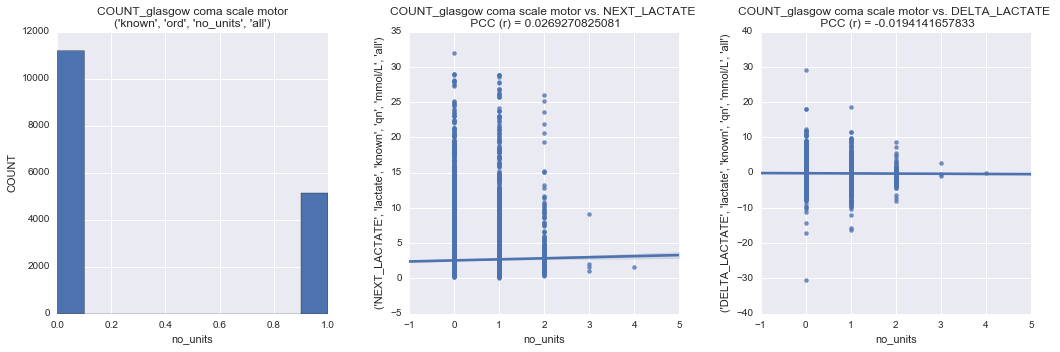

('COUNT', 'glasgow coma scale eye opening', 'known', 'ord', 'no_units', 'all') 74/86


COUNT
      glasgow coma scale eye opening
                               known
                                 ord
                            no_units
                                 all
count                     16729.0000
mean                          0.3581
std                           0.5285
min                           0.0000
25%                           0.0000
50%                           0.0000
75%                           1.0000
max                           4.0000

0.0
MODE: 0.0
11144
0.66614860422


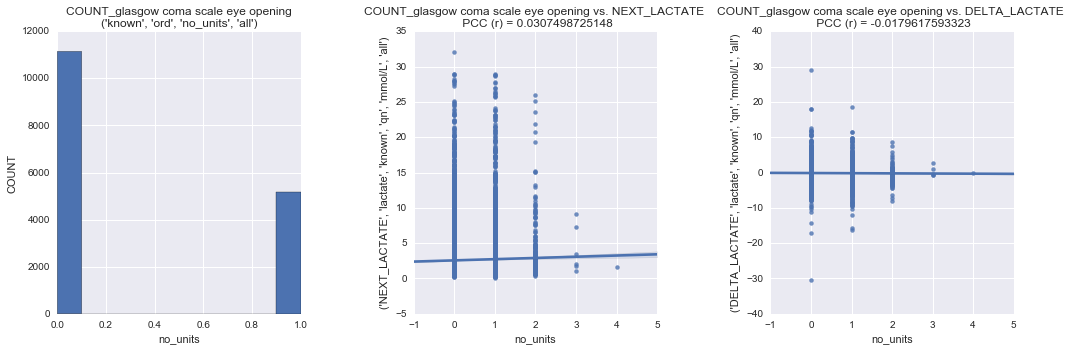

('COUNT', 'glasgow coma scale verbal', 'known', 'ord', 'no_units', 'all') 75/86


COUNT
      glasgow coma scale verbal
                          known
                            ord
                       no_units
                            all
count                16729.0000
mean                     0.3575
std                      0.5287
min                      0.0000
25%                      0.0000
50%                      0.0000
75%                      1.0000
max                      4.0000

0.0
MODE: 0.0
11155
0.666806145018


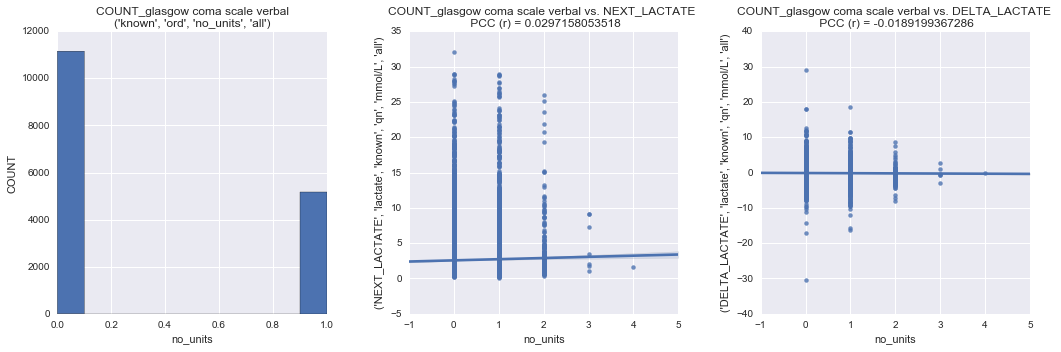

('COUNT', 'normal saline', 'known', 'qn', 'mL', 'all') 76/86


COUNT
      normal saline
              known
                 qn
                 mL
                all
count    16729.0000
mean         0.0525
std          0.2637
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          5.0000

0.0
MODE: 0.0
15978
0.955107896467


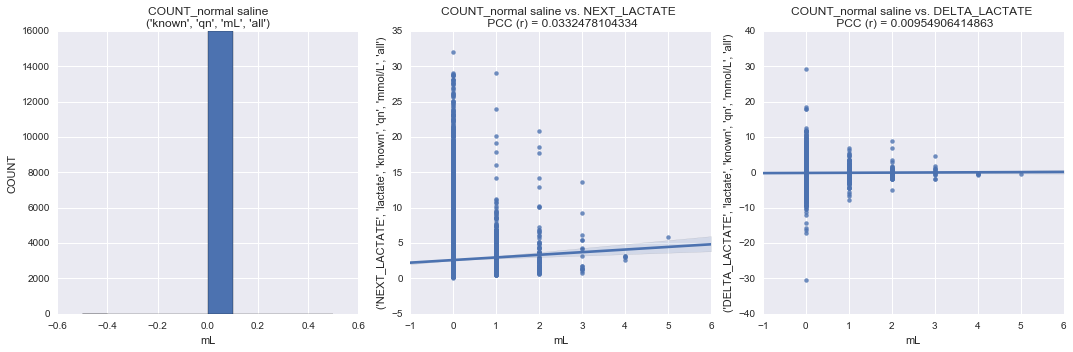

('COUNT', 'normal saline', 'known', 'qn', 'mL/hr', 'all') 77/86


COUNT
      normal saline
              known
                 qn
              mL/hr
                all
count    16729.0000
mean         0.5278
std          1.2359
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max         15.0000

0.0
MODE: 0.0
12800
0.76513838245


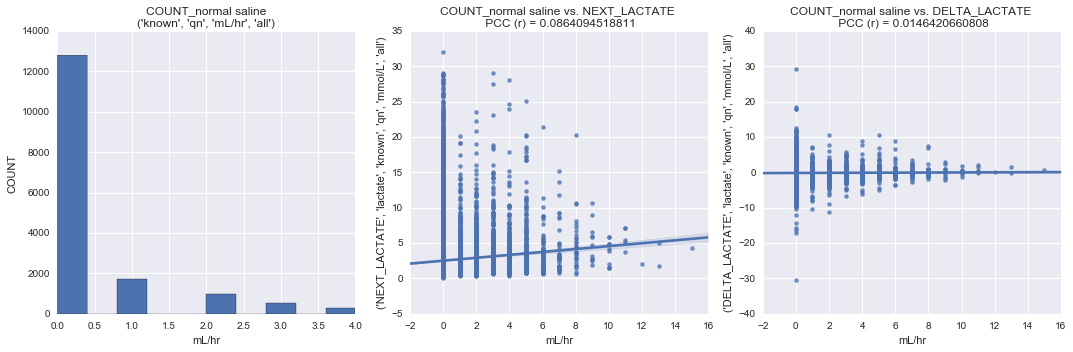

('COUNT', 'lactated ringers', 'known', 'qn', 'mL', 'all') 78/86


COUNT
      lactated ringers
                 known
                    qn
                    mL
                   all
count       16729.0000
mean            0.2267
std             0.6299
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max            10.0000

0.0
MODE: 0.0
14482
0.865682348018


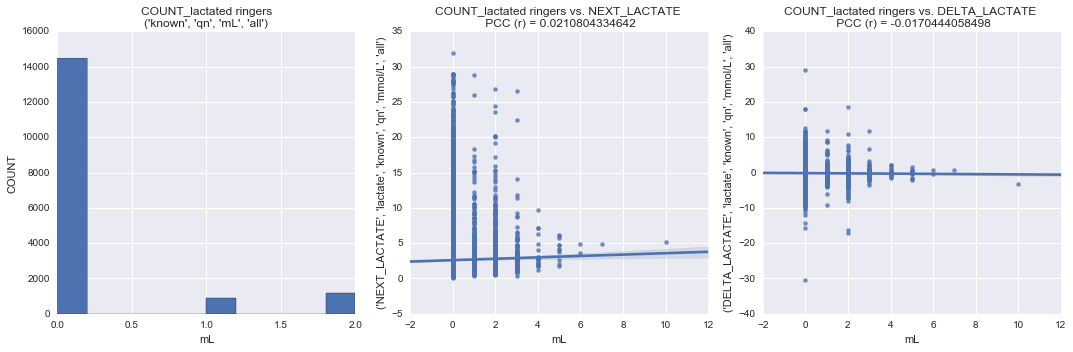

('COUNT', 'norepinephrine', 'known', 'qn', 'mcg', 'all') 79/86


COUNT
      norepinephrine
               known
                  qn
                 mcg
                 all
count     16729.0000
mean          0.3727
std           0.8308
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max          12.0000

0.0
MODE: 0.0
13351
0.798075198757


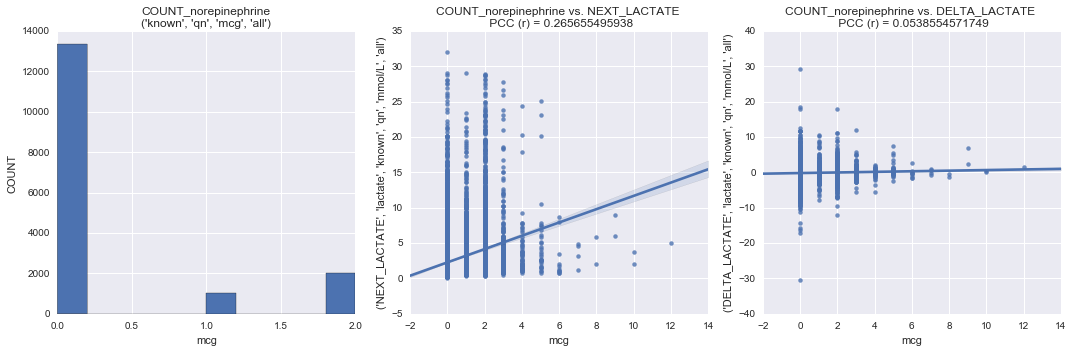

('COUNT', 'norepinephrine', 'known', 'qn', 'mcg/kg/min', 'all') 80/86


COUNT
      norepinephrine
               known
                  qn
          mcg/kg/min
                 all
count     16729.0000
mean          0.4291
std           1.3470
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max          20.0000

0.0
MODE: 0.0
14482
0.865682348018


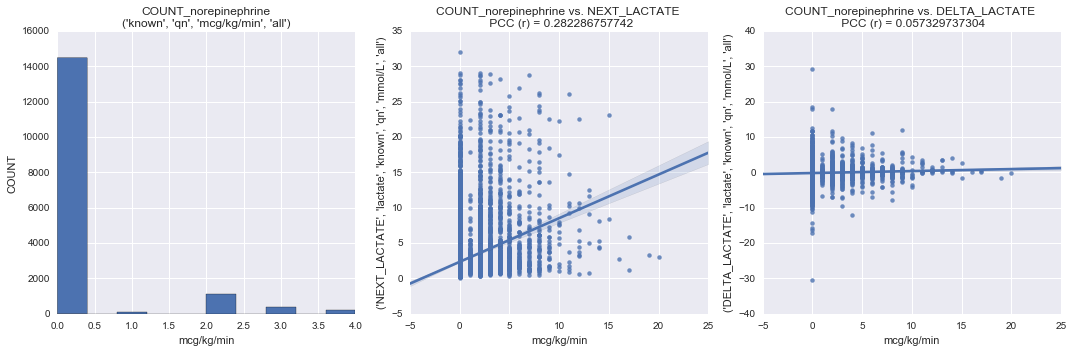

('COUNT', 'vasopressin', 'known', 'qn', 'units', 'all') 81/86


COUNT
      vasopressin
            known
               qn
            units
              all
count  16729.0000
mean       0.0986
std        0.4327
min        0.0000
25%        0.0000
50%        0.0000
75%        0.0000
max        4.0000

0.0
MODE: 0.0
15855
0.947755394823


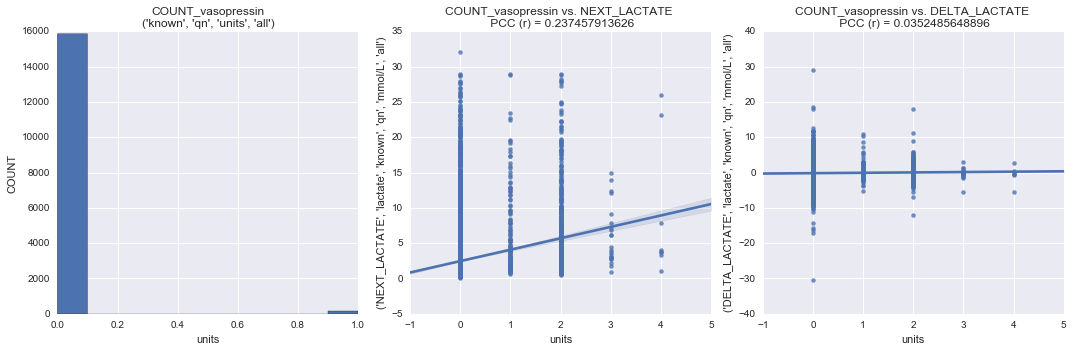

('COUNT', 'vasopressin', 'known', 'qn', 'units/min', 'all') 82/86


COUNT
      vasopressin
            known
               qn
        units/min
              all
count  16729.0000
mean       0.1791
std        0.8378
min        0.0000
25%        0.0000
50%        0.0000
75%        0.0000
max       17.0000

0.0
MODE: 0.0
15731
0.940343116743


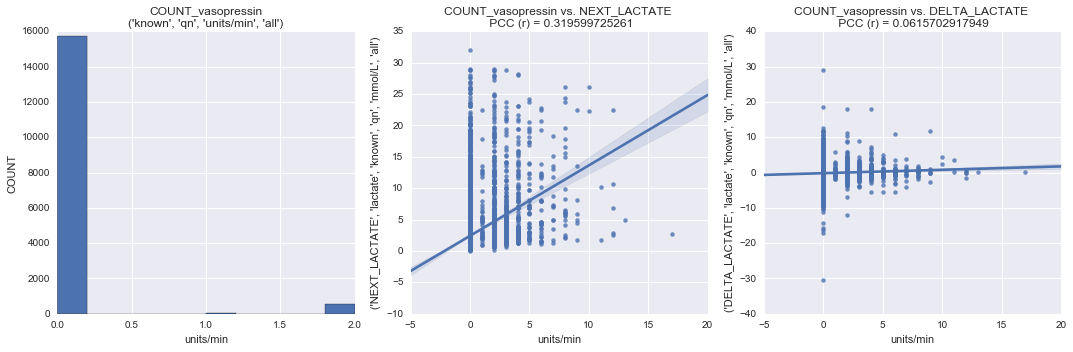

('COUNT', 'hemoglobin', 'known', 'qn', 'g/dL', 'all') 83/86


COUNT
       hemoglobin
            known
               qn
             g/dL
              all
count  16729.0000
mean       0.2340
std        0.5056
min        0.0000
25%        0.0000
50%        0.0000
75%        0.0000
max        5.0000

0.0
MODE: 0.0
13298
0.794907047642


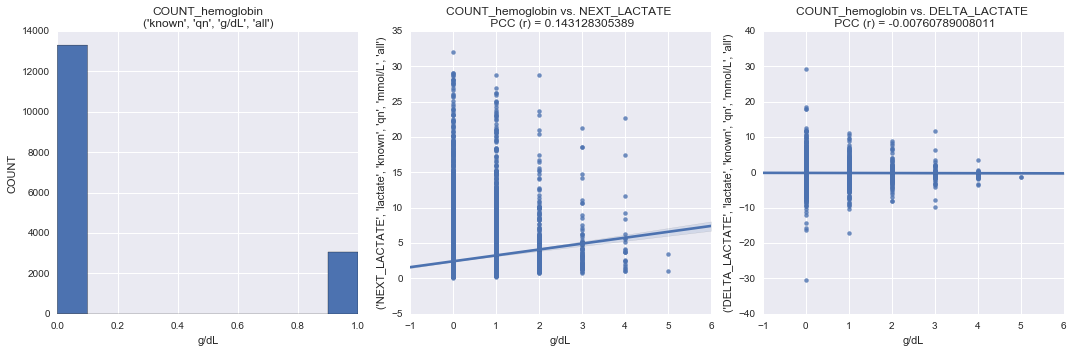

('COUNT', 'lactate', 'known', 'qn', 'mmol/L', 'all') 84/86


COUNT
          lactate
            known
               qn
           mmol/L
              all
count  16729.0000
mean       0.2055
std        0.4668
min        0.0000
25%        0.0000
50%        0.0000
75%        0.0000
max        4.0000

0.0
MODE: 0.0
13710
0.819534939327


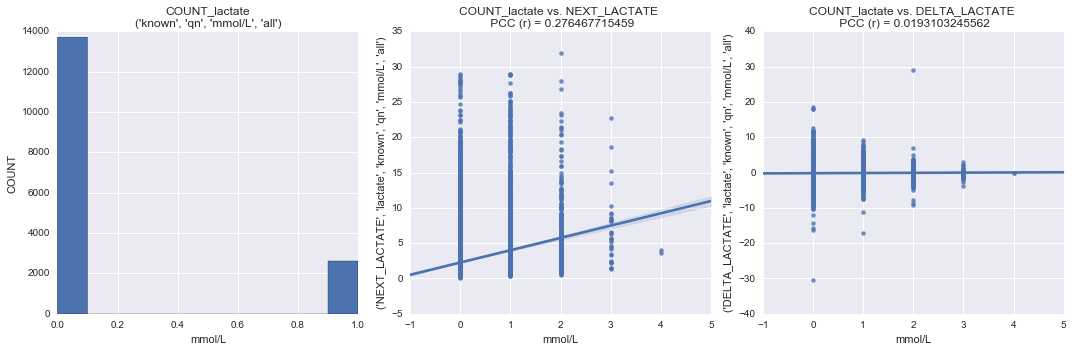

('COUNT_NOMINAL', 'output urine', 'unknown', 'nom', 'no_units', '3686(ml)_Voiding qs') 85/86


COUNT_NOMINAL
             output urine
                  unknown
                      nom
                 no_units
      3686(ml)_Voiding qs
count          16729.0000
mean               0.0000
std                0.0000
min                0.0000
25%                0.0000
50%                0.0000
75%                0.0000
max                0.0000

0.0
MODE: 0.0
16729
1.0


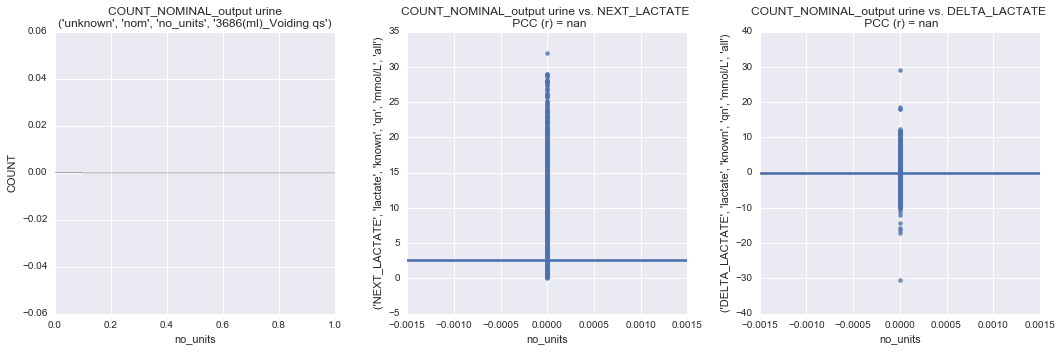

In [225]:
df_corr = viz_per_feature(df_features_trimmed, df_labels_trimmed)

# Models

In [208]:
df_features = utils.read_and_reconstruct('data/data_sets.h5','simple/train/features')
df_labels = utils.read_and_reconstruct('data/data_sets.h5','simple/train/labels')

In [211]:
y_next = df_labels.loc[df_features.index,['NEXT_LACTATE']].iloc[:,0].dropna()
y_delta = df_labels.loc[df_features.index,['DELTA_LACTATE']].iloc[:,0].dropna()
X_next = df_features.loc[y_next.index]
X_delta = df_features.loc[y_delta.index]

In [212]:
print "Next Lactate:",X_next.shape,y_next.shape
print "Delta Lactate:",X_delta.shape,y_delta.shape

Next Lactate: (16729, 86) (16729L,)
Delta Lactate: (15691, 86) (15691L,)


## Linear Regression

In [215]:
scaler = StandardScaler()
lin_reg = LinearRegression()
pipeline = Pipeline([
        ('scaler',StandardScaler()),
        ('model',lin_reg)
    ])

In [216]:
run_crossval(pipeline,X_next,y_next)

Cross Validation, K-Fold
R^2: 0.773057636287, 0.083314871383
RMSE: 1.29910855324, 0.167587940658

Cross Validation, ShuffleSplit
R^2: 0.799271649182, 0.0215436494812
RMSE: 1.35788841104, 0.103439574679


In [217]:
run_crossval(pipeline,X_delta,y_delta)

Cross Validation, K-Fold
R^2: 0.0539389260123, 0.0319653098264
RMSE: 1.28414816332, 0.178162887423

Cross Validation, ShuffleSplit
R^2: 0.0739890743487, 0.0204337204089
RMSE: 1.38063343922, 0.11862127706


In [218]:
X_next_no_lac = X_next.loc[:,X_next.columns.get_level_values(column_names.COMPONENT) != data_dict.components.LACTATE]
X_delta_no_lac = X_delta.loc[:,X_next.columns.get_level_values(column_names.COMPONENT) != data_dict.components.LACTATE]

In [219]:
run_crossval(pipeline,X_next_no_lac,y_next)

Cross Validation, K-Fold
R^2: 0.220092272613, 0.123801158447
RMSE: 2.48489089565, 0.408003904242

Cross Validation, ShuffleSplit
R^2: 0.320248013643, 0.0223699743792
RMSE: 2.45069379791, 0.127841622889


In [220]:
run_crossval(pipeline,X_delta_no_lac,y_delta)

Cross Validation, K-Fold
R^2: 0.0120756890072, 0.00952860463192
RMSE: 1.31370284209, 0.190313326557

Cross Validation, ShuffleSplit
R^2: 0.00745737272032, 0.00872082065535
RMSE: 1.30202437158, 0.0962673421532


In [221]:
pipeline.fit(X_next_no_lac,y_next)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [223]:
pd.Series(lin_reg.coef_,index=X_next_no_lac.columns).sort_values().to_frame()

0
feature  component                        status variable_type units      description          
COUNT    blood pressure systolic          known  qn            mmHg       all         -3.105110
         respiratory rate                 known  qn            insp/min   all         -1.580753
MEAN_ORD glasgow coma scale motor         known  ord           no_units   all         -1.188833
MEAN_QN  weight body                      known  qn            kg         all         -0.911510
COUNT    output urine                     known  qn            mL         all         -0.392370
         glasgow coma scale motor         known  ord           no_units   all         -0.367290
         blood pressure mean              known  qn            mmHg       all         -0.341068
MEAN_QN  oxygen saturation pulse oximetry known  qn            percent    all         -0.331118
LAST     glasgow coma scale eye opening   known  ord           no_units   all         -0.316502
MEAN_QN  output urine                     known  qn            mL         all         -0.280886
COUNT    oxygen saturation pulse oximetry known  qn            percent    all         -0.240875
MEAN_QN  hemoglobin                       known  qn            g/dL       all         -0.207680
MEAN_ORD glasgow coma scale verbal        known  ord           no_units   all         -0.184077
MEAN_QN  normal saline                    known  qn            mL         all         -0.164936
LAST     temperature body                 known  qn            degF       all         -0.144873
MEAN_QN  blood pressure systolic          known  qn            mmHg       all         -0.142894
LAST     vasopressin                      known  qn            units      all         -0.121824
MEAN_QN  temperature body                 known  qn            degF       all         -0.113729
LAST     norepinephrine                   known  qn            mcg        all         -0.112473
         output urine                     known  qn            mL         all         -0.095175
STD      vasopressin                      known  qn            units      all         -0.079344
LAST     oxygen saturation pulse oximetry known  qn            percent    all         -0.059530
STD      vasopressin                      known  qn            units/min  all         -0.051607
LAST     blood pressure systolic          known  qn            mmHg       all         -0.050615
MEAN_QN  vasopressin                      known  qn            units/min  all         -0.048204
COUNT    norepinephrine                   known  qn            mcg/kg/min all         -0.047406
STD      blood pressure diastolic         known  qn            mmHg       all         -0.036716
COUNT    weight body                      known  qn            kg         all         -0.030373
         lactated ringers                 known  qn            mL         all         -0.028441
LAST     vasopressin                      known  qn            units/min  all         -0.027732
...                                                                                         ...
         normal saline                    known  qn            mL/hr      all          0.019512
COUNT    glasgow coma scale verbal        known  ord           no_units   all          0.029329
STD      hemoglobin                       known  qn            g/dL       all          0.032096
COUNT    vasopressin                      known  qn            units      all          0.038508
         normal saline                    known  qn            mL         all          0.051462
LAST     respiratory rate                 known  qn            insp/min   all          0.062074
STD      norepinephrine                   known  qn            mcg/kg/min all          0.070309
SUM      lactated ringers                 known  qn            mL         all          0.074682
COUNT    temperature body                 known  qn            degF       all          0.085281
LAST     heart rate                       known  qn           

## Ridge Regression

In [226]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

In [228]:
scaler = StandardScaler()
ridge_cv = RidgeCV()
pipeline = Pipeline([
        ('scaler',StandardScaler()),
        ('model',ridge_cv)
    ])

In [229]:
pipeline.fit(X_next,y_next)
print ridge_cv.alpha_
print ridge_cv.coef_

10.0
[  5.89099806e-02  -9.92223534e-03  -4.50839729e-02   2.72351399e-02
   2.41028674e-02  -9.57783753e-02  -6.19733584e-02   1.71775936e-01
   3.68597347e-03  -1.14262125e-01  -2.72265222e-03   7.04494274e-02
   4.67391873e-02  -5.77364601e-02  -1.04465626e-02   4.76642476e-02
   1.54992467e-01  -1.41756516e-01  -2.36077658e-01   3.38146676e-02
  -3.25569084e-02   2.81827604e-03  -7.77978068e-02   4.67604309e-03
  -1.22186853e-03   7.15699199e-02   3.27914486e-02  -3.76286624e-02
  -1.73202623e-01  -5.91505320e-02   1.36327777e-01  -1.74518847e-02
   6.86107588e-02   1.02672478e-01   4.51657639e-02  -7.01480901e-02
  -2.75113855e-02   1.26936212e-01   1.03695009e-02  -6.66183987e-02
  -1.73794253e-01   2.56615671e+00   6.77404454e-03  -1.14991905e-02
   2.32621917e-02  -7.63140303e-03   2.78071325e-02  -3.35734109e-02
   1.32850245e-02   3.41427879e-03  -3.10589680e-02   1.78554245e-02
  -1.94373836e-02  -2.25566462e-02  -2.11384754e-03   1.72762591e-02
   4.34559147e-03  -5.1677428

In [230]:
pipeline.fit(X_delta,y_delta)
print ridge_cv.alpha_
print ridge_cv.coef_

10.0
[  2.70207778e-02  -2.16517016e-02  -5.68137583e-02   3.66866120e-02
   9.28861292e-02  -7.58228692e-02  -5.03844181e-02   1.08408419e-01
  -4.61294482e-02  -1.10539004e-01   3.19279901e-03   7.13354054e-02
  -1.04821801e-01   1.42505171e-02   1.22588850e-03   4.54574595e-02
   1.73603745e-01  -2.49238562e-01  -2.51642635e-01   2.87841257e-01
   8.28936395e-02   7.19511211e-03  -2.67275736e-02   1.16496482e-02
  -2.28060188e-02   3.51223736e-03   3.41205978e-02  -5.83285483e-02
  -9.44251919e-02  -7.03550683e-02   1.50342276e-01  -1.96013662e-01
  -9.47816269e-02   9.02654478e-02   3.36746940e-02  -7.24764357e-02
   9.82679482e-02   4.71990654e-02  -1.38198185e-03  -6.79300484e-02
  -2.09869743e-01  -1.10015419e-01   1.48455381e-02   9.95348503e-03
  -1.87863269e-02   1.14193190e-02   2.49627795e-02  -2.58469718e-02
   1.49380249e-03   1.68930265e-02  -3.14381798e-02   2.16375102e-02
  -7.53057092e-03  -2.92293114e-02  -8.30687690e-03   2.44962729e-02
  -1.08654567e-02  -5.9144850

In [231]:
pipeline.fit(X_next_no_lac,y_next)
print ridge_cv.alpha_
print ridge_cv.coef_

10.0
[  1.39762433e-01  -1.42504658e-01  -1.03660350e-02   1.44825034e-02
   1.51219664e-01  -1.15636192e-01  -3.28835463e-01  -6.29367680e-01
  -2.78053273e-01  -1.62678722e-01   1.11000133e-02   9.95531931e-02
   2.63458309e-01  -8.62132517e-03   1.29225582e-01  -4.61511819e-02
  -1.93105250e-01  -8.82256426e-01   1.53616781e-01  -1.61321849e-01
   8.59567168e-02  -5.05951245e-02  -2.34723209e-02  -1.28880463e-02
   6.39428899e-02  -1.43511367e-01  -6.28699609e-02   5.85494199e-01
  -9.70463721e-02   5.16268466e-01  -1.66589496e-01   1.73576343e-01
   2.45955469e-01   1.93051544e-02   4.73457659e-03  -1.09859085e-01
   3.88779102e-01  -6.63853723e-02  -2.91234438e-02   2.14637511e-01
  -2.47741036e-02  -1.10275746e-02  -3.61095463e-02  -2.50575698e-02
   1.02212535e-02   1.58414093e-02  -1.11022098e-02  -1.37123111e-02
  -2.42316882e-03   1.88555438e-02  -1.94086162e-02  -1.40909820e-02
   1.54507865e-02   5.74648273e-03   7.04090571e-02  -7.66135489e-02
  -5.19461074e-02   3.2273746

In [232]:
pipeline.fit(X_delta_no_lac,y_delta)
print ridge_cv.alpha_
print ridge_cv.coef_

10.0
[  1.78681428e-02  -8.17587514e-04  -6.52602414e-02   3.89260571e-02
   7.93766739e-02  -6.93128139e-02  -1.52843274e-02   2.06479091e-01
  -3.10275407e-03  -1.02236699e-01  -2.84793552e-04   6.32027986e-02
  -1.40443480e-01   1.25127157e-02  -1.37938810e-02   6.05331391e-02
   2.11677325e-01  -1.50251669e-01   2.68356935e-01   9.79368026e-02
  -5.45663664e-03  -3.13908506e-02   1.85891265e-02  -2.24445990e-02
   2.35441223e-03   5.35606767e-02  -5.29567464e-02  -1.85857610e-01
  -6.40390930e-02   8.60740704e-02  -1.74691624e-01  -1.06901405e-01
   6.92859847e-02   3.82433153e-02  -7.75808381e-02   1.07082456e-01
   6.79889215e-03   7.17148572e-03  -7.41370178e-02  -2.49666588e-01
   1.92077160e-02   1.17913005e-02  -1.22621004e-02   1.46146914e-02
   2.75543383e-02  -3.13770650e-02   6.86809815e-03   2.01833917e-02
  -3.26956213e-02   1.98638147e-02  -6.91357742e-03  -3.01591680e-02
  -9.94738469e-03   2.73656430e-02  -2.08415960e-02  -5.67374670e-02
   7.10343642e-03  -5.3159585

In [233]:
ridge = Ridge()
pipeline = Pipeline([
        ('scaler',StandardScaler()),
        ('model',ridge)
    ])

run_crossval(pipeline, X_next_no_lac,y_next)

Cross Validation, K-Fold
R^2: 0.220168271699, 0.123820997139
RMSE: 2.4847826922, 0.408088554043

Cross Validation, ShuffleSplit
R^2: 0.325304724223, 0.0484002680757
RMSE: 2.53453244507, 0.147702209159


## Elastic Net

In [234]:
from sklearn.linear_model import ElasticNetCV,ElasticNet

In [235]:
# more values close to 1 (i.e. Lasso) and less close to 0 (i.e. Ridge); more L1
elastic_net_cv = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1])
pipeline = Pipeline([
        ('scaler',StandardScaler()),
        ('model',elastic_net_cv)
    ])

In [237]:
pipeline.fit(X_next_no_lac,y_next)
print elastic_net_cv.l1_ratio_ 
pd.Series(elastic_net_cv.coef_,index=X_next_no_lac.columns).sort_values().to_frame()

0.5


0
feature  component                        status variable_type units      description          
COUNT    output urine                     known  qn            mL         all         -0.291666
MEAN_QN  oxygen saturation pulse oximetry known  qn            percent    all         -0.277943
MEAN_ORD glasgow coma scale motor         known  ord           no_units   all         -0.262318
MEAN_QN  blood pressure systolic          known  qn            mmHg       all         -0.135262
         temperature body                 known  qn            degF       all         -0.132083
LAST     output urine                     known  qn            mL         all         -0.107093
MEAN_QN  output urine                     known  qn            mL         all         -0.103257
LAST     temperature body                 known  qn            degF       all         -0.103106
         oxygen saturation pulse oximetry known  qn            percent    all         -0.102127
         blood pressure systolic          known  qn            mmHg       all         -0.056997
         glasgow coma scale motor         known  ord           no_units   all         -0.043850
MEAN_ORD glasgow coma scale eye opening   known  ord           no_units   all         -0.038971
MEAN_QN  vasopressin                      known  qn            units/min  all         -0.032938
STD      vasopressin                      known  qn            units/min  all         -0.027390
MEAN_QN  weight body                      known  qn            kg         all         -0.020266
STD      vasopressin                      known  qn            units      all         -0.018332
         blood pressure mean              known  qn            mmHg       all         -0.018142
MEAN_QN  blood pressure diastolic         known  qn            mmHg       all         -0.009997
LAST     blood pressure diastolic         known  qn            mmHg       all         -0.009105
COUNT    weight body                      known  qn            kg         all         -0.003975
STD      blood pressure systolic          known  qn            mmHg       all         -0.000000
         normal saline                    known  qn            mL/hr      all          0.000000
         glasgow coma scale verbal        known  ord           no_units   all         -0.000000
         oxygen saturation pulse oximetry known  qn            percent    all          0.000000
         temperature body                 known  qn            degF       all          0.000000
         respiratory rate                 known  qn            insp/min   all          0.000000
         lactated ringers                 known  qn            mL         all          0.000000
         output urine                     known  qn            mL         all          0.000000
COUNT    heart rate                       known  qn            beats/min  all          0.000000
SUM      output urine                     known  qn            mL         all         -0.000000
...                                                                                         ...
LAST     vasopressin                      known  qn            units/min  all         -0.000000
COUNT    norepinephrine                   known  qn            mcg        all          0.000252
         blood pressure systolic          known  qn            mmHg       all          0.000905
STD      glasgow coma scale motor         known  ord           no_units   all          0.004019
         glasgow coma scale eye opening   known  ord           no_units   all          0.004549
COUNT    glasgow coma scale eye opening   known  ord           no_units   all          0.004551
         blood pressure diastolic         known  qn            mmHg       all          0.004697
SUM      normal saline                    known  qn            mL         all          0.006734
LAST     lactated ringers                 known  qn            mL         all          0.009423
COUNT    norepinephrine                   known  qn           

In [238]:
e_net = ElasticNet(l1_ratio=0.5)
enet_pipeline = Pipeline([
        ('scaler',StandardScaler()),
        ('model',e_net)
    ])

run_crossval(enet_pipeline,X_next_no_lac,y_next)

Cross Validation, K-Fold
R^2: 0.086426975782, 0.0606578003662
RMSE: 2.72223645818, 0.553024597374

Cross Validation, ShuffleSplit
R^2: 0.141334209189, 0.0272542923159
RMSE: 2.73514703776, 0.158559649622


## Decision Trees

In [250]:
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier,export_graphviz

In [245]:
y_delta_dir = (y_delta / y_delta.abs()).fillna(0)

In [247]:
y_delta_dir.head()

id      datetime           
100058  2139-09-09 04:00:00    1.0
        2139-09-21 14:00:00    1.0
        2139-09-21 20:00:00   -1.0
100091  2162-06-04 00:00:00   -1.0
        2162-06-05 18:00:00    1.0
Name: (DELTA_LACTATE, lactate, known, qn, mmol/L, all), dtype: float64

In [248]:
tree_clf = DecisionTreeClassifier(max_depth=10)

In [249]:
tree_clf.fit(X_delta_no_lac,y_delta_dir)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [253]:
export_graphviz(
    tree_clf,
    out_file='lactate_delta_dir_tree.dot',
    feature_names=X_delta_no_lac.columns.tolist(),
    class_names=['decreased','unchanged','increased'],
    rounded=True,
    filled=True
)

Download graphviz package here: http://www.graphviz.org/

In [255]:
%%bash
dot -Tpng lactate_delta_dir_tree.dot -o lactate_delta_dir_tree.png

bash: line 1: dot: command not found


## Random Forest

In [239]:
from sklearn.ensemble import RandomForestRegressor

In [240]:
rfr = RandomForestRegressor()
rfr_pipeline = Pipeline([
        ('scaler',StandardScaler()),
        ('model',rfr)
    ])

run_crossval(rfr_pipeline,X_next_no_lac,y_next)

Cross Validation, K-Fold
R^2: 0.200156192238, 0.105738358909
RMSE: 2.53298795624, 0.46977043107

Cross Validation, ShuffleSplit
R^2: 0.493257475966, 0.0541268954148
RMSE: 2.08274295244, 0.0987137734571


# OLD

In [12]:
y_next = get_labels_next_lac(df_train.loc[:,'LABEL'])
y_delta = get_labels_delta_lac(df_train.loc[:,'LABEL'])
label_dict = {'NEXT_lactate' : y_next, 'DELTA_lactate':y_delta}

df_features = df_train.drop('LABEL',axis=1)

In [34]:
df_corr.sort_values('DELTA_lactate')

NEXT_lactate  \
feature component                        status  variable_type units      description                        
MEAN    lactate                          known   qn            mmol/L     all                     0.781988   
LAST    lactate                          known   qn            mmol/L     all                     0.791466   
COUNT   output urine                     known   qn            mL         all                   -0.0821366   
LAST    hemoglobin                       known   qn            g/dL       all                  -0.00764777   
MEAN    hemoglobin                       known   qn            g/dL       all                  -0.00811088   
SUM     output urine                     known   qn            mL         all                    -0.114492   
LAST    oxygen saturation pulse oximetry known   qn            percent    all                    -0.145341   
MEAN    oxygen saturation pulse oximetry known   qn            percent    all                    -0.156621   
COUNT   glasgow coma scale motor         known   ord           no_units   all                    0.0215808   
MEAN    blood pressure diastolic         known   qn            mmHg       all                   -0.0784892   
COUNT   glasgow coma scale verbal        known   ord           no_units   all                     0.023639   
        glasgow coma scale eye opening   known   ord           no_units   all                    0.0245124   
LAST    blood pressure diastolic         known   qn            mmHg       all                    -0.071934   
COUNT   temperature body                 known   qn            degF       all                    0.0839685   
LAST    blood pressure systolic          known   qn            mmHg       all                    -0.144036   
MEAN    blood pressure systolic          known   qn            mmHg       all                    -0.158202   
STD     output urine                     known   qn            mL         all                   -0.0661706   
        blood pressure systolic          known   qn            mmHg       all                   0.00282336   
        blood pressure diastolic         known   qn            mmHg       all                  -0.00846355   
COUNT   lactated ringers                 known   qn            mL         all                    0.0181673   
        weight body                      known   qn            kg         all                   -0.0188895   
STD     glasgow coma scale motor         known   ord           no_units   all                   0.00631426   
        vasopressin                      known   qn            units      all                    0.0701335   
        temperature body                 known   qn            degF       all                    0.0253612   
COUNT   oxygen saturation pulse oximetry known   qn            percent    all                    0.0194994   
SUM     lactated ringers                 known   qn            mL         all                    0.0484061   
STD     heart rate                       known   qn            beats/min  all                    0.0202792   
        glasgow coma scale eye opening   known   ord           no_units   all                   0.00174732   
COUNT   blood pressure systolic          known   qn            mmHg       all                    0.0431609   
        blood pressure diastolic         known   qn            mmHg       all                    0.0432243   
...                                                                                                    ...   
        output urine                     unknown qn            no_units   all                    0.0237456   
STD     norepinephrine                   known   qn            mcg        all                     0.162477   
                                                               mcg/kg/min all                     0.174819   
COUNT   vasopressin                      known   qn            units      all                     0.203294   
STD     oxygen saturatio

In [44]:
components = features.components_for_features(factory.features,data_dict,panel_id=12)
root = factory._key(train_subset)
joined_path = '{}/{}'.format(root,utils.make_list_hash(components))

In [47]:
store = pd.HDFStore(factory.hdf5_fname_target)

In [49]:
df_joined = utils.read_and_reconstruct(factory.hdf5_fname_target,joined_path)

In [72]:
df_q2h = df_joined.groupby(level='id').resample(rule='2H',level=column_names.DATETIME).mean()

In [73]:
df_q2h.shape

(1052741, 31)

In [74]:
df_q2h.dropna(how='all').shape

(616331, 31)

In [76]:
df_q2h.index.get_level_values('id').unique().size

9339

In [78]:
df_q2h.dropna(how='all').index.get_level_values('id').unique().size

9339

In [82]:
total_data = df_q2h.groupby(level='id').count().sum(axis=1)

In [87]:
df_q2h.loc[total_data.loc[total_data.sort_values() == 1].index.unique().tolist()]

component                  blood pressure diastolic          \
status                                        known unknown   
variable_type                                    qn      qn   
units                                          mmHg  cc/min   
description                                     all     all   
id     datetime                                               
101448 2192-12-03 06:00:00                      NaN     NaN   
102476 2146-02-07 22:00:00                      NaN     NaN   
103459 2159-08-09 22:00:00                      NaN     NaN   
108103 2181-02-09 04:00:00                      NaN     NaN   
110775 2179-01-07 18:00:00                      NaN     NaN   
114037 2197-01-27 02:00:00                      NaN     NaN   
125306 2163-03-02 22:00:00                      NaN     NaN   
125447 2138-08-16 00:00:00                      NaN     NaN   
127606 2135-07-31 10:00:00                      NaN     NaN   
129284 2116-05-08 06:00:00                      NaN     NaN   
131067 2184-03-18 02:00:00                      NaN     NaN   
134929 2154-03-04 18:00:00                      NaN     NaN   
137584 2128-06-05 04:00:00                      NaN     NaN   
137640 2183-05-27 02:00:00                      NaN     NaN   
144127 2114-03-01 14:00:00                      NaN     NaN   
148231 2183-02-22 10:00:00                      NaN     NaN   
156895 2113-08-31 02:00:00                      NaN     NaN   
157725 2159-11-19 08:00:00                      NaN     NaN   
158613 2191-04-07 16:00:00                      NaN     NaN   
160895 2183-08-03 04:00:00                      NaN     NaN   
165499 2140-02-24 12:00:00                      NaN     NaN   
167229 2139-09-03 12:00:00                      NaN     NaN   
169547 2185-03-20 10:00:00                      NaN     NaN   
174192 2149-04-09 04:00:00                      NaN     NaN   
174379 2135-08-04 08:00:00                      NaN     NaN   
178665 2188-12-19 14:00:00                      NaN     NaN   
178771 2157-11-25 10:00:00                      NaN     NaN   
179910 2178-05-25 06:00:00                      NaN     NaN   
182899 2145-08-09 06:00:00                      NaN     NaN   
183528 2181-12-25 08:00:00                      NaN     NaN   
184182 2118-08-31 08:00:00                      NaN     NaN   
184216 2159-10-18 14:00:00                      NaN     NaN   
184438 2161-04-17 16:00:00                      NaN     NaN   
185357 2183-11-05 04:00:00                      NaN     NaN   
186092 2104-02-08 12:00:00                      NaN     NaN   
186910 2201-06-04 16:00:00                      NaN     NaN   
187898 2161-06-25 16:00:00                      NaN     NaN   
191611 2132-09-13 04:00:00                      NaN     NaN   
191689 2163-01-23 10:00:00                      NaN     NaN   
191841 2167-01-29 06:00:00                      NaN     NaN   
198331 2120-12-10 02:00:00                      NaN     NaN   
198806 2171-03-24 02:00:00                      NaN     NaN   

component                  blood pressure mean blood pressure systolic  \
status                                   known                   known   
variable_type                               qn                      qn   
units                                     mmHg                    mmHg   
description                                all                     all   
id     datetime                                                          
101448 2192-12-03 06:00:00                 NaN                     NaN   
102476 2146-02-07 22:00:00                 NaN                     NaN   
103459 2159-08-09 22:00:00                 NaN                     NaN   
108103 2181-02-09 04:00:00                 NaN                     NaN   
110775 2179-01-07 18:00:00                 NaN                     NaN   
114037 2197-01-27 02:00:00                 NaN                     NaN   
125306 2163-03-02 22:00:00                 NaN                     NaN   
125447 2138-0

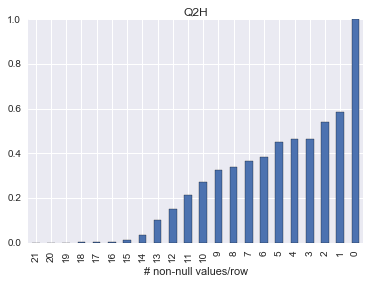

In [149]:
cumsum_dict = {}
na_counts = df_q2h.apply(pd.isnull).sum(axis=1).value_counts().sort_index()
prop = (na_counts / na_counts.sum())
cumsum_prop = (na_counts.cumsum() / na_counts.sum())
cumsum_prop.index = df_joined.columns.size - cumsum_prop.index
cumsum_prop.index.name = '# non-null values/row'
cumsum_dict['Q2H'] = cumsum_prop
cumsum_prop.plot.bar(title='Q2H')

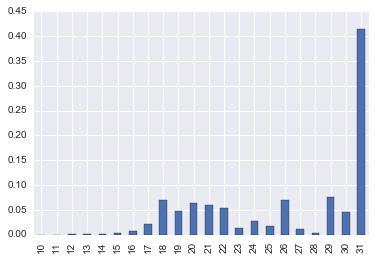

In [116]:
prop.plot.bar()

In [ ]:
df_q6h = df_joined.groupby(level='id').resample(rule='6H',level=column_names.DATETIME).mean()

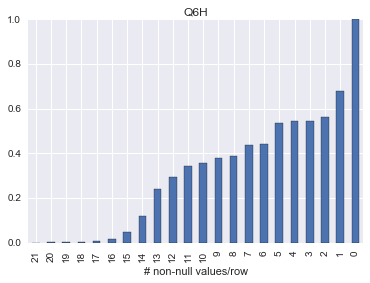

In [150]:
na_counts = df_q6h.apply(pd.isnull).sum(axis=1).value_counts().sort_index()
prop = (na_counts / na_counts.sum())
cumsum_prop = (na_counts.cumsum() / na_counts.sum())
cumsum_prop.index = df_joined.columns.size - cumsum_prop.index
cumsum_prop.index.name = '# non-null values/row'
cumsum_dict['Q6H'] = cumsum_prop
cumsum_prop.plot.bar(title='Q6H')

In [ ]:
df_q12h = df_joined.groupby(level='id').resample(rule='12H',level=column_names.DATETIME).mean()

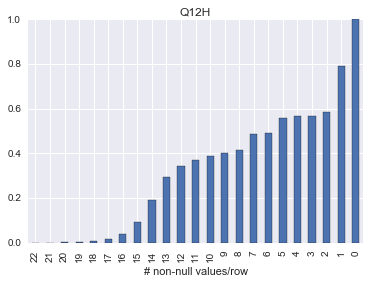

In [151]:
na_counts = df_q12h.apply(pd.isnull).sum(axis=1).value_counts().sort_index()
prop = (na_counts / na_counts.sum())
cumsum_prop = (na_counts.cumsum() / na_counts.sum())
cumsum_prop.index = df_joined.columns.size - cumsum_prop.index
cumsum_prop.index.name = '# non-null values/row'
cumsum_prop.name = 'Q12H'
cumsum_dict['Q12H'] = cumsum_prop
cumsum_prop.plot.bar(title='Q12H')

In [127]:
df_q24h = df_joined.groupby(level='id').resample(rule='24H',level=column_names.DATETIME).mean()

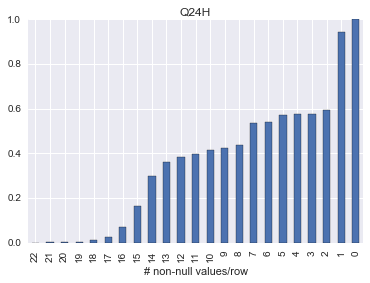

In [152]:
na_counts = df_q24h.apply(pd.isnull).sum(axis=1).value_counts().sort_index()
prop = (na_counts / na_counts.sum())
cumsum_prop = (na_counts.cumsum() / na_counts.sum())
cumsum_prop.index = df_joined.columns.size - cumsum_prop.index
cumsum_prop.index.name = '# non-null values/row'
cumsum_dict['Q24H'] = cumsum_prop
cumsum_prop.plot.bar(title='Q24H')


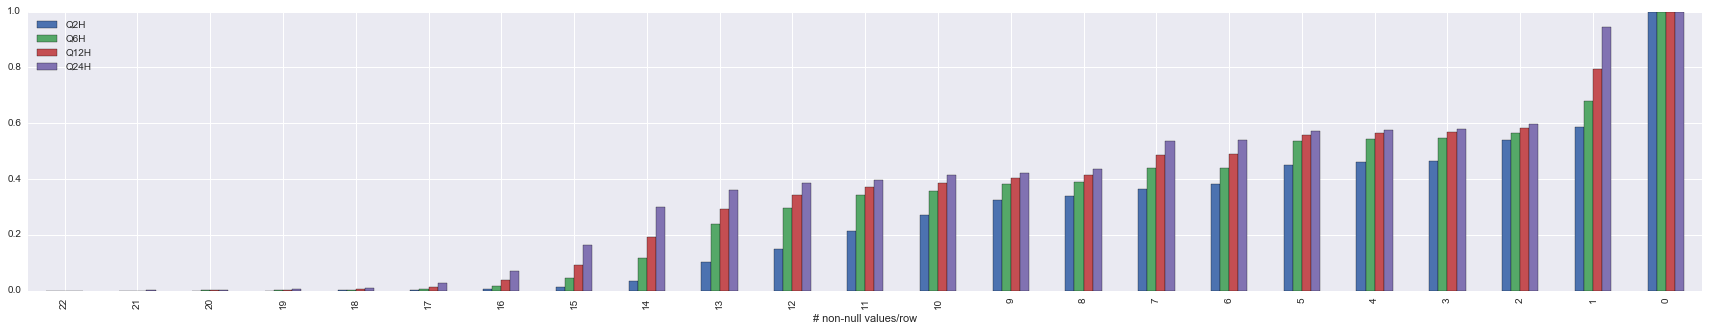

In [162]:
pd.DataFrame(cumsum_dict)[['Q2H','Q6H','Q12H','Q24H']].sort_index(ascending=False).plot.bar(figsize=(30,5))

In [133]:
df_q2h.loc[( df_joined.columns.size - df_q2h.apply(pd.isnull).sum(axis=1) )== 0].dropna(how='all')

Empty DataFrame
Columns: [(blood pressure diastolic, known, qn, mmHg, all), (blood pressure diastolic, unknown, qn, cc/min, all), (blood pressure mean, known, qn, mmHg, all), (blood pressure systolic, known, qn, mmHg, all), (blood pressure systolic, unknown, qn, cc/min, all), (glasgow coma scale eye opening, known, ord, no_units, all), (glasgow coma scale motor, known, ord, no_units, all), (glasgow coma scale verbal, known, ord, no_units, all), (heart rate, known, qn, beats/min, all), (hemoglobin, known, qn, g/dL, all), (lactate, known, qn, mmol/L, all), (lactated ringers, known, qn, mL, all), (lactated ringers, known, qn, mL/hr, all), (lactated ringers, unknown, qn, no_units, all), (norepinephrine, known, qn, mcg, all), (norepinephrine, known, qn, mcg/kg/min, all), (norepinephrine, known, qn, mcg/min, all), (normal saline, known, qn, mL, all), (normal saline, known, qn, mL/hr, all), (output urine, known, qn, mL, all), (output urine, unknown, nom, no_units, 3686(ml)_No Void), (output urine, unknown, nom, no_units, 3686(ml)_Voiding qs), (output urine, unknown, nom, no_units, 3686_Voiding qs), (output urine, unknown, qn, no_units, all), (oxygen saturation pulse oximetry, known, qn, percent, all), (respiratory rate, known, qn, insp/min, all), (respiratory rate, unknown, qn, Breath, all), (temperature body, known, qn, degF, all), (vasopressin, known, qn, units, all), (vasopressin, known, qn, units/min, all), (weight body, known, qn, kg, all)]
Index: []

[0 rows x 31 columns]

In [189]:
df_joined.iloc[:100].groupby(level='id').resample('6H',level=column_names.DATETIME).last().groupby(level='id').ffill()

component                  blood pressure diastolic          \
status                                        known unknown   
variable_type                                    qn      qn   
units                                          mmHg  cc/min   
description                                     all     all   
id     datetime                                               
100029 2185-04-17 12:00:00                      NaN    27.0   
       2185-04-17 18:00:00                      NaN    36.0   
       2185-04-18 00:00:00                      NaN    36.0   
       2185-04-18 06:00:00                      NaN    36.0   
       2185-04-18 12:00:00                      NaN    36.0   
       2185-04-18 18:00:00                      NaN    40.0   
       2185-04-19 00:00:00                      NaN    40.0   
       2185-04-19 06:00:00                      NaN    40.0   
       2185-04-19 12:00:00                      NaN    40.0   
       2185-04-19 18:00:00                      NaN    34.0   
       2185-04-20 00:00:00                      NaN    34.0   
       2185-04-20 06:00:00                      NaN    34.0   
       2185-04-20 12:00:00                      NaN    34.0   
       2185-04-20 18:00:00                      NaN    34.0   
       2185-04-21 00:00:00                      NaN    43.0   
       2185-04-21 06:00:00                      NaN    43.0   
       2185-04-21 12:00:00                      NaN    43.0   

component                  blood pressure mean blood pressure systolic  \
status                                   known                   known   
variable_type                               qn                      qn   
units                                     mmHg                    mmHg   
description                                all                     all   
id     datetime                                                          
100029 2185-04-17 12:00:00                 NaN                     NaN   
       2185-04-17 18:00:00                 NaN                     NaN   
       2185-04-18 00:00:00                 NaN                     NaN   
       2185-04-18 06:00:00                 NaN                     NaN   
       2185-04-18 12:00:00                 NaN                     NaN   
       2185-04-18 18:00:00                 NaN                     NaN   
       2185-04-19 00:00:00                 NaN                     NaN   
       2185-04-19 06:00:00                 NaN                     NaN   
       2185-04-19 12:00:00                 NaN                     NaN   
       2185-04-19 18:00:00                 NaN                     NaN   
       2185-04-20 00:00:00                 NaN                     NaN   
       2185-04-20 06:00:00                 NaN                     NaN   
       2185-04-20 12:00:00                 NaN                     NaN   
       2185-04-20 18:00:00                 NaN                     NaN   
       2185-04-21 00:00:00                 NaN                     NaN   
       2185-04-21 06:00:00                 NaN                     NaN   
       2185-04-21 12:00:00                 NaN                     NaN   

component                          glasgow coma scale eye opening  \
status                     unknown                          known   
variable_type                   qn                            ord   
units                       cc/min                       no_units   
description                    all                            all   
id     datetime                                                     
100029 2185-04-17 12:00:00    52.0                            NaN   
       2185-04-17 18:00:00    60.0                            NaN   
       2185-04-18 00:00:00    60.0                            NaN   
       2185-04-18 06:00:00    60.0                            NaN   
       2185-04-18 12:00:00    60.0                            NaN   
       2185-04-18 18:00:00    54.0                            NaN   
       2185-04-19 0

In [190]:
df_joined.iloc[:100].groupby(level='id').resample('6H',level=column_names.DATETIME).mean()

component                  blood pressure diastolic             \
status                                        known    unknown   
variable_type                                    qn         qn   
units                                          mmHg     cc/min   
description                                     all        all   
id     datetime                                                  
100029 2185-04-17 12:00:00                      NaN  36.333333   
       2185-04-17 18:00:00                      NaN  36.000000   
       2185-04-18 00:00:00                      NaN        NaN   
       2185-04-18 06:00:00                      NaN        NaN   
       2185-04-18 12:00:00                      NaN        NaN   
       2185-04-18 18:00:00                      NaN  40.000000   
       2185-04-19 00:00:00                      NaN        NaN   
       2185-04-19 06:00:00                      NaN        NaN   
       2185-04-19 12:00:00                      NaN        NaN   
       2185-04-19 18:00:00                      NaN  34.000000   
       2185-04-20 00:00:00                      NaN        NaN   
       2185-04-20 06:00:00                      NaN        NaN   
       2185-04-20 12:00:00                      NaN        NaN   
       2185-04-20 18:00:00                      NaN        NaN   
       2185-04-21 00:00:00                      NaN  43.000000   
       2185-04-21 06:00:00                      NaN        NaN   
       2185-04-21 12:00:00                      NaN        NaN   

component                  blood pressure mean blood pressure systolic  \
status                                   known                   known   
variable_type                               qn                      qn   
units                                     mmHg                    mmHg   
description                                all                     all   
id     datetime                                                          
100029 2185-04-17 12:00:00                 NaN                     NaN   
       2185-04-17 18:00:00                 NaN                     NaN   
       2185-04-18 00:00:00                 NaN                     NaN   
       2185-04-18 06:00:00                 NaN                     NaN   
       2185-04-18 12:00:00                 NaN                     NaN   
       2185-04-18 18:00:00                 NaN                     NaN   
       2185-04-19 00:00:00                 NaN                     NaN   
       2185-04-19 06:00:00                 NaN                     NaN   
       2185-04-19 12:00:00                 NaN                     NaN   
       2185-04-19 18:00:00                 NaN                     NaN   
       2185-04-20 00:00:00                 NaN                     NaN   
       2185-04-20 06:00:00                 NaN                     NaN   
       2185-04-20 12:00:00                 NaN                     NaN   
       2185-04-20 18:00:00                 NaN                     NaN   
       2185-04-21 00:00:00                 NaN                     NaN   
       2185-04-21 06:00:00                 NaN                     NaN   
       2185-04-21 12:00:00                 NaN                     NaN   

component                             glasgow coma scale eye opening  \
status                        unknown                          known   
variable_type                      qn                            ord   
units                          cc/min                       no_units   
description                       all                            all   
id     datetime                                                        
100029 2185-04-17 12:00:00  55.333333                            NaN   
       2185-04-17 18:00:00  60.000000                            NaN   
       2185-04-18 00:00:00        NaN                            NaN   
       2185-04-18 06:00:00        NaN                            NaN   
       2185-04-18 12:00:00        NaN                     